Starting 5 replications...
RUNNING 5 REPLICATIONS OF SURVIVAL ANALYSIS SIMULATION
Using 13 parallel processes


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.


Generated 1000 samples with 10 features
Target censoring rate: 0.30, Actual: 0.59
Total samples: 1000
Training samples: 800 (80.0%)
Validation samples: 199 (19.9%)
Targeting samples: 1 (0.1%)
Total samples: 1000
Training samples: 800 (80.0%)
Validation samples: 199 (19.9%)
Targeting samples: 1 (0.1%)
Total samples: 1000
Training samples: 800 (80.0%)
Validation samples: 199 (19.9%)
Targeting samples: 1 (0.1%)
Total samples: 1000
Training samples: 800 (80.0%)
Validation samples: 199 (19.9%)
Targeting samples: 1 (0.1%)
Total samples: 1000
Training samples: 800 (80.0%)
Validation samples: 199 (19.9%)
Targeting samples: 1 (0.1%)


[Parallel(n_jobs=13)]: Done   2 out of   5 | elapsed:  4.0min remaining:  6.0min
[Parallel(n_jobs=13)]: Done   3 out of   5 | elapsed:  4.4min remaining:  2.9min
[Parallel(n_jobs=13)]: Done   5 out of   5 | elapsed:  8.3min finished



SIMULATION RESULTS SUMMARY
Number of replications: 5

Average Metrics across all replications:
              Metric              Initial         Kaplan-Meier             Targeted
                 MSE 0.002067 (±0.002281) 0.000985 (±0.000726) 0.002138 (±0.002112)
       Absolute Bias 0.036205 (±0.025660) 0.024921 (±0.011218) 0.037149 (±0.024128)
            Variance 0.055439 (±0.009431) 0.060132 (±0.003221) 0.057088 (±0.009067)
Model-Based Coverage     0.8760 (±0.2080)     0.7600 (±0.2121)     0.7920 (±0.2203)
     Oracle Coverage               0.8600               0.9000               0.8000
            CI Width       0.1640 /0.1276       0.0731 /0.0805      0.1496 / 0.1246
Error in simulation: 'pointwise_coverage_mean'
Simulation failed. Please check the code for errors.


Traceback (most recent call last):
  File "/var/folders/s9/cp67nwl1685gb_f0prtd64sm0000gn/T/ipykernel_8370/2889294451.py", line 1906, in <module>
    model_coverage_mean = results['aggregate_metrics']['pointwise_coverage_mean']
KeyError: 'pointwise_coverage_mean'


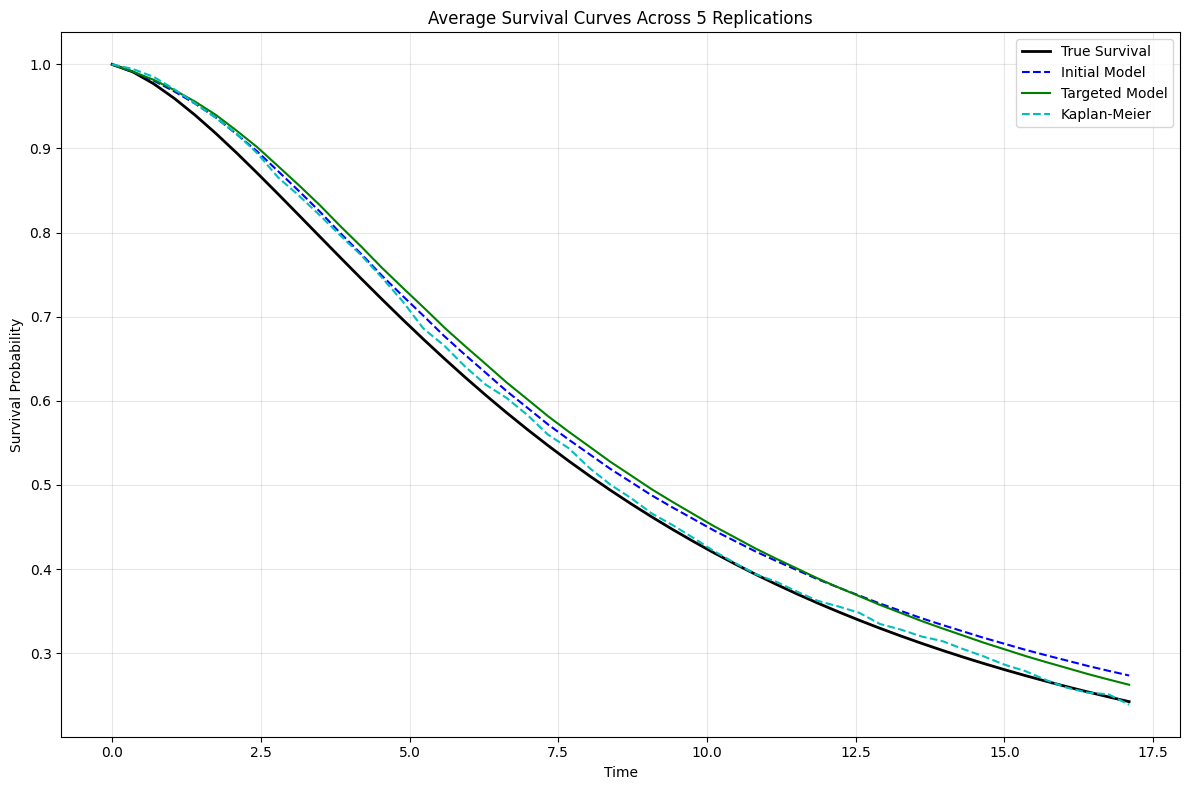

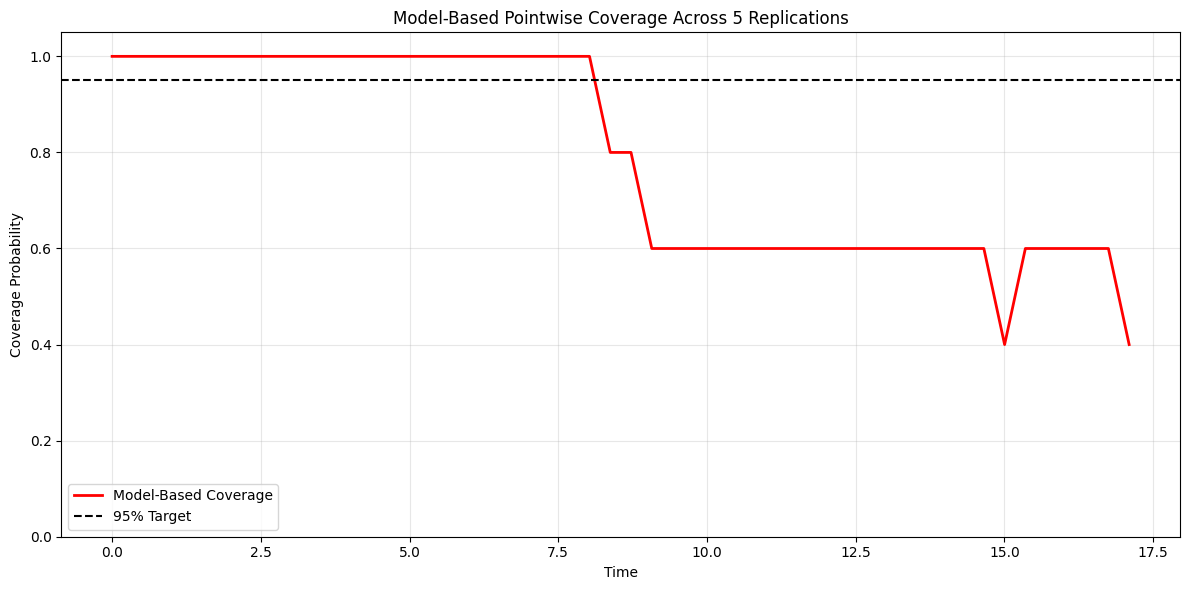

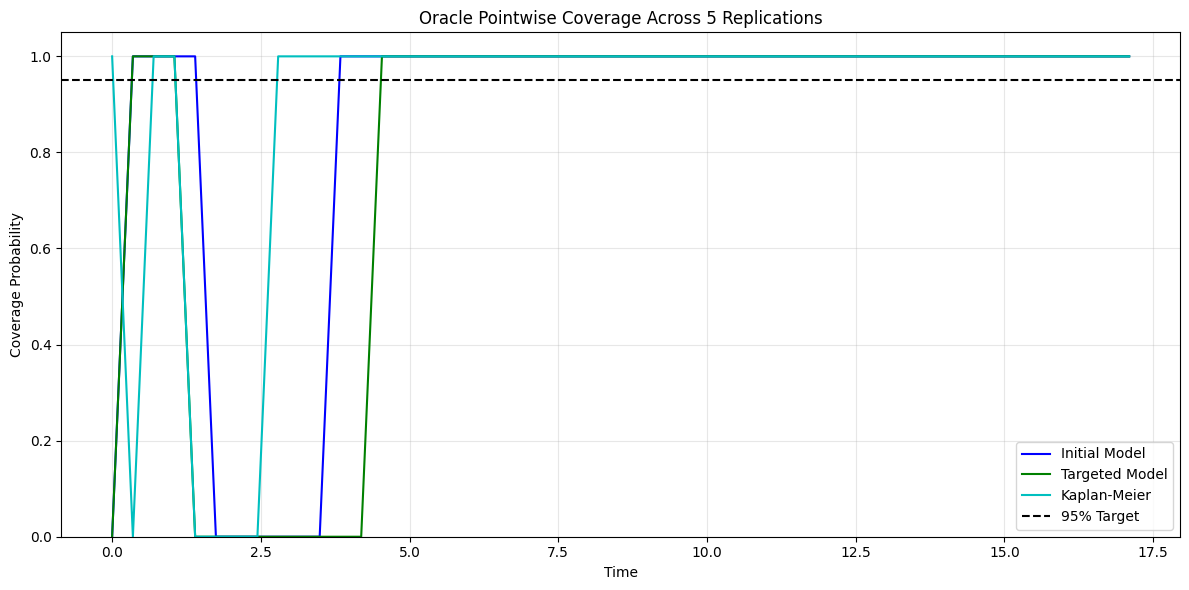

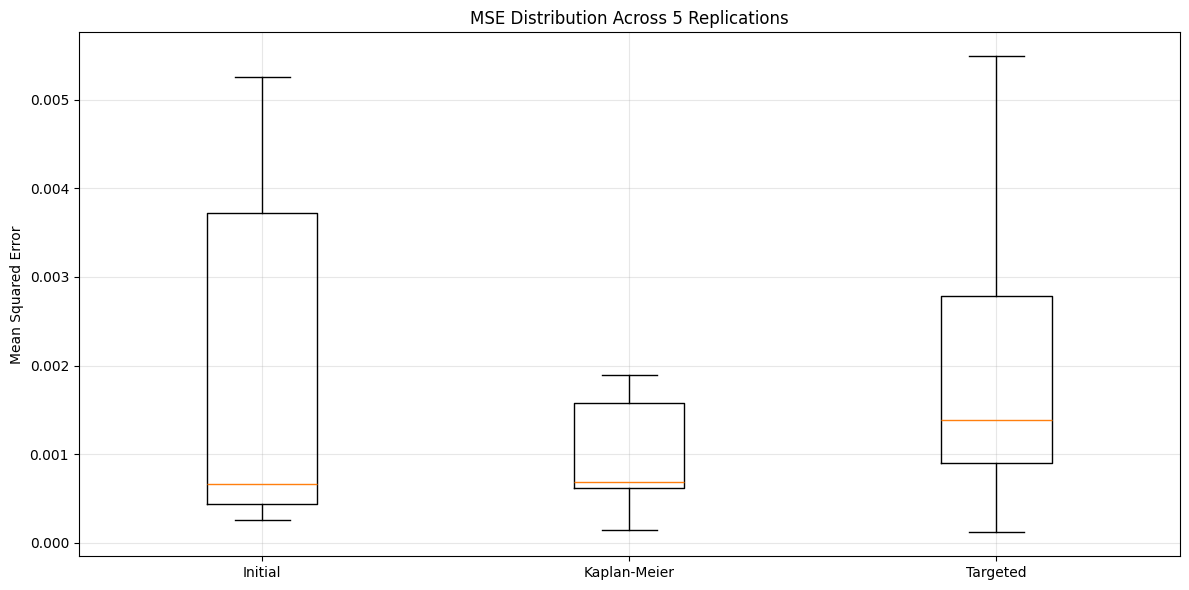

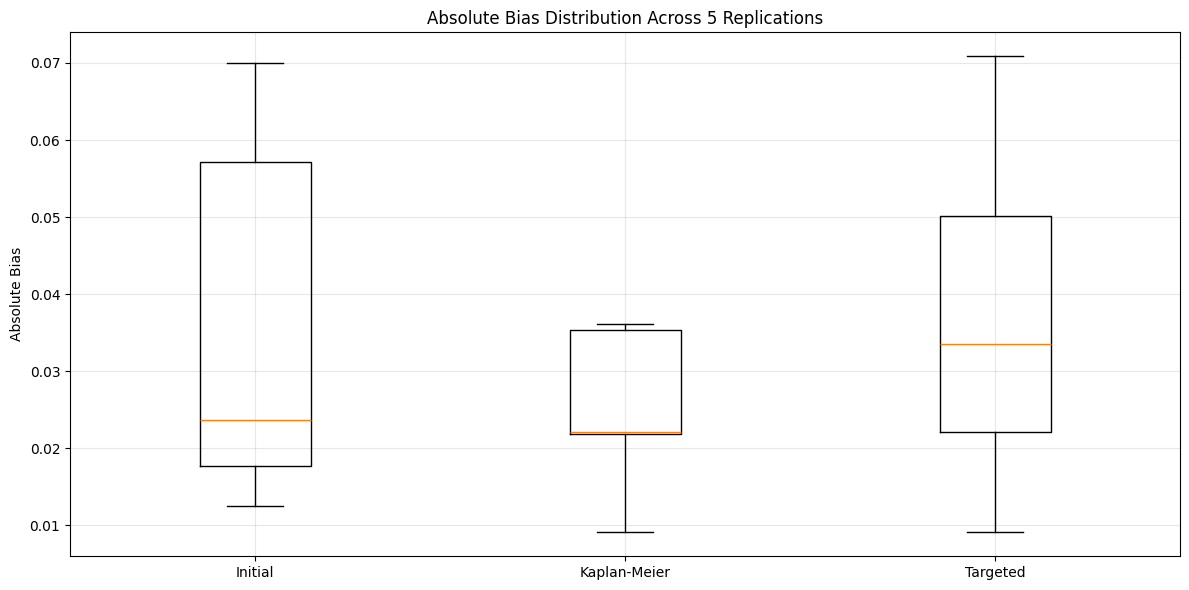

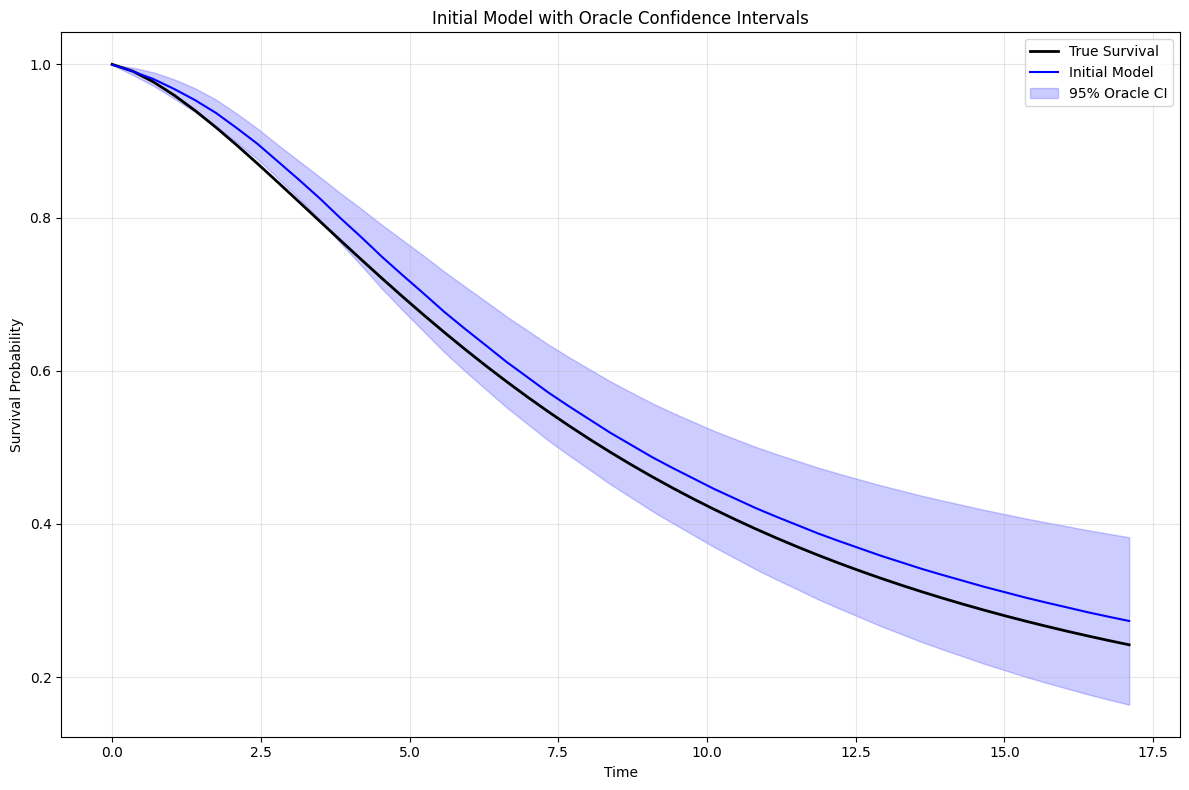

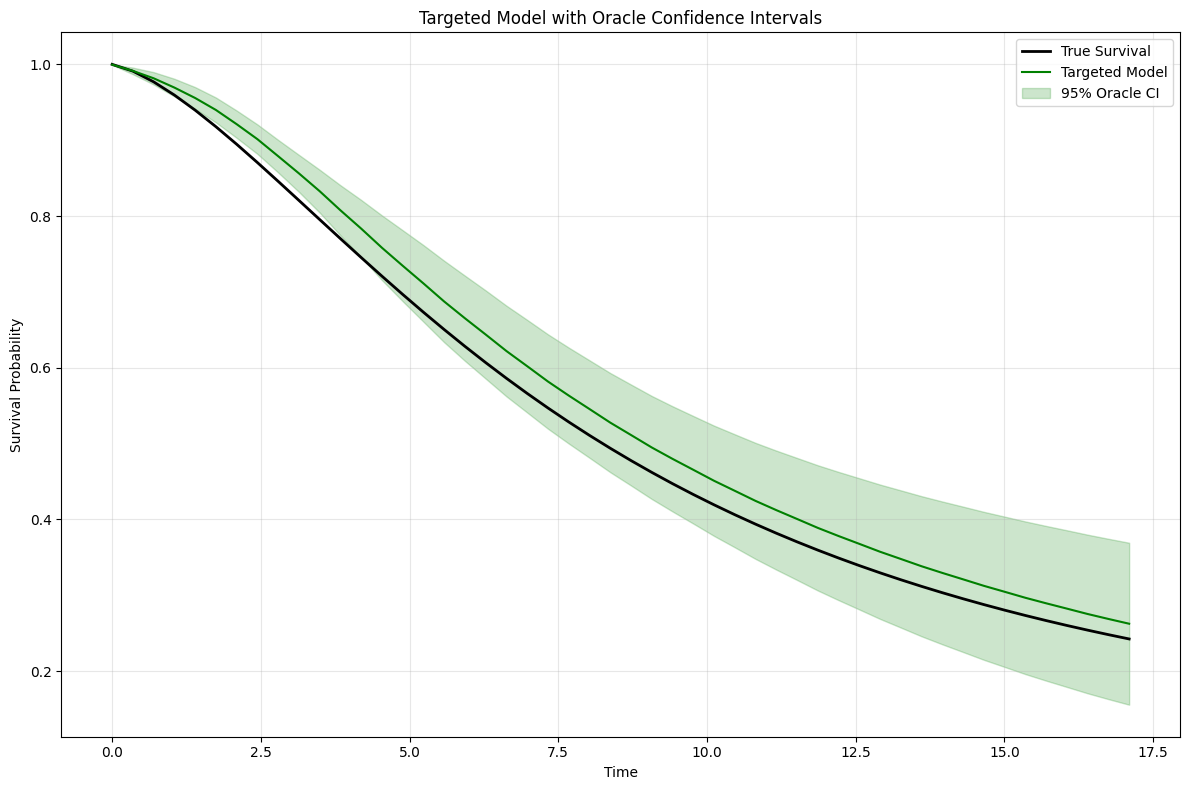

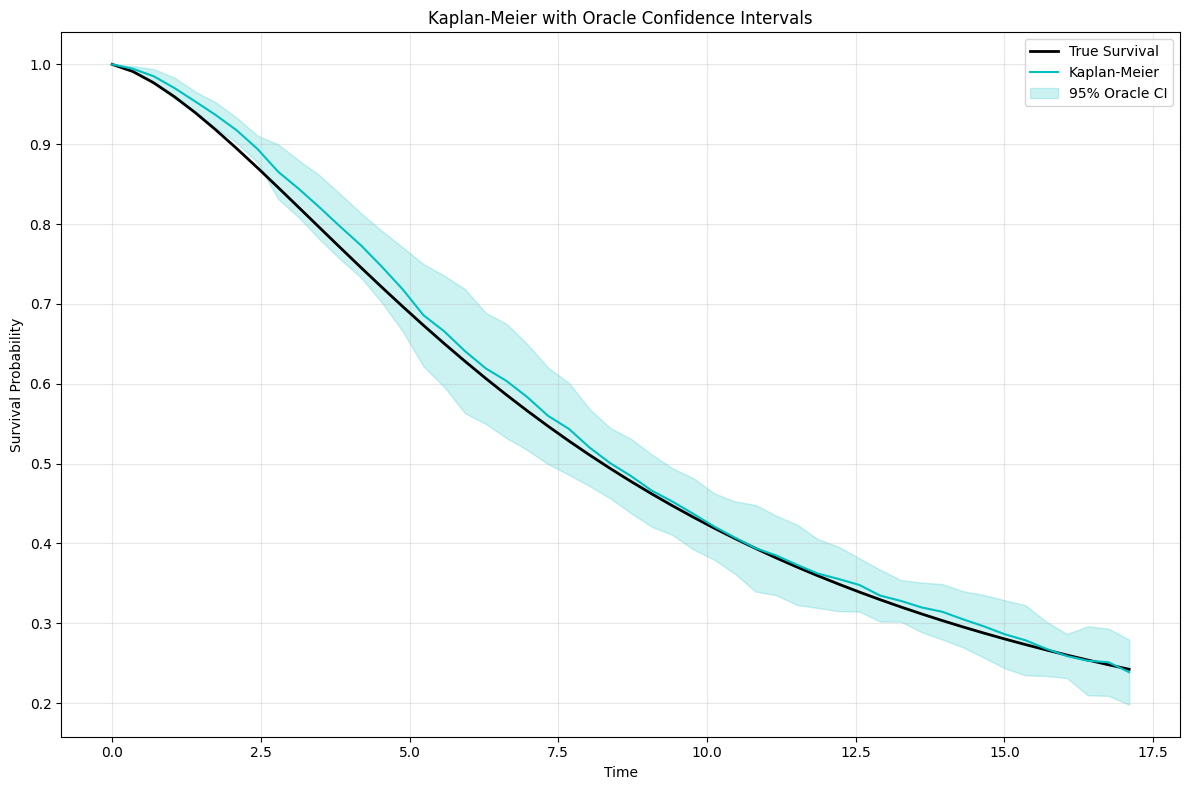

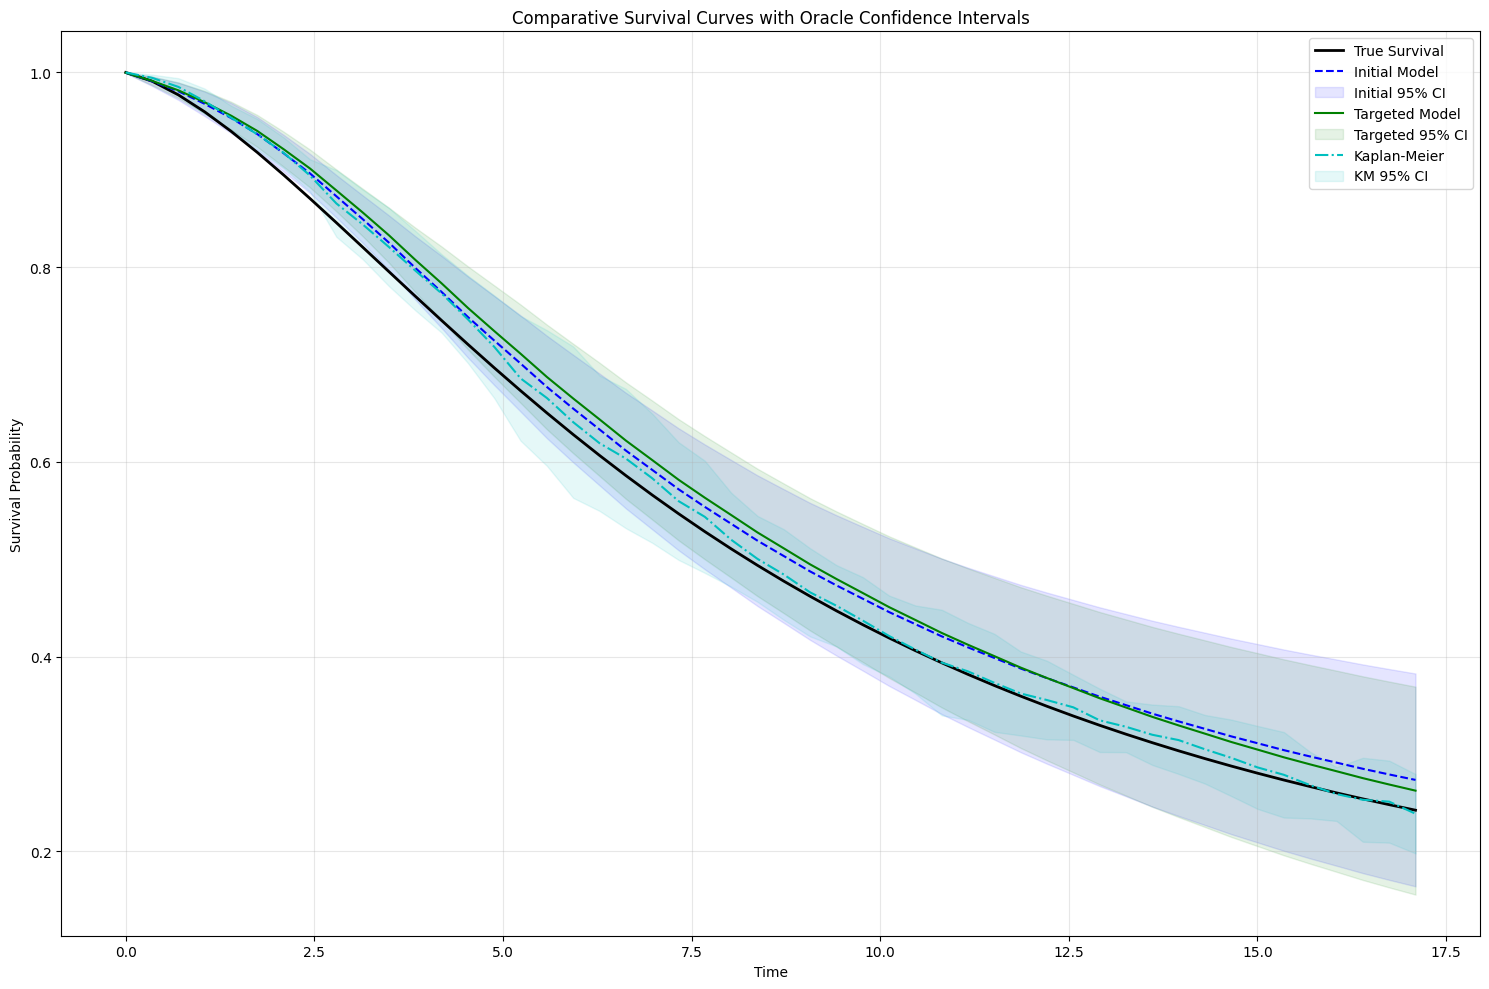

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
import seaborn as sns
import time
from sklearn.linear_model import Lasso, PoissonRegressor
import warnings
from tqdm import tqdm
import os
import multiprocessing
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class HazardNN(nn.Module):
    """Neural Network for Flexible Hazard Modeling"""
    def __init__(self, input_dim, hidden_layers=[256, 256, 128], dropout_rate=0.2):
        super(HazardNN, self).__init__()

        # Create feature representation layers with dropout
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h_dim

        # Final layer for log hazard prediction
        layers.append(nn.Linear(prev_dim, 1))

        # Combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        Forward pass with both covariates and time
        x: covariates
        t: time points
        """
        # Combine covariates and time
        inputs = torch.cat([x, t.unsqueeze(1)], dim=1)
        return self.model(inputs)

    def get_features(self, x, t):
        """Get feature representation before final layer"""
        # Extract all but the last layer
        feature_extractor = nn.Sequential(*list(self.model.children())[:-1])
        inputs = torch.cat([x, t.unsqueeze(1)], dim=1)
        return feature_extractor(inputs)

    def clone(self):
        """Create a deep copy of the model"""
        # Get the input dimension from the first layer
        input_dim = next(iter(self.model.parameters())).shape[1]

        # Extract hidden layer dimensions
        hidden_layers = []
        for i, layer in enumerate(self.model):
            if isinstance(layer, nn.Linear) and i < len(self.model) - 1:
                hidden_layers.append(layer.out_features)

        # Create a new model with the same architecture
        clone = HazardNN(input_dim, hidden_layers,
                         dropout_rate=0.2 if any(isinstance(layer, nn.Dropout) for layer in self.model) else 0.0)

        # Copy the parameters
        clone.load_state_dict(self.state_dict())
        return clone

def generate_complex_survival_data(n_samples=1000, n_features=10, censoring_rate=0.3, seed=42,informative_censoring=True):
    """
    Generate complex survival data that doesn't follow Cox proportional hazards
    """
    np.random.seed(seed)

    # Generate covariates
    X = np.random.randn(n_samples, n_features)

    # Generate true coefficients
    beta_true = np.random.randn(n_features) / np.sqrt(n_features)

    # Generate event times using a complex non-proportional hazards model
    event_times = np.zeros(n_samples)

    for i in range(n_samples):
        # Weibull baseline hazard parameters
        shape = 1.5  # Shape parameter > 1 means increasing hazard over time
        scale = 10.0  # Scale parameter

        # Get covariates for this subject
        x_i = X[i]

        # Time-varying effect (first 3 features)
        time_varying_coef = x_i[:3] @ beta_true[:3]

        # Non-linear effect (next 3 features)
        nonlinear_effect = np.sum(np.exp(x_i[3:6] * beta_true[3:6])) - 3

        # Interaction effects (last 4 features)
        interaction_effect = 0
        for j in range(6, n_features):
            for k in range(j+1, n_features):
                interaction_effect += x_i[j] * x_i[k] * beta_true[j] * beta_true[k]

        # Combine all effects for the scale parameter
        # This makes the hazard non-proportional and complex
        adjusted_scale = scale / (np.exp(0.5 * (nonlinear_effect + interaction_effect)))

        # Draw from Weibull distribution
        u = np.random.uniform(0, 1)

        # Numerical approximation for complex model
        t_grid = np.linspace(0.01, 30, 1000)
        cumulative_hazard = np.zeros_like(t_grid)

        for idx, t in enumerate(t_grid):
            # Time-varying coefficient effect
            tv_effect = time_varying_coef * np.sqrt(t)

            # Weibull baseline hazard
            baseline = shape/adjusted_scale * (t/adjusted_scale)**(shape-1)

            # Full hazard
            hazard = baseline * np.exp(tv_effect)

            # Accumulate hazard
            if idx > 0:
                dt = t_grid[idx] - t_grid[idx-1]
                cumulative_hazard[idx] = cumulative_hazard[idx-1] + hazard * dt

        # Find event time (where cumulative hazard crosses -log(u))
        threshold = -np.log(u)
        idx = np.searchsorted(cumulative_hazard, threshold)
        if idx < len(t_grid):
            event_times[i] = t_grid[idx]
        else:
            event_times[i] = t_grid[-1]

    # Generate censoring times to achieve desired censoring rate
    # Exponential distribution with rate set to achieve target censoring

    # Generate informative censoring times
    if informative_censoring:
        # Define new coefficients for censoring (different from event coefficients)
        # We'll make some features increase and some decrease censoring risk
        # This creates informative censoring correlated with covariates
        censor_beta = np.zeros(n_features)
        # First half of features positively affect censoring
        censor_beta[:n_features//2] = np.random.uniform(0.1, 0.5, size=n_features//2)
        # Second half negatively affect censoring
        censor_beta[n_features//2:] = np.random.uniform(-0.5, -0.1, size=n_features-n_features//2)
        
        # Base censoring time (larger value = less censoring)
        base_censor_time = 15.0
        
        # Generate censoring times using a Weibull model with covariate effects
        censor_times = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Get covariates for this subject
            x_i = X[i]
            
            # Baseline parameters for censoring
            censor_shape = 1.2  # Similar to event shape but different
            
            # Adjust scale based on covariates (informative censoring)
            # Higher values = longer censoring times = less censoring
            # Use different combination of features than for events
            # Including a time-varying component
            
            # Linear component
            linear_effect = x_i @ censor_beta
            
            # Add a non-linear effect for specific features (e.g., features 2, 3, 4)
            nonlinear_censor_effect = np.sum(np.abs(x_i[2:5])**1.5) * 0.3
            
            # Combine effects - positive values increase censoring time (less censoring)
            censor_scale = base_censor_time * np.exp(linear_effect - nonlinear_censor_effect)
            
            # Ensure scale is positive
            censor_scale = max(censor_scale, 0.5)
            
            # Draw from Weibull
            u = np.random.uniform(0, 1)
            # Weibull inverse CDF: t = scale * (-ln(1-u))^(1/shape)
            censor_times[i] = censor_scale * (-np.log(u))**(1/censor_shape)
    else:
        # Original simple exponential censoring
        censor_times = np.random.exponential(
            scale=np.quantile(event_times, 1-censoring_rate),
            size=n_samples
        )

    # Determine observed times and event indicators
    observed_times = np.minimum(event_times, censor_times)
    event_indicators = (event_times <= censor_times).astype(int)

    # Compute actual censoring rate
    actual_censor_rate = 1 - event_indicators.mean()

    if seed == 42:  # Only print for the first replication
        print(f"Generated {n_samples} samples with {n_features} features")
        print(f"Target censoring rate: {censoring_rate:.2f}, Actual: {actual_censor_rate:.2f}")

    return X, observed_times, event_indicators, event_times, censor_times

def compute_true_survival(X, time_grid, n_features=10, seed=42):
    """
    Compute the true survival function for the same data generating process
    """
    np.random.seed(seed)
    n_samples = X.shape[0]

    # Generate true coefficients (same as in data generation)
    beta_true = np.random.randn(n_features) / np.sqrt(n_features)

    # Matrix to store survival probabilities
    survival = np.zeros((n_samples, len(time_grid)))

    # For each subject
    for i in range(n_samples):
        # Get covariates
        x_i = X[i]

        # Setup effects
        time_varying_coef = x_i[:3] @ beta_true[:3]
        nonlinear_effect = np.sum(np.exp(x_i[3:6] * beta_true[3:6])) - 3

        interaction_effect = 0
        for j in range(6, n_features):
            for k in range(j+1, n_features):
                interaction_effect += x_i[j] * x_i[k] * beta_true[j] * beta_true[k]

        # Adjusted scale
        shape = 1.5
        scale = 10.0
        adjusted_scale = scale / (np.exp(0.5 * (nonlinear_effect + interaction_effect)))

        # For each time point
        for j, t in enumerate(time_grid):
            # Numerical integration for hazard
            if t > 0:
                t_fine = np.linspace(0.01, t, 100)
                dt = t_fine[1] - t_fine[0]

                cum_hazard = 0
                for t_val in t_fine:
                    # Time-varying effect
                    tv_effect = time_varying_coef * np.sqrt(t_val)

                    # Weibull baseline
                    baseline = shape/adjusted_scale * (t_val/adjusted_scale)**(shape-1)

                    # Full hazard
                    hazard = baseline * np.exp(tv_effect)

                    cum_hazard += hazard * dt

                # Survival = exp(-cumulative hazard)
                survival[i, j] = np.exp(-cum_hazard)
            else:
                survival[i, j] = 1.0

    # Compute marginal survival
    marginal_survival = np.mean(survival, axis=0)

    return marginal_survival

def create_time_expanded_dataset(X, T, E, time_grid):
    """
    Create expanded dataset where each subject has an entry for each time point
    they're at risk
    """
    n_samples = len(X)
    n_times = len(time_grid) - 1

    # Find interval for each subject's event/censoring time
    T_bin = np.array([np.searchsorted(time_grid, t, side='right') - 1 for t in T])

    # Create lists to build expanded dataset
    expanded_X = []
    expanded_times = []
    expanded_events = []
    expanded_risk_times = []
    expanded_ids = []

    for i in range(n_samples):
        # Expand for each time bin where subject is at risk
        for bin_idx in range(min(T_bin[i] + 1, n_times)):
            expanded_X.append(X[i])
            expanded_times.append(time_grid[bin_idx])

            # Event indicator: 1 if this is the time bin where event occurred and not censored
            is_event = (bin_idx == T_bin[i]) and (E[i] == 1)
            expanded_events.append(float(is_event))

            # Time at risk in this interval
            if bin_idx < T_bin[i]:
                risk_time = time_grid[bin_idx + 1] - time_grid[bin_idx]
            else:
                risk_time = T[i] - time_grid[bin_idx]
            expanded_risk_times.append(risk_time)

            # Keep track of original ID
            expanded_ids.append(i)

    # Convert to numpy arrays
    expanded_X = np.vstack(expanded_X)
    expanded_times = np.array(expanded_times)
    expanded_events = np.array(expanded_events)
    expanded_risk_times = np.array(expanded_risk_times)
    expanded_ids = np.array(expanded_ids)

    return expanded_X, expanded_times, expanded_events, expanded_risk_times, expanded_ids

def poisson_loss(log_hazards, events, risk_times):
    """
    Poisson log-likelihood loss function for hazard modeling
    """
    # Handle potential shape issues by explicitly squeezing
    log_hazards_squeezed = log_hazards.squeeze()
    hazards = torch.exp(log_hazards_squeezed)
    
    # Make sure all tensors are properly aligned
    events_aligned = events.view(hazards.shape)
    risk_times_aligned = risk_times.view(hazards.shape)
    
    # Calculate loss
    loss = ((1 - events_aligned) * (risk_times_aligned * hazards) +
            events_aligned * (risk_times_aligned * hazards - log_hazards_squeezed))
    
    # Return scalar by summing
    return torch.sum(loss)

def train_hazard_nn(X, T, E, time_grid, hidden_layers=[64, 32, 16],
                   dropout_rate=0.2, lr=0.001, epochs=100, batch_size=128,
                   validation_data=None, early_stopping_patience=10, verbose=1):
    """
    Train neural network for flexible hazard modeling
    """
    # Create expanded dataset
    X_exp, times_exp, events_exp, risk_times_exp, ids_exp = create_time_expanded_dataset(X, T, E, time_grid)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_exp)
    times_tensor = torch.FloatTensor(times_exp)
    events_tensor = torch.FloatTensor(events_exp)
    risk_times_tensor = torch.FloatTensor(risk_times_exp)

    # Create model (input dimension includes time)
    model = HazardNN(X.shape[1] + 1, hidden_layers, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # For early stopping
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    # Training history
    train_losses = []
    val_losses = []

    # Prepare validation data if provided
    if validation_data is not None:
        X_val, T_val, E_val = validation_data
        X_val_exp, times_val_exp, events_val_exp, risk_times_val_exp, ids_val_exp = create_time_expanded_dataset(
            X_val, T_val, E_val, time_grid)

        X_val_tensor = torch.FloatTensor(X_val_exp)
        times_val_tensor = torch.FloatTensor(times_val_exp)
        events_val_tensor = torch.FloatTensor(events_val_exp)
        risk_times_val_tensor = torch.FloatTensor(risk_times_val_exp)

    # Training loop
    start_time = time.time()
    n_samples = len(X_tensor)
    n_batches = int(np.ceil(n_samples / batch_size))

    for epoch in range(epochs):
        # Shuffle data
        shuffle_idx = torch.randperm(n_samples)
        X_shuffled = X_tensor[shuffle_idx]
        times_shuffled = times_tensor[shuffle_idx]
        events_shuffled = events_tensor[shuffle_idx]
        risk_times_shuffled = risk_times_tensor[shuffle_idx]

        # Training step (batched)
        model.train()
        epoch_loss = 0

        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, n_samples)

            X_batch = X_shuffled[start_idx:end_idx]
            times_batch = times_shuffled[start_idx:end_idx]
            events_batch = events_shuffled[start_idx:end_idx]
            risk_times_batch = risk_times_shuffled[start_idx:end_idx]

            optimizer.zero_grad()
            log_hazards = model(X_batch, times_batch)
            loss = poisson_loss(log_hazards, events_batch, risk_times_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / n_samples)

        # Validation step
        if validation_data is not None:
            model.eval()
            with torch.no_grad():
                log_hazards_val = model(X_val_tensor, times_val_tensor)
                val_loss = poisson_loss(log_hazards_val, events_val_tensor, risk_times_val_tensor)
                val_loss = val_loss.item() / len(X_val_tensor)
                val_losses.append(val_loss)

                # Check for improvement
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1

                # Early stopping check
                if patience_counter >= early_stopping_patience:
                    if verbose > 0:
                        print(f"Early stopping at epoch {epoch+1}. Best epoch was {best_epoch+1}.")
                    break

        if verbose > 0 and (epoch + 1) % 10 == 0:
            elapsed = time.time() - start_time
            if validation_data is not None:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Time: {elapsed:.1f}s")
            else:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Time: {elapsed:.1f}s")

    # Final training time
    train_time = time.time() - start_time
    if verbose > 0:
        print(f"Training completed in {train_time:.2f} seconds")

    # Load best model if early stopping was used
    if validation_data is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)
        if verbose > 0:
            print(f"Restored model from epoch {best_epoch+1} with validation loss {best_val_loss:.4f}")

    return model, train_losses, val_losses if validation_data is not None else None

def compute_survival_function(model, X, time_points, max_T):
    """
    Compute survival function for each subject at specified time points
    """
    n_samples = len(X)
    n_times = len(time_points)

    # Create fine-grained time grid for numerical integration
    fine_time_grid = np.linspace(0, max_T, 1000)
    dt = fine_time_grid[1] - fine_time_grid[0]

    # Convert to tensors
    X_tensor = torch.FloatTensor(X)
    time_tensor = torch.FloatTensor(fine_time_grid)

    # Compute hazards at all time points for all subjects
    cumulative_hazard = np.zeros((n_samples, n_times))
    survival = np.zeros((n_samples, n_times))

    model.eval()
    with torch.no_grad():
        # For each subject
        for i in range(n_samples):
            # Expand X for this subject across all fine time points
            X_i = X_tensor[i].repeat(len(fine_time_grid), 1)

            # Compute log hazards
            log_hazards = model(X_i, time_tensor).squeeze().numpy()
            hazards = np.exp(log_hazards)

            # Compute cumulative hazard function by numerical integration
            cum_hazard = np.cumsum(hazards * dt)

            # Interpolate to get values at specified time points
            for j, t in enumerate(time_points):
                idx = min(np.searchsorted(fine_time_grid, t), len(fine_time_grid) - 1)
                cumulative_hazard[i, j] = cum_hazard[idx]
                survival[i, j] = np.exp(-cumulative_hazard[i, j])

    return survival, cumulative_hazard

def compute_marginal_survival(survival_probs):
    """Compute marginal survival by averaging over all samples"""
    return np.mean(survival_probs, axis=0)

# ----- ADVANCED TARGETING METHODS -----

def compute_score_matrix_nn(model, X, T, E, time_grid):
    """
    Compute the individual-level score matrix for each subject based on
    the neural network model, analogous to the score matrix in the HAL approach.
    """
    n_samples = len(X)

    # Convert to tensors
    X_tensor = torch.FloatTensor(X)

    # Extract the final layer of the model for score computation
    final_layer = list(model.model.children())[-1]
    hidden_dim = final_layer.in_features

    # Initialize the score matrix (n_samples x hidden_dim)
    score_matrix = np.zeros((n_samples, hidden_dim))

    model.eval()
    with torch.no_grad():
        for i, (x_i, t_i, delta_i) in enumerate(zip(X, T, E)):
            # Part 1: For observed event/censoring time
            x_tensor = torch.FloatTensor(x_i).unsqueeze(0)
            t_tensor = torch.FloatTensor([t_i])

            # Get features at observed time
            features_t_i = model.get_features(x_tensor, t_tensor).numpy()[0]

            # Part 2: Integrate over time
            t_grid = np.linspace(0, t_i, len(time_grid))
            dt = t_grid[1] - t_grid[0] if len(t_grid) > 1 else t_i
            integrated_features = np.zeros(hidden_dim)

            for t in t_grid:
                t_tensor = torch.FloatTensor([t])
                features_t = model.get_features(x_tensor, t_tensor).numpy()[0]
                log_hazard = model(x_tensor, t_tensor).item()
                hazard = np.exp(log_hazard)
                integrated_features += hazard * features_t * dt

            # Final score: δ_i * X(t_i) - ∫_0^(t_i) exp(β^T X(u)) X(u) du
            score_matrix[i] = delta_i * features_t_i - integrated_features

    return score_matrix

def lasso_projection(A, b, lambda_val):
    """
    Compute the ridge projection using the direct closed-form solution
    with an explicit intercept term

    Args:
        A: Design matrix (n_samples, n_features)
        b: Target vector (n_samples,)
        lambda_val: Regularization parameter

    Returns:
        Coefficient vector from ridge regression (without intercept)
    """
    import numpy as np

    # Add a column of ones for the intercept
    n_samples = A.shape[0]
    A_with_intercept = np.column_stack((np.ones(n_samples), A))

    n_features_with_intercept = A_with_intercept.shape[1]
    A_T_A = A_with_intercept.T @ A_with_intercept

    # Create identity matrix but don't penalize the intercept
    # by setting the first diagonal element to a very small value
    identity = np.eye(n_features_with_intercept)
    identity[0, 0] = 1e-10  # Very small penalty for intercept

    # Add ridge penalty to diagonal (except for intercept)
    regularized_matrix = A_T_A + lambda_val * identity

    # Compute the closed-form solution
    try:
        # Using direct matrix inversion
        inverse = np.linalg.inv(regularized_matrix)
        beta_with_intercept = inverse @ A_with_intercept.T @ b
    except np.linalg.LinAlgError:
        # Fallback to more stable pseudoinverse approach
        beta_with_intercept = np.linalg.lstsq(regularized_matrix, A_with_intercept.T @ b, rcond=None)[0]

    beta = beta_with_intercept[1:]
    
    # Apply thresholding to prune small values to zero
    beta_thresholded = np.where(np.abs(beta) < 1e-5, 0, beta)
    
    # Discard the intercept and return only the coefficients
    return beta_thresholded  # Return only the coefficients (without intercept)

def cv_lasso_projection_nn(A, b, lambda_seq, cv_folds=5):
    """
    Perform cross-validation to select the best lambda for the lasso projection.
    """
    from sklearn.linear_model import LassoCV

    # Initialize and fit LassoCV
    model = LassoCV(alphas=lambda_seq, cv=cv_folds, max_iter=10000,
                    fit_intercept=True, random_state=123)
    model.fit(A, b)

    best_x = model.coef_
    best_lambda = model.alpha_
    # cv_mse_path_ is an array of shape (n_alphas, n_folds); we average across folds
    cv_errors = np.mean(model.mse_path_, axis=1)

    return best_x, best_lambda, cv_errors

def train_censoring_model(X, T, E, time_grid, hidden_layers=[32, 16], dropout_rate=0.2, epochs=50, batch_size=64, verbose=1):
    """
    Train a neural network model for conditional censoring hazard
    """
    # Reverse the event indicator to model censoring
    E_censoring = 1 - E

    # Use the same training function as the main model
    model, _, _ = train_hazard_nn(
        X, T, E_censoring, time_grid,
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=None,
        verbose=verbose
    )

    return model

def compute_conditional_censoring_survival(model, X, T, max_time):
    """
    Compute the conditional censoring survival G(t|X) for each subject at their observed time
    """
    n_samples = len(X)
    censoring_survival = np.zeros(n_samples)

    # Convert to tensors
    X_tensor = torch.FloatTensor(X)

    # Create fine time grid for numerical integration
    fine_time_grid = np.linspace(0, max_time, 1000)
    dt = fine_time_grid[1] - fine_time_grid[0]
    time_tensor = torch.FloatTensor(fine_time_grid)

    model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            # For each subject, compute censoring survival at their observed time
            X_i = X_tensor[i].repeat(len(fine_time_grid), 1)

            # Compute log hazards for censoring
            log_hazards = model(X_i, time_tensor).squeeze().numpy()
            hazards = np.exp(log_hazards)

            # Compute cumulative hazard by numerical integration
            cum_hazard = np.cumsum(hazards * dt)

            # Find survival at subject's observed time
            t_i = T[i]
            idx = min(np.searchsorted(fine_time_grid, t_i), len(fine_time_grid) - 1)
            censoring_survival[i] = np.exp(-cum_hazard[idx])

    return censoring_survival

def compute_influence_functions(model, X, T, E, time_grid, conditional_censoring_probs=None):
    """
    Compute influence functions for targeting, using conditional censoring probabilities if provided
    """
    n_samples = len(X)
    n_times = len(time_grid)

    # Compute survival probabilities
    survival_probs, _ = compute_survival_function(model, X, time_grid, max(T))

    # Compute marginal survival
    marginal_survival = compute_marginal_survival(survival_probs)

    # Get censoring probabilities
    if conditional_censoring_probs is None:
        # Fall back to using Kaplan-Meier for censoring (marginal)
        kmf_censor = KaplanMeierFitter()
        kmf_censor.fit(T, 1-E)  # Reversing the event indicator for censoring

    # Initialize influence function matrix
    influence_funcs = np.zeros((n_samples, n_times))

    # For each subject and time point
    for i in range(n_samples):
        for j, t in enumerate(time_grid):
            if E[i] == 1 and T[i] > t:
                # For event subjects who survive past time t
                if conditional_censoring_probs is not None:
                    # Use conditional censoring probability G(T_i-|X_i)
                    censor_prob = conditional_censoring_probs[i]
                else:
                    # Use marginal censoring probability G(T_i-)
                    censor_prob = kmf_censor.predict(T[i])

                if censor_prob > 0:
                    influence_funcs[i, j] = 1.0 / censor_prob

    return influence_funcs, marginal_survival

def compute_survival_at_time(model, X, s, integration_points=50):
    """
    Compute survival probabilities at time s for all subjects.
    """
    n_samples = len(X)
    survival_probs = np.zeros(n_samples)

    # Create fine-grained time grid for numerical integration
    t_grid = np.linspace(0, s, integration_points)
    dt = t_grid[1] - t_grid[0] if len(t_grid) > 1 else s

    X_tensor = torch.FloatTensor(X)

    model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            x_i = X_tensor[i].unsqueeze(0)

            cum_hazard = 0
            for t in t_grid:
                t_tensor = torch.FloatTensor([t])
                log_hazard = model(x_i, t_tensor).item()
                hazard = np.exp(log_hazard)
                cum_hazard += hazard * dt

            survival_probs[i] = np.exp(-cum_hazard)

    return survival_probs

def compute_integrated_features(model, X, s, integration_points=50):
    """
    Compute integrated features up to time s for all subjects.
    """
    n_samples = len(X)

    # Extract the final layer to get feature dimension
    final_layer = list(model.model.children())[-1]
    hidden_dim = final_layer.in_features

    integrated_features = np.zeros((n_samples, hidden_dim))

    # Create fine-grained time grid for numerical integration
    t_grid = np.linspace(0, s, integration_points)
    dt = t_grid[1] - t_grid[0] if len(t_grid) > 1 else s

    X_tensor = torch.FloatTensor(X)

    model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            x_i = X_tensor[i].unsqueeze(0)

            for t in t_grid:
                t_tensor = torch.FloatTensor([t])
                features = model.get_features(x_i, t_tensor).numpy()[0]
                log_hazard = model(x_i, t_tensor).item()
                hazard = np.exp(log_hazard)
                integrated_features[i] += hazard * features * dt

    return integrated_features

def projection_based_targeting_nn(model, X, T, E, time_grid, s_list,
                               lambda_val=1e-4, step_factor=1e-3, max_iter=20,
                               conditional_censoring_probs=None, true_survival=None,
                               early_stopping=True, patience=5, min_improvement=1e-4,
                               verbose=1):
    """
    Implement projection-based targeting for neural network with conditional censoring
    and early stopping based on negative log-likelihood
    """
    # Track progress
    n_samples = len(X)

    # Compute initial survival
    survival_init, _ = compute_survival_function(model, X, s_list, max(T))
    marginal_survival_init = compute_marginal_survival(survival_init)
    survival_history = [marginal_survival_init]

    # Extract the final layer
    final_layer = list(model.model.children())[-1]

    # Compute the initial influence functions (only once, with conditional censoring)
    init_grad, _ = compute_influence_functions(model, X, T, E, s_list, conditional_censoring_probs)

    # Create expanded dataset for log-likelihood calculation
    X_exp, times_exp, events_exp, risk_times_exp, _ = create_time_expanded_dataset(X, T, E, time_grid)
    X_tensor = torch.FloatTensor(X_exp)
    times_tensor = torch.FloatTensor(times_exp)
    events_tensor = torch.FloatTensor(events_exp)
    risk_times_tensor = torch.FloatTensor(risk_times_exp)

    # Calculate initial negative log-likelihood
    model.eval()
    with torch.no_grad():
        log_hazards = model(X_tensor, times_tensor)
        neg_log_likelihood = poisson_loss(log_hazards, events_tensor, risk_times_tensor).item()

    if verbose > 0:
        print(f"Initial negative log-likelihood: {neg_log_likelihood:.4f}")

    # Store neg_log_likelihood history
    nll_history = [neg_log_likelihood]
    best_nll = neg_log_likelihood
    best_model_state = model.state_dict().copy()
    patience_counter = 0

    # Recompute score matrix at the beginning of each iteration
    for iter_target in range(max_iter):
        # Compute score matrix for current model state
        score_matrix = compute_score_matrix_nn(model, X, T, E, time_grid)

        # Step 1: For each time point, compute the projection vector using lasso
        proj_coeffs = []

        for j in range(len(s_list)):
            b_vec = init_grad[:, j]  # Use the initially computed influence functions
            x_proj = lasso_projection(score_matrix, b_vec, lambda_val)
            proj_coeffs.append(x_proj)

        proj_coeffs = np.array(proj_coeffs)  # shape: (len(s_list), hidden_dim)

        # Step 2: Compute directions d(s)
        directions = []
        for j in range(len(s_list)):
            d_vec = score_matrix @ proj_coeffs[j]
            directions.append(np.mean(d_vec))

        directions = np.array(directions)
        if verbose > 0:
            print(f"Iteration {iter_target}: sum PnD^*(s)={np.sum(directions):.4e}")
            print(f"norm PnD^*(s)={np.linalg.norm(directions):.4e}")

        # Step 3: Form the weighted update direction
        norm_directions = np.linalg.norm(directions)
        
        weighted_update = np.sum((directions[:, None] / norm_directions) * proj_coeffs, axis=0)
        
        
        # Step 4: Compute efficient influence function approximation
        D_vec = score_matrix @ weighted_update
        Pn_D = np.mean(D_vec)
        se_D = np.std(D_vec)
        ratio = np.abs(Pn_D / se_D)
        stop_crit = 1 / (np.sqrt(n_samples) * np.log(n_samples))
        if verbose > 0:
            print(f"Iteration {iter_target}: |P_nD^*|/se(D^*) = {ratio:.4e}")

        # Check convergence with standard deviations
        stds = np.array([np.std(score_matrix @ proj_coeffs[j]) for j in range(len(s_list))])
        median_std = np.median(stds)

        # Step 5: Update the model weights
        with torch.no_grad():
            final_layer.weight.data += step_factor * np.sign(Pn_D) * torch.FloatTensor(weighted_update).reshape(final_layer.weight.shape)

        # Compute updated survival
        survival_new, _ = compute_survival_function(model, X, s_list, max(T))
        marginal_survival = compute_marginal_survival(survival_new)
        survival_history.append(marginal_survival)

        # Check MSE improvement if true survival is provided (for simulation only)
        if true_survival is not None and verbose > 0:
            current_mse = np.mean((marginal_survival - true_survival)**2)
            print(f"Current MSE: {current_mse:.6f}")

        # Calculate new negative log-likelihood for early stopping
        model.eval()
        with torch.no_grad():
            log_hazards = model(X_tensor, times_tensor)
            # Get item() to convert tensor to scalar
            new_neg_log_likelihood = poisson_loss(log_hazards, events_tensor, risk_times_tensor).item()

        nll_history.append(new_neg_log_likelihood)
        if verbose > 0:
            print(f"Iteration {iter_target}: neg_log_likelihood = {new_neg_log_likelihood:.4f}")

        # Check for improvement in negative log-likelihood
        if early_stopping:
            nll_improvement = (best_nll - new_neg_log_likelihood) / best_nll
            if verbose > 0:
                print(f"NLL improvement: {nll_improvement:.6f}")

            # Make sure we're comparing scalars, not tensors - force conversion to Python floats
            # This ensures we avoid the "Boolean value of Tensor with more than one value is ambiguous" error
            try:
                new_nll_float = float(new_neg_log_likelihood)
                best_nll_float = float(best_nll)
                
                if new_nll_float < best_nll_float * (1 - min_improvement):
                    # There's significant improvement
                    best_nll = new_nll_float
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                    if verbose > 0:
                        print(f"New best NLL: {best_nll:.4f}")
            except:
                # If conversion fails, use direct comparison but with item() to be safe
                if isinstance(new_neg_log_likelihood, torch.Tensor):
                    new_neg_log_likelihood = new_neg_log_likelihood.item()
                if isinstance(best_nll, torch.Tensor):
                    best_nll = best_nll.item()
                    
                if new_neg_log_likelihood < best_nll * (1 - min_improvement):
                    # There's significant improvement
                    best_nll = new_neg_log_likelihood
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                    if verbose > 0:
                        print(f"New best NLL: {best_nll:.4f}")
            else:
                # No significant improvement
                patience_counter += 1
                if verbose > 0:
                    print(f"No significant improvement. Patience: {patience_counter}/{patience}")

                if patience_counter >= patience:
                    if verbose > 0:
                        print(f"Early stopping at iteration {iter_target}. Best NLL was {best_nll:.4f}")
                    # Restore best model
                    model.load_state_dict(best_model_state)
                    break

        # Check convergence based on the original criterion
        if verbose > 0:
            print(f"Iteration {iter_target}: criterion = {(np.linalg.norm(directions) / np.sqrt(directions.size))/median_std:.4e}  (stopping criterion: {stop_crit:.4e})")
        if np.linalg.norm(directions) / np.sqrt(directions.size) < median_std * stop_crit:
            if verbose > 0:
                print(f"Converged at iteration {iter_target}")
            break


    # If early stopping was used but we didn't hit the patience limit,
    # make sure we return the best model
    if early_stopping and patience_counter < patience:
        # Check if the current model state is different from the best model state
        # We can't directly compare the dictionaries as they may contain tensors
        is_different = False
        current_state = model.state_dict()
        for key in current_state:
            if key in best_model_state:
                # Check if tensors are identical
                if not torch.equal(current_state[key], best_model_state[key]):
                    is_different = True
                    break
        
        if is_different:
            model.load_state_dict(best_model_state)
            if verbose > 0:
                print(f"Restored best model with NLL: {best_nll:.4f}")

    return model, survival_history, nll_history


# This function computes gradients with respect to the last n_layers of the model
def compute_targeted_layer_gradients(model, X, T, E, time_grid, n_layers=2):
    """
    Compute gradients with respect to only the last n_layers in a more robust way
    Returns a score matrix similar to compute_score_matrix_nn but using gradients
    """
    n_samples = len(X)
    
    # Create expanded dataset
    X_exp, times_exp, events_exp, risk_times_exp, ids_exp = create_time_expanded_dataset(X, T, E, time_grid)
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_exp)
    times_tensor = torch.FloatTensor(times_exp)
    events_tensor = torch.FloatTensor(events_exp)
    risk_times_tensor = torch.FloatTensor(risk_times_exp)
    ids_tensor = torch.LongTensor(ids_exp)
    
    # Extract parameters from the last n_layers
    target_params = []
    layer_counter = 0
    for layer in reversed(list(model.model)):
        if isinstance(layer, nn.Linear):
            target_params.extend([p for p in layer.parameters()])
            layer_counter += 1
            if layer_counter >= n_layers:
                break
                
    # If no parameters were found, return a warning
    if not target_params:
        print("Warning: No target parameters found in the model.")
        return np.zeros((n_samples, 1))  # Return dummy matrix
    
    # Count total parameters
    param_count = sum(p.numel() for p in target_params)
    
    # Initialize score matrix
    score_matrix = np.zeros((n_samples, param_count))
    
    # Save original model state
    original_state = model.training
    
    try:
        # Set model to training mode for gradient computation
        model.train()
        
        # Process each subject separately to get individual gradients
        unique_ids = torch.unique(ids_tensor).numpy()
        
        for idx, subject_id in enumerate(unique_ids):
            # Reset gradients
            model.zero_grad()
            
            # Get data for this subject
            mask = ids_exp == subject_id
            X_subject = X_tensor[mask]
            times_subject = times_tensor[mask]
            events_subject = events_tensor[mask]
            risk_times_subject = risk_times_tensor[mask]
            
            # Forward pass
            log_hazards = model(X_subject, times_subject)
            
            # Compute loss for this subject (using same loss function as training)
            loss = poisson_loss(log_hazards, events_subject, risk_times_subject)
            
            # Backward pass
            loss.backward()
            
            # Extract and flatten gradients from target parameters
            param_idx = 0
            for param in target_params:
                if param.grad is not None:
                    # Get the gradient and flatten it
                    flat_grad = param.grad.detach().view(-1).cpu().numpy()
                    grad_size = flat_grad.shape[0]
                    
                    # Store in score matrix (use gradient as is, don't negate)
                    score_matrix[idx, param_idx:param_idx+grad_size] = flat_grad
                    param_idx += grad_size
            
            # Zero gradients for next iteration
            model.zero_grad()
            
        # If we processed fewer subjects than expected
        if len(unique_ids) < n_samples:
            print(f"Warning: Processed {len(unique_ids)} subjects, but expected {n_samples}")
            
        return score_matrix
    
    finally:
        # Restore original model state
        model.train(original_state)
        model.zero_grad()

def compute_km_confidence_intervals(T, E, s_list):
    """
    Compute confidence intervals for Kaplan-Meier estimator using Greenwood's formula.
    
    Args:
        T: Observed times
        E: Event indicators
        s_list: Time points at which to compute confidence intervals
        
    Returns:
        DataFrame with time points, KM estimates, and confidence bounds
    """
    # Fit Kaplan-Meier estimator
    kmf = KaplanMeierFitter()
    kmf.fit(T, E)
    
    # Initialize results
    km_ci_results = []
    
    # For each time point, compute estimate and CI
    for s in s_list:
        # Get the KM estimate at time s
        if s <= kmf.survival_function_.index[-1]:
            idx = kmf.survival_function_.index.searchsorted(s)
            if idx < len(kmf.survival_function_):
                km_est = kmf.survival_function_.iloc[idx, 0]
                # Get the confidence interval
                ci_lower = kmf.confidence_interval_.iloc[idx, 0]
                ci_upper = kmf.confidence_interval_.iloc[idx, 1]
            else:
                km_est = kmf.survival_function_.iloc[-1, 0]
                ci_lower = kmf.confidence_interval_.iloc[-1, 0]
                ci_upper = kmf.confidence_interval_.iloc[-1, 1]
        else:
            # If time is beyond the last observed time, use the last value
            if len(kmf.survival_function_) > 0:
                km_est = kmf.survival_function_.iloc[-1, 0]
                ci_lower = kmf.confidence_interval_.iloc[-1, 0]
                ci_upper = kmf.confidence_interval_.iloc[-1, 1]
            else:
                # Handle the edge case of empty survival function
                km_est = 0.0
                ci_lower = 0.0
                ci_upper = 0.0
        
        km_ci_results.append([s, km_est, ci_lower, ci_upper])
    
    km_ci_df = pd.DataFrame(km_ci_results, columns=["s", "survival_est", "ci_lower", "ci_upper"])
    return km_ci_df

def compute_confidence_intervals_nn(model, X, T, E, s_list, method="reg",
                                  lambda_val=1e-4, eta_weak=1e-6,
                                  integration_points=50, influence_funcs=None):
    """
    Compute confidence intervals for survival estimates using precomputed influence functions
    """
    
    n_samples = len(X)
    ci_results = []

    if method == "delta":
        # Compute score matrix
        score_matrix = compute_score_matrix_nn(model, X, T, E, np.linspace(0, max(T), 100))
        # Compute A-matrix and its inverse
        A = (score_matrix.T @ score_matrix) / n_samples + eta_weak * np.eye(score_matrix.shape[1])
        try:
            A_inv = np.linalg.inv(A)
        except np.linalg.LinAlgError:
            A_inv = np.linalg.pinv(A)

        # For each time point, compute gamma_delta and confidence interval
        for s in s_list:
            # Compute survival probability
            survival_at_s = compute_survival_at_time(model, X, s, integration_points)
            marginal_survival = np.mean(survival_at_s)

            if s == 0:
                gamma_delta = np.zeros(score_matrix.shape[1])
            else:
                # Compute integrated features
                integrated_features = compute_integrated_features(model, X, s, integration_points)
                avg_integrated = np.mean(integrated_features, axis=0)

                # Compute gamma_delta
                gamma_delta = marginal_survival * ((-avg_integrated) @ A_inv)

            # Compute EIC values
            EIC_values = score_matrix @ gamma_delta
            var_est = np.mean(EIC_values**2) / n_samples

            # Compute confidence interval
            ci_lower = max(0, marginal_survival - 1.96 * np.sqrt(var_est))
            ci_upper = min(1, marginal_survival + 1.96 * np.sqrt(var_est))

            ci_results.append([s, marginal_survival, ci_lower, ci_upper])

    elif method == "reg" and influence_funcs is not None:
        # Compute the score matrix using the neural network model (Construct the score matrix from last n_layers)
        n_layers = 2  # Number of layers to target
        score_matrix= compute_targeted_layer_gradients(model, X, T, E, np.linspace(0, max(T), 100), n_layers)
    
        # Using projection-based targeting for confidence intervals
        for j, s in enumerate(s_list):
            # Compute marginal survival
            survival_at_s = compute_survival_at_time(model, X, s, integration_points)
            marginal_survival = np.mean(survival_at_s)

            # Compute the projection vector via lasso
            b_vec = influence_funcs[:, j]
            gamma_proj = lasso_projection(score_matrix, b_vec, lambda_val)

            # Compute EIC values
            EIC_values = score_matrix @ gamma_proj
            var_est = np.mean(EIC_values**2) / n_samples

            # Compute confidence interval
            ci_lower = max(0, marginal_survival - 1.96 * np.sqrt(var_est))
            ci_upper = min(1, marginal_survival + 1.96 * np.sqrt(var_est))

            ci_results.append([s, marginal_survival, ci_lower, ci_upper])

    elif method == "reg_cv" and influence_funcs is not None:
        # Compute score matrix
        score_matrix = compute_score_matrix_nn(model, X, T, E, np.linspace(0, max(T), 100))
        # Using cross-validated lasso projection
        lambda_seq = np.logspace(-5, 0, 10)

        for j, s in enumerate(s_list):
            # Compute marginal survival
            survival_at_s = compute_survival_at_time(model, X, s, integration_points)
            marginal_survival = np.mean(survival_at_s)

            # Compute the projection vector via CV lasso
            b_vec = influence_funcs[:, j]
            gamma_proj, best_lambda, _ = cv_lasso_projection_nn(score_matrix, b_vec, lambda_seq)

            # Compute EIC values
            EIC_values = score_matrix @ gamma_proj
            var_est = np.mean(EIC_values**2) / n_samples

            # Compute confidence interval
            ci_lower = max(0, marginal_survival - 1.96 * np.sqrt(var_est))
            ci_upper = min(1, marginal_survival + 1.96 * np.sqrt(var_est))

            ci_results.append([s, marginal_survival, ci_lower, ci_upper])

    ci_df = pd.DataFrame(ci_results, columns=["s", "survival_est", "ci_lower", "ci_upper"])
    return ci_df

# Split data for neural network
def split_data_for_nn(X, T, E, train_ratio=0.6, val_ratio=0.1, targeting_ratio=0.3, random_state=42):
    """Split data for training, validation, and targeting phases"""
    # First split: training vs validation+targeting
    X_train, X_rest, T_train, T_rest, E_train, E_rest = train_test_split(
        X, T, E, test_size=(val_ratio + targeting_ratio), random_state=random_state
    )

    # Second split: validation vs targeting
    targeting_adjusted = targeting_ratio / (val_ratio + targeting_ratio)
    X_val, X_targeting, T_val, T_targeting, E_val, E_targeting = train_test_split(
        X_rest, T_rest, E_rest, test_size=targeting_adjusted, random_state=random_state
    )

    # Check sizes
    n_samples = len(X)
    print(f"Total samples: {n_samples}")
    print(f"Training samples: {len(X_train)} ({len(X_train)/n_samples:.1%})")
    print(f"Validation samples: {len(X_val)} ({len(X_val)/n_samples:.1%})")
    print(f"Targeting samples: {len(X_targeting)} ({len(X_targeting)/n_samples:.1%})")

    return {
        'X_train': X_train,
        'T_train': T_train,
        'E_train': E_train,
        'X_val': X_val,
        'T_val': T_val,
        'E_val': E_val,
        'X_targeting': X_targeting,
        'T_targeting': T_targeting,
        'E_targeting': E_targeting
    }

def run_single_simulation(rep_number, verbose=0):
    """
    Run a single simulation replication with the advanced targeting methods
    adapted from the HAL implementation.
    
    Returns metrics for this replication.
    """
    if verbose > 0:
        print(f"=" * 80)
        print(f"REPLICATION #{rep_number} - NEURAL NETWORK HAZARD MODEL WITH ADVANCED TARGETING")
        print(f"=" * 80)

    # [1] Generate survival data
    if verbose > 0:
        print(f"\n[1] Generating complex survival data...")
    
    n_samples = 1000
    n_features = 10
    X, T, E, true_event_times, censor_times = generate_complex_survival_data(
        n_samples=n_samples,
        n_features=n_features,
        censoring_rate=0.3,
        seed=42 + rep_number  # Different seed for each replication
    )

    # [2] Define time grid and calculate true survival
    if verbose > 0:
        print(f"\n[2] Computing true survival curve...")
    
    # max_time = np.max(T)
    max_time = np.quantile(T, 0.95)
    time_grid = np.linspace(0, max_time, 50)  # Coarse grid for training
    s_fine = np.linspace(0, max_time, 50)  # Fine grid for evaluation
    true_survival = compute_true_survival(X, s_fine, n_features, seed=42 + rep_number)

    # [3] Split data
    if verbose > 0:
        print(f"\n[3] Splitting data for train/validation/targeting...")
    
    data_splits = split_data_for_nn(
        X, T, E, train_ratio=0.8, val_ratio=0.199, targeting_ratio=0.001, random_state=42 + rep_number
    )

    X_train = data_splits['X_train']
    T_train = data_splits['T_train']
    E_train = data_splits['E_train']
    X_val = data_splits['X_val']
    T_val = data_splits['T_val']
    E_val = data_splits['E_val']
   
    # X_targeting = data_splits['X_targeting']
    # T_targeting = data_splits['T_targeting']
    # E_targeting = data_splits['E_targeting']

    X_targeting = X
    T_targeting = T
    E_targeting = E

    # [4] Train neural network for hazard
    if verbose > 0:
        print(f"\n[4] Training neural network hazard model...")
    
    validation_data = (X_val, T_val, E_val)
    nn_model, train_losses, val_losses = train_hazard_nn(
        X_train, T_train, E_train, time_grid,
        hidden_layers=[64, 32, 16],
        dropout_rate=0.2,
        epochs=100,  # Reduced for speed
        batch_size=64,
        validation_data=validation_data,
        verbose=verbose
    )

    # Evaluate initial model
    if verbose > 0:
        print(f"\nComputing survival curves for initial model...")
    
    survival_init, _ = compute_survival_function(nn_model, X_targeting, s_fine, max_time)
    marginal_survival_init = compute_marginal_survival(survival_init)

    # Calculate initial model metrics
    initial_mse = np.mean((marginal_survival_init - true_survival)**2)
    initial_bias = np.mean(np.abs(marginal_survival_init - true_survival))
    initial_variance = np.var(marginal_survival_init)
    
    if verbose > 0:
        print(f"Initial model MSE: {initial_mse:.6f}")

    # [4.5] Train conditional censoring model
    if verbose > 0:
        print(f"\n[4.5] Training conditional censoring model...")
    
    censoring_model = train_censoring_model(
        X_train, T_train, E_train, time_grid,
        hidden_layers=[ 64, 32, 16],
        dropout_rate=0.2,
        epochs=100,
        batch_size=64,
        verbose=verbose
    )

    # Compute conditional censoring probabilities for each subject
    if verbose > 0:
        print(f"Computing conditional censoring probabilities...")
    
    conditional_censoring_probs = compute_conditional_censoring_survival(
        censoring_model, X_targeting, T_targeting, max_time
    )
    
    lower_bound = 5 / (np.sqrt( len(X_targeting)) * np.log( len(X_targeting)))
    upper_bound = 1 - lower_bound
        
    # Clip each probability to be within bounds
    conditional_censoring_probs = np.clip(conditional_censoring_probs, lower_bound, upper_bound)
        
   

    # [5] Apply targeting method with conditional censoring
    if verbose > 0:
        print(f"\n[5] Applying projection-based targeting with conditional censoring...")

    # Clone the model first
    model_proj = nn_model.clone()

    # Apply targeting with conditional censoring probabilities and early stopping
    model_proj, survival_history_proj, nll_history = projection_based_targeting_nn(
        model_proj, X_targeting, T_targeting, E_targeting, time_grid, s_fine,
        lambda_val=1e-5, step_factor=1e-2, max_iter=100,  
        conditional_censoring_probs=conditional_censoring_probs,
        true_survival=true_survival,  # Only for simulation
        early_stopping=True,
        patience=10,
        min_improvement=1e-6,
        verbose=verbose
    )

    # Compute final survival curve
    survival_proj, _ = compute_survival_function(model_proj, X_targeting, s_fine, max_time)
    marginal_survival_proj = compute_marginal_survival(survival_proj)

    # Calculate targeted model metrics
    targeted_mse = np.mean((marginal_survival_proj - true_survival)**2)
    targeted_bias = np.mean(np.abs(marginal_survival_proj - true_survival))
    targeted_variance = np.var(marginal_survival_proj)

    # Compute Kaplan-Meier for comparison
    kmf = KaplanMeierFitter()
    kmf.fit(T_targeting, E_targeting)

    # Calculate KM metrics
    km_survival = []
    for t in s_fine:
        if t <= kmf.survival_function_.index[-1]:
            idx = kmf.survival_function_.index.searchsorted(t)
            if idx < len(kmf.survival_function_):
                km_survival.append(kmf.survival_function_.iloc[idx, 0])
            else:
                km_survival.append(kmf.survival_function_.iloc[-1, 0])
        else:
            km_survival.append(0.0)

    km_mse = np.mean((np.array(km_survival) - true_survival)**2)
    km_bias = np.mean(np.abs(np.array(km_survival) - true_survival))
    km_variance = np.var(np.array(km_survival))

    if verbose > 0:
        print(f"\nMSE Comparison:")
        print(f"  - Initial model: {initial_mse:.6f}")
        print(f"  - Projection-based targeting: {targeted_mse:.6f} ({(1 - targeted_mse/initial_mse)*100:.2f}% improvement)")
        print(f"  - Kaplan-Meier: {km_mse:.6f}")


    # [6] Compute confidence intervals and coverage
    if verbose > 0:
        print(f"\n[6] Computing confidence intervals...")

    # Compute influence functions for CI calculation
    influence_funcs, _ = compute_influence_functions(
        model_proj, X_targeting, T_targeting, E_targeting, s_fine,
        conditional_censoring_probs
    )

    ci_proj = compute_confidence_intervals_nn(
        model_proj, X_targeting, T_targeting, E_targeting, s_fine,
        method="reg", lambda_val=1e-6, influence_funcs=influence_funcs
    )

    ci_init = compute_confidence_intervals_nn(
            nn_model, X_targeting, T_targeting, E_targeting, s_fine,
            method="reg", lambda_val=1e-6, influence_funcs=influence_funcs
        )
    
    ci_km = compute_km_confidence_intervals(T_targeting, E_targeting, s_fine)


    # Compute pointwise coverage
    in_ci_proj = (ci_proj['ci_lower'].values <= true_survival) & (true_survival <= ci_proj['ci_upper'].values)
    in_ci_init = (ci_init['ci_lower'].values <= true_survival) & (true_survival <= ci_init['ci_upper'].values)
    in_ci_km = (ci_km['ci_lower'].values <= true_survival) & (true_survival <= ci_km['ci_upper'].values)
    
    pointwise_coverage_proj = np.mean(in_ci_proj)
    pointwise_coverage_init = np.mean(in_ci_init)
    pointwise_coverage_km = np.mean(in_ci_km)

    # Average CI width
    ci_width_proj = np.mean(ci_proj['ci_upper'] - ci_proj['ci_lower'])
    ci_width_init = np.mean(ci_init['ci_upper'] - ci_init['ci_lower'])
    ci_width_km = np.mean(ci_km['ci_upper'] - ci_km['ci_lower'])


    if verbose > 0:
        print(f"\nConfidence Interval Analysis:")
        print(f"  - Targeted model: Coverage {pointwise_coverage_proj:.2%}, CI width {ci_width_proj:.4f}")
        print(f"  - Initial model: Coverage {pointwise_coverage_init:.2%}, CI width {ci_width_init:.4f}")
        print(f"  - Kaplan-Meier: Coverage {pointwise_coverage_km:.2%}, CI width {ci_width_km:.4f}")

    # Pack all metrics for this replication
    metrics = {
        'rep_number': rep_number,
        'initial_mse': initial_mse,
        'initial_bias': initial_bias,
        'initial_variance': initial_variance,
        'targeted_mse': targeted_mse,
        'targeted_bias': targeted_bias,
        'targeted_variance': targeted_variance,
        'km_mse': km_mse,
        'km_bias': km_bias,
        'km_variance': km_variance,
        'pointwise_coverage_proj': pointwise_coverage_proj,
        'ci_width_proj': ci_width_proj,
        'pointwise_coverage_init': pointwise_coverage_init,
        'ci_width_init': ci_width_init,
        'pointwise_coverage_km': pointwise_coverage_km,
        'ci_width_km': ci_width_km,
        'time_points': s_fine,
        'true_survival': true_survival,
        'initial_survival': marginal_survival_init,
        'targeted_survival': marginal_survival_proj,
        'km_survival': np.array(km_survival),
        'in_ci_proj': in_ci_proj,
        'in_ci_init': in_ci_init,
        'in_ci_km': in_ci_km
    }
    
    return metrics

# Add these functions to the existing codebase

def run_multiple_simulations(n_replications=50, use_parallel=True, n_jobs=None):
    """
    Run multiple simulation replications and aggregate results
    """
    results = []
    
    # Determine number of parallel processes
    if n_jobs is None:
        n_jobs = max(1, multiprocessing.cpu_count() - 1)
    
    print(f"=" * 80)
    print(f"RUNNING {n_replications} REPLICATIONS OF SURVIVAL ANALYSIS SIMULATION")
    print(f"=" * 80)
    
    if use_parallel and n_jobs > 1:
        try:
            print(f"Using {n_jobs} parallel processes")
            from joblib import Parallel, delayed
            
            results = Parallel(n_jobs=n_jobs, verbose=10)(
                delayed(run_single_simulation)(rep, verbose=0) 
                for rep in range(n_replications)
            )
        except Exception as e:
            print(f"Parallel processing error: {str(e)}")
            print("Falling back to sequential processing...")
            use_parallel = False
    
    if not use_parallel:
        print("Running sequentially")
        for rep in tqdm(range(n_replications), desc="Simulation Progress"):
            try:
                results.append(run_single_simulation(rep, verbose=0))
            except Exception as e:
                print(f"Error in replication {rep}: {str(e)}")
                print("Continuing with next replication...")
                # Add None as a placeholder for this failed replication
                results.append(None)
    
    # Filter out any failed replications
    results = [r for r in results if r is not None]
    n_successful = len(results)
    
    if n_successful == 0:
        raise Exception("All replications failed. Please check the code for errors.")
    
    if n_successful < n_replications:
        print(f"Warning: Only {n_successful} out of {n_replications} replications completed successfully.")
    
    # Create a pandas DataFrame for easier analysis
    df_results = pd.DataFrame(results)
    
    # Calculate aggregate metrics
    aggregate_metrics = {
        'initial_mse_mean': df_results['initial_mse'].mean(),
        'initial_mse_sd': df_results['initial_mse'].std(),
        'initial_bias_mean': df_results['initial_bias'].mean(),
        'initial_bias_sd': df_results['initial_bias'].std(),
        'initial_variance_mean': df_results['initial_variance'].mean(),
        'initial_variance_sd': df_results['initial_variance'].std(),
        
        'targeted_mse_mean': df_results['targeted_mse'].mean(),
        'targeted_mse_sd': df_results['targeted_mse'].std(),
        'targeted_bias_mean': df_results['targeted_bias'].mean(),
        'targeted_bias_sd': df_results['targeted_bias'].std(),
        'targeted_variance_mean': df_results['targeted_variance'].mean(),
        'targeted_variance_sd': df_results['targeted_variance'].std(),
        
        'km_mse_mean': df_results['km_mse'].mean(),
        'km_mse_sd': df_results['km_mse'].std(),
        'km_bias_mean': df_results['km_bias'].mean(),
        'km_bias_sd': df_results['km_bias'].std(),
        'km_variance_mean': df_results['km_variance'].mean(),
        'km_variance_sd': df_results['km_variance'].std(),

        'pointwise_coverage_proj_mean': df_results['pointwise_coverage_proj'].mean(),
        'pointwise_coverage_proj_sd': df_results['pointwise_coverage_proj'].std(),
        'ci_width_proj_mean': df_results['ci_width_proj'].mean(),
        'ci_width_proj_sd': df_results['ci_width_proj'].std(),
        
        'pointwise_coverage_init_mean': df_results['pointwise_coverage_init'].mean(),
        'pointwise_coverage_init_sd': df_results['pointwise_coverage_init'].std(),
        'ci_width_init_mean': df_results['ci_width_init'].mean(),
        'ci_width_init_sd': df_results['ci_width_init'].std(),
        
        'pointwise_coverage_km_mean': df_results['pointwise_coverage_km'].mean(),
        'pointwise_coverage_km_sd': df_results['pointwise_coverage_km'].std(),
        'ci_width_km_mean': df_results['ci_width_km'].mean(),
        'ci_width_km_sd': df_results['ci_width_km'].std(),
    }
    
    # Calculate average pointwise survival curves
    time_points = results[0]['time_points']
    avg_true_survival = np.mean([r['true_survival'] for r in results], axis=0)
    avg_initial_survival = np.mean([r['initial_survival'] for r in results], axis=0)
    avg_targeted_survival = np.mean([r['targeted_survival'] for r in results], axis=0)
    avg_km_survival = np.mean([r['km_survival'] for r in results], axis=0)
    
    # Calculate standard deviations at each time point (Monte Carlo SD)
    sd_initial_survival = np.std([r['initial_survival'] for r in results], axis=0)
    sd_targeted_survival = np.std([r['targeted_survival'] for r in results], axis=0)
    sd_km_survival = np.std([r['km_survival'] for r in results], axis=0)
    
    # Calculate oracle coverage at each time point (using Monte Carlo SD)
    # For Initial Model
    initial_ci_lower = avg_initial_survival - 1.96 * sd_initial_survival
    initial_ci_upper = avg_initial_survival + 1.96 * sd_initial_survival
    initial_oracle_coverage = np.mean((initial_ci_lower <= avg_true_survival) & 
                                    (avg_true_survival <= initial_ci_upper))
    
    # For Targeted Model
    targeted_ci_lower = avg_targeted_survival - 1.96 * sd_targeted_survival
    targeted_ci_upper = avg_targeted_survival + 1.96 * sd_targeted_survival
    targeted_oracle_coverage = np.mean((targeted_ci_lower <= avg_true_survival) & 
                                     (avg_true_survival <= targeted_ci_upper))
    
    # For Kaplan-Meier
    km_ci_lower = avg_km_survival - 1.96 * sd_km_survival
    km_ci_upper = avg_km_survival + 1.96 * sd_km_survival
    km_oracle_coverage = np.mean((km_ci_lower <= avg_true_survival) & 
                               (avg_true_survival <= km_ci_upper))
    
    # Calculate pointwise oracle coverage
    initial_pointwise_coverage = (initial_ci_lower <= avg_true_survival) & (avg_true_survival <= initial_ci_upper)
    targeted_pointwise_coverage = (targeted_ci_lower <= avg_true_survival) & (avg_true_survival <= targeted_ci_upper)
    km_pointwise_coverage = (km_ci_lower <= avg_true_survival) & (avg_true_survival <= km_ci_upper)
    
    # Add oracle coverage to aggregate metrics
    aggregate_metrics['initial_oracle_coverage'] = initial_oracle_coverage
    aggregate_metrics['targeted_oracle_coverage'] = targeted_oracle_coverage
    aggregate_metrics['km_oracle_coverage'] = km_oracle_coverage
    
    # Calculate average CI widths
    initial_ci_width = np.mean(initial_ci_upper - initial_ci_lower)
    targeted_ci_width = np.mean(targeted_ci_upper - targeted_ci_lower)
    km_ci_width = np.mean(km_ci_upper - km_ci_lower)
    
    aggregate_metrics['initial_ci_width'] = initial_ci_width
    aggregate_metrics['targeted_ci_width'] = targeted_ci_width
    aggregate_metrics['km_ci_width'] = km_ci_width
    
    # Calculate average coverage at each time point from model-based CIs
    pointwise_coverage = np.mean([r['in_ci_proj'] for r in results], axis=0)
    
    # Create summary DataFrame for easy viewing
    summary_df = pd.DataFrame({
        'Metric': ['MSE', 'Absolute Bias', 'Variance', 'Model-Based Coverage', 'Oracle Coverage', 'CI Width'],
        'Initial': [
            f"{aggregate_metrics['initial_mse_mean']:.6f} (±{aggregate_metrics['initial_mse_sd']:.6f})",
            f"{aggregate_metrics['initial_bias_mean']:.6f} (±{aggregate_metrics['initial_bias_sd']:.6f})",
            f"{aggregate_metrics['initial_variance_mean']:.6f} (±{aggregate_metrics['initial_variance_sd']:.6f})",
            f"{aggregate_metrics['pointwise_coverage_init_mean']:.4f} (±{aggregate_metrics['pointwise_coverage_init_sd']:.4f})",
            f"{initial_oracle_coverage:.4f}",
            f"{aggregate_metrics['ci_width_init_mean']:.4f} / {initial_ci_width:.4f}"
        ],
        'Kaplan-Meier': [
            f"{aggregate_metrics['km_mse_mean']:.6f} (±{aggregate_metrics['km_mse_sd']:.6f})",
            f"{aggregate_metrics['km_bias_mean']:.6f} (±{aggregate_metrics['km_bias_sd']:.6f})",
            f"{aggregate_metrics['km_variance_mean']:.6f} (±{aggregate_metrics['km_variance_sd']:.6f})",
            f"{aggregate_metrics['pointwise_coverage_km_mean']:.4f} (±{aggregate_metrics['pointwise_coverage_km_sd']:.4f})",
            f"{km_oracle_coverage:.4f}",
            f"{aggregate_metrics['ci_width_km_mean']:.4f} / {km_ci_width:.4f}"
        ],
        'Targeted': [
            f"{aggregate_metrics['targeted_mse_mean']:.6f} (±{aggregate_metrics['targeted_mse_sd']:.6f})",
            f"{aggregate_metrics['targeted_bias_mean']:.6f} (±{aggregate_metrics['targeted_bias_sd']:.6f})",
            f"{aggregate_metrics['targeted_variance_mean']:.6f} (±{aggregate_metrics['targeted_variance_sd']:.6f})",
            f"{aggregate_metrics['pointwise_coverage_proj_mean']:.4f} (±{aggregate_metrics['pointwise_coverage_proj_sd']:.4f})",
            f"{targeted_oracle_coverage:.4f}",
            f"{aggregate_metrics['ci_width_proj_mean']:.4f} / {targeted_ci_width:.4f}"
        ]
    })
    
    # Print summary
    print("\n" + "=" * 80)
    print("SIMULATION RESULTS SUMMARY")
    print("=" * 80)
    print(f"Number of replications: {n_replications}")
    print("\nAverage Metrics across all replications:")
    print(summary_df.to_string(index=False))
    
    # Plot average survival curves
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, avg_true_survival, 'k-', linewidth=2, label='True Survival')
    plt.plot(time_points, avg_initial_survival, 'b--', linewidth=1.5, label='Initial Model')
    plt.plot(time_points, avg_targeted_survival, 'g-', linewidth=1.5, label='Targeted Model')
    plt.plot(time_points, avg_km_survival, 'c--', linewidth=1.5, label='Kaplan-Meier')
    plt.title(f'Average Survival Curves Across {n_replications} Replications')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/average_survival_curves.png')
    
    # Plot model-based pointwise coverage
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, pointwise_coverage, 'r-', linewidth=2, label='Model-Based Coverage')
    plt.axhline(y=0.95, color='k', linestyle='--', label='95% Target')
    plt.title(f'Model-Based Pointwise Coverage Across {n_replications} Replications')
    plt.xlabel('Time')
    plt.ylabel('Coverage Probability')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('results/model_based_pointwise_coverage.png')
    
    # Plot oracle coverage for all methods
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, initial_pointwise_coverage, 'b-', label='Initial Model')
    plt.plot(time_points, targeted_pointwise_coverage, 'g-', label='Targeted Model')
    plt.plot(time_points, km_pointwise_coverage, 'c-', label='Kaplan-Meier')
    plt.axhline(y=0.95, color='k', linestyle='--', label='95% Target')
    plt.title(f'Oracle Pointwise Coverage Across {n_replications} Replications')
    plt.xlabel('Time')
    plt.ylabel('Coverage Probability')
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('results/oracle_pointwise_coverage.png')
    
    # Plot MSE for each method
    plt.figure(figsize=(12, 6))
    boxplot_data = [
        df_results['initial_mse'],
        df_results['km_mse'],
        df_results['targeted_mse']
    ]
    plt.boxplot(boxplot_data, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
    plt.title(f'MSE Distribution Across {n_replications} Replications')
    plt.ylabel('Mean Squared Error')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/mse_boxplot.png')
    
    # Plot bias for each method
    plt.figure(figsize=(12, 6))
    boxplot_data = [
        df_results['initial_bias'],
        df_results['km_bias'],
        df_results['targeted_bias']
    ]
    plt.boxplot(boxplot_data, labels=['Initial', 'Kaplan-Meier', 'Targeted'])
    plt.title(f'Absolute Bias Distribution Across {n_replications} Replications')
    plt.ylabel('Absolute Bias')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/bias_boxplot.png')
    
    # Plot survival curves with oracle CIs for each method
    # Initial model
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, avg_true_survival, 'k-', linewidth=2, label='True Survival')
    plt.plot(time_points, avg_initial_survival, 'b-', linewidth=1.5, label='Initial Model')
    plt.fill_between(time_points, initial_ci_lower, initial_ci_upper, color='b', alpha=0.2, label='95% Oracle CI')
    plt.title(f'Initial Model with Oracle Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/initial_model_oracle_ci.png')
    
    # Targeted model
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, avg_true_survival, 'k-', linewidth=2, label='True Survival')
    plt.plot(time_points, avg_targeted_survival, 'g-', linewidth=1.5, label='Targeted Model')
    plt.fill_between(time_points, targeted_ci_lower, targeted_ci_upper, color='g', alpha=0.2, label='95% Oracle CI')
    plt.title(f'Targeted Model with Oracle Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/targeted_model_oracle_ci.png')
    
    # Kaplan-Meier model
    plt.figure(figsize=(12, 8))
    plt.plot(time_points, avg_true_survival, 'k-', linewidth=2, label='True Survival')
    plt.plot(time_points, avg_km_survival, 'c-', linewidth=1.5, label='Kaplan-Meier')
    plt.fill_between(time_points, km_ci_lower, km_ci_upper, color='c', alpha=0.2, label='95% Oracle CI')
    plt.title(f'Kaplan-Meier with Oracle Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/km_model_oracle_ci.png')
    
    # Comparative plot with all models
    plt.figure(figsize=(15, 10))
    plt.plot(time_points, avg_true_survival, 'k-', linewidth=2, label='True Survival')
    
    plt.plot(time_points, avg_initial_survival, 'b--', linewidth=1.5, label='Initial Model')
    plt.fill_between(time_points, initial_ci_lower, initial_ci_upper, color='b', alpha=0.1, label='Initial 95% CI')
    
    plt.plot(time_points, avg_targeted_survival, 'g-', linewidth=1.5, label='Targeted Model')
    plt.fill_between(time_points, targeted_ci_lower, targeted_ci_upper, color='g', alpha=0.1, label='Targeted 95% CI')
    
    plt.plot(time_points, avg_km_survival, 'c-.', linewidth=1.5, label='Kaplan-Meier')
    plt.fill_between(time_points, km_ci_lower, km_ci_upper, color='c', alpha=0.1, label='KM 95% CI')
    
    plt.title(f'Comparative Survival Curves with Oracle Confidence Intervals')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('results/comparative_oracle_ci.png')
    
    # Save results to csv
    df_results.to_csv('results/simulation_results.csv', index=False)
    
    return {
        'df_results': df_results,
        'aggregate_metrics': aggregate_metrics,
        'summary_df': summary_df,
        'time_points': time_points,
        'avg_true_survival': avg_true_survival,
        'avg_initial_survival': avg_initial_survival,
        'avg_targeted_survival': avg_targeted_survival,
        'avg_km_survival': avg_km_survival,
        'pointwise_coverage': pointwise_coverage,
        'initial_pointwise_coverage': initial_pointwise_coverage,
        'targeted_pointwise_coverage': targeted_pointwise_coverage,
        'km_pointwise_coverage': km_pointwise_coverage,
        'initial_ci_lower': initial_ci_lower,
        'initial_ci_upper': initial_ci_upper,
        'targeted_ci_lower': targeted_ci_lower,
        'targeted_ci_upper': targeted_ci_upper,
        'km_ci_lower': km_ci_lower,
        'km_ci_upper': km_ci_upper
    }

if __name__ == "__main__":
    # Create results directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    
    # Set the number of replications
    n_replications = 5 # Use a small number for testing, increase for final run
    
    # Run the simulations
    try:
        print(f"Starting {n_replications} replications...")
        results = run_multiple_simulations(n_replications=n_replications, use_parallel=True)
        
        # Save detailed results
        results_dir = 'results'
        
        # Save summary dataframe
        results['summary_df'].to_csv(f'{results_dir}/summary_metrics.csv', index=False)
        
        # Save aggregate metrics as JSON
        import json
        with open(f'{results_dir}/aggregate_metrics.json', 'w') as f:
            json.dump(results['aggregate_metrics'], f, indent=4)
        
        # Save average survival curves with confidence intervals
        survival_curves_df = pd.DataFrame({
            'time': results['time_points'],
            'true_survival': results['avg_true_survival'],
            'initial_survival': results['avg_initial_survival'],
            'targeted_survival': results['avg_targeted_survival'],
            'km_survival': results['avg_km_survival'],
            'initial_ci_lower': results['initial_ci_lower'],
            'initial_ci_upper': results['initial_ci_upper'],
            'targeted_ci_lower': results['targeted_ci_lower'],
            'targeted_ci_upper': results['targeted_ci_upper'],
            'km_ci_lower': results['km_ci_lower'],
            'km_ci_upper': results['km_ci_upper'],
            'initial_pointwise_coverage': results['initial_pointwise_coverage'],
            'targeted_pointwise_coverage': results['targeted_pointwise_coverage'],
            'km_pointwise_coverage': results['km_pointwise_coverage'],
            'targeted_model_coverage': results['pointwise_coverage']
        })
        survival_curves_df.to_csv(f'{results_dir}/average_survival_curves.csv', index=False)
        
        # Save raw results from all replications
        results['df_results'].to_csv(f'{results_dir}/all_replications_metrics.csv', index=False)
        
        # Generate a detailed report
        with open(f'{results_dir}/simulation_report.txt', 'w') as f:
            f.write("=" * 80 + "\n")
            f.write("SURVIVAL ANALYSIS SIMULATION REPORT\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Number of replications: {n_replications}\n\n")
            
            f.write("SUMMARY METRICS (Mean ± Standard Deviation):\n")
            f.write("-" * 80 + "\n")
            f.write(results['summary_df'].to_string(index=False) + "\n\n")
            
            f.write("IMPROVEMENT PERCENTAGES:\n")
            f.write("-" * 80 + "\n")
            
            # Calculate improvement percentages
            initial_mse = results['aggregate_metrics']['initial_mse_mean']
            km_mse = results['aggregate_metrics']['km_mse_mean']
            targeted_mse = results['aggregate_metrics']['targeted_mse_mean']
            
            initial_bias = results['aggregate_metrics']['initial_bias_mean']
            km_bias = results['aggregate_metrics']['km_bias_mean']
            targeted_bias = results['aggregate_metrics']['targeted_bias_mean']
            
            f.write(f"Targeted vs Initial MSE: {(1 - targeted_mse/initial_mse)*100:.2f}% improvement\n")
            f.write(f"Targeted vs KM MSE: {(1 - targeted_mse/km_mse)*100:.2f}% improvement\n")
            f.write(f"Targeted vs Initial Bias: {(1 - targeted_bias/initial_bias)*100:.2f}% improvement\n")
            f.write(f"Targeted vs KM Bias: {(1 - targeted_bias/km_bias)*100:.2f}% improvement\n\n")
            
            f.write("COVERAGE ANALYSIS:\n")
            f.write("-" * 80 + "\n")
            
            # Model-based coverage (only available for targeted model)
            model_coverage_mean = results['aggregate_metrics']['pointwise_coverage_mean']
            model_coverage_sd = results['aggregate_metrics']['pointwise_coverage_sd']
            model_ci_width_mean = results['aggregate_metrics']['ci_width_mean']
            
            # Add oracle coverage information
            initial_oracle = results['aggregate_metrics']['initial_oracle_coverage']
            targeted_oracle = results['aggregate_metrics']['targeted_oracle_coverage']
            km_oracle = results['aggregate_metrics']['km_oracle_coverage']
            
            f.write(f"Model-Based Coverage (Targeted model only):\n")
            f.write(f"  - Average coverage: {model_coverage_mean:.4f} (±{model_coverage_sd:.4f})\n")
            f.write(f"  - Average CI width: {model_ci_width_mean:.4f}\n\n")
            
            f.write(f"Oracle Coverage (Monte Carlo based):\n")
            f.write(f"  - Initial model: {initial_oracle:.4f}, CI Width: {results['aggregate_metrics']['initial_ci_width']:.4f}\n")
            f.write(f"  - Targeted model: {targeted_oracle:.4f}, CI Width: {results['aggregate_metrics']['targeted_ci_width']:.4f}\n")
            f.write(f"  - Kaplan-Meier: {km_oracle:.4f}, CI Width: {results['aggregate_metrics']['km_ci_width']:.4f}\n")
            f.write(f"Target coverage rate: 0.95\n\n")
            
            f.write("COMPARISON OF ORACLE vs MODEL-BASED COVERAGE:\n")
            f.write(f"  - Targeted model (model-based): {model_coverage_mean:.4f}\n")
            f.write(f"  - Targeted model (oracle): {targeted_oracle:.4f}\n")
            f.write(f"  - Difference: {(targeted_oracle - model_coverage_mean):.4f}\n\n")
            
            f.write("FILES GENERATED:\n")
            f.write("-" * 80 + "\n")
            f.write("1. summary_metrics.csv - Summary of all metrics\n")
            f.write("2. aggregate_metrics.json - Detailed metrics in JSON format\n")
            f.write("3. average_survival_curves.csv - Average survival curves with oracle CIs\n")
            f.write("4. all_replications_metrics.csv - Raw metrics for each replication\n")
            f.write("5. average_survival_curves.png - Plot of average survival curves\n")
            f.write("6. model_based_pointwise_coverage.png - Plot of model-based coverage\n")
            f.write("7. oracle_pointwise_coverage.png - Plot of oracle coverage\n")
            f.write("8. mse_boxplot.png - Distribution of MSE across replications\n")
            f.write("9. bias_boxplot.png - Distribution of absolute bias across replications\n")
            f.write("10. *_model_oracle_ci.png - Individual plots with oracle CIs\n")
            f.write("11. comparative_oracle_ci.png - Comparison of all models with oracle CIs\n")
        
        print("\nSimulation complete! Results saved to 'results' directory.")
        print("Full report available in 'results/simulation_report.txt'")
        print("Visualization plots saved as PNG files in the 'results' directory.")
    
    except Exception as e:
        print(f"Error in simulation: {str(e)}")
        import traceback
        traceback.print_exc()
        print("Simulation failed. Please check the code for errors.")

Plot saved to results/error_by_time_point.png
Log-scale plot saved to results/error_by_time_point_log_scale.png

Average MSE across all time points:
Initial Model: 0.000708
Targeted Model: 0.000882
Kaplan-Meier: 0.000172

Relative Improvement:
Targeted vs Initial: -24.56%
Targeted vs Kaplan-Meier: -412.46%

Time regions where each method performs best:
Initial Model: 5 time points, range: [0.35, 2.09]
Targeted Model: No time points where this method is best
Kaplan-Meier: 45 time points, range: [0.00, 17.10]
Best method plot saved to results/best_method_by_time.png


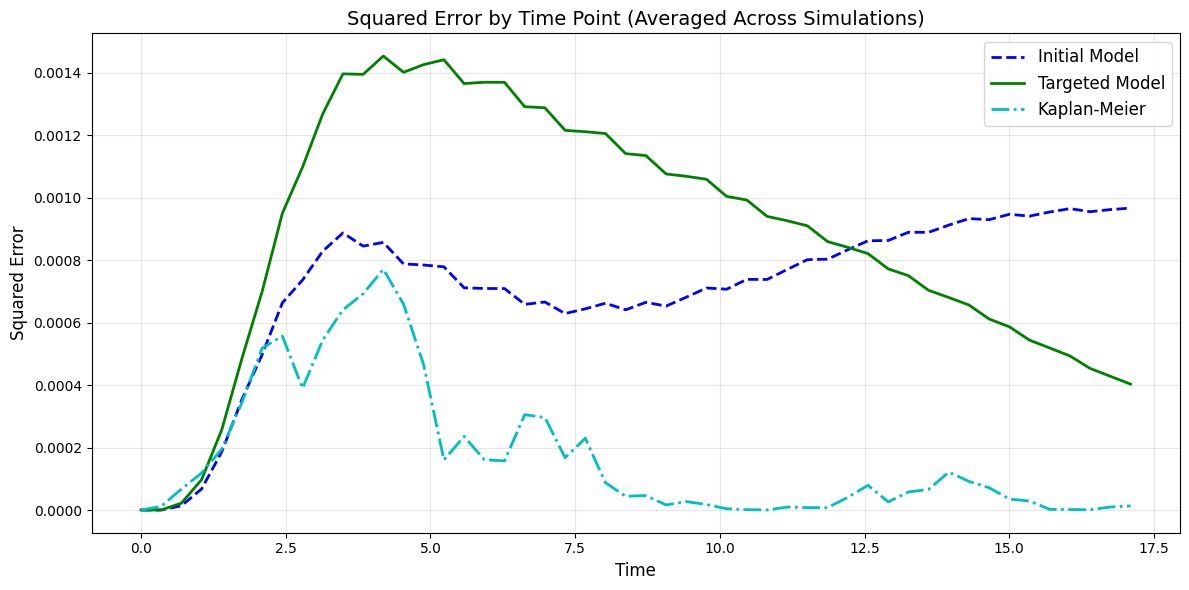

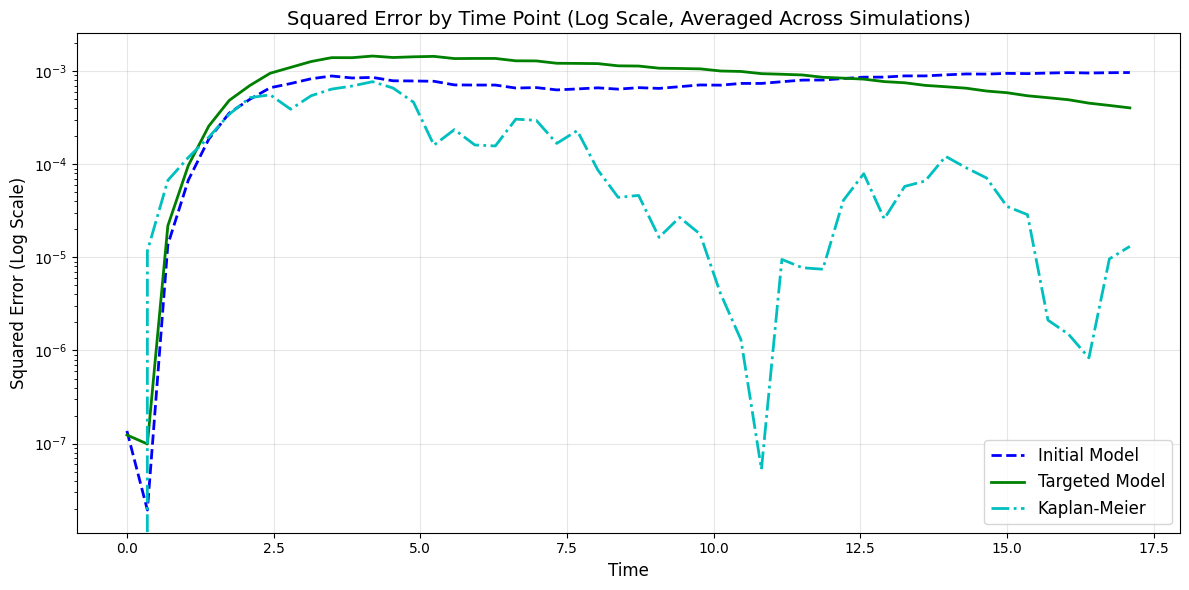

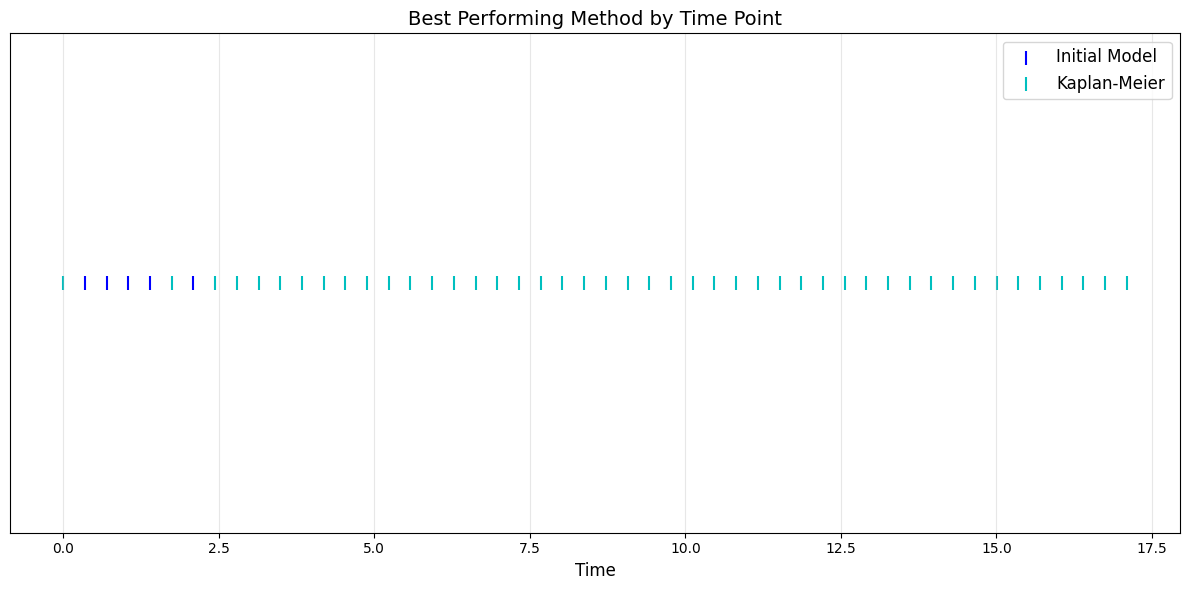

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the saved data from the results folder
results_dir = 'results'
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

# Check if the file exists
if not os.path.exists(survival_curves_file):
    raise FileNotFoundError(f"Could not find file: {survival_curves_file}. Make sure you've run the simulations.")

# Load the data
survival_data = pd.read_csv(survival_curves_file)

# Extract the necessary columns
time_points = survival_data['time']
true_survival = survival_data['true_survival']
initial_survival = survival_data['initial_survival']
targeted_survival = survival_data['targeted_survival']
km_survival = survival_data['km_survival']

# Calculate squared error at each time point
error_init = (initial_survival - true_survival)**2
error_targeted = (targeted_survival - true_survival)**2
error_km = (km_survival - true_survival)**2

# Create the plot
plt.figure(figsize=(12, 6))

# Plot squared errors
plt.plot(time_points, error_init, 'b--', linewidth=2, label='Initial Model')
plt.plot(time_points, error_targeted, 'g-', linewidth=2, label='Targeted Model')
plt.plot(time_points, error_km, 'c-.', linewidth=2, label='Kaplan-Meier')

# Add title and labels
plt.title('Squared Error by Time Point (Averaged Across Simulations)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Squared Error', fontsize=12)

# Customize the plot
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
output_path = os.path.join(results_dir, 'error_by_time_point.png')
plt.savefig(output_path, dpi=300)
print(f"Plot saved to {output_path}")

# Create a version with a log y-axis for better visualization of small differences
plt.figure(figsize=(12, 6))

# Plot squared errors with log scale
plt.semilogy(time_points, error_init, 'b--', linewidth=2, label='Initial Model')
plt.semilogy(time_points, error_targeted, 'g-', linewidth=2, label='Targeted Model')
plt.semilogy(time_points, error_km, 'c-.', linewidth=2, label='Kaplan-Meier')

# Add title and labels
plt.title('Squared Error by Time Point (Log Scale, Averaged Across Simulations)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Squared Error (Log Scale)', fontsize=12)

# Customize the plot
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
log_output_path = os.path.join(results_dir, 'error_by_time_point_log_scale.png')
plt.savefig(log_output_path, dpi=300)
print(f"Log-scale plot saved to {log_output_path}")

# Calculate average MSE for each method across all time points
avg_init_mse = np.mean(error_init)
avg_targeted_mse = np.mean(error_targeted)
avg_km_mse = np.mean(error_km)

print("\nAverage MSE across all time points:")
print(f"Initial Model: {avg_init_mse:.6f}")
print(f"Targeted Model: {avg_targeted_mse:.6f}")
print(f"Kaplan-Meier: {avg_km_mse:.6f}")

# Calculate relative improvement
init_improvement = (1 - avg_targeted_mse/avg_init_mse) * 100
km_improvement = (1 - avg_targeted_mse/avg_km_mse) * 100

print("\nRelative Improvement:")
print(f"Targeted vs Initial: {init_improvement:.2f}%")
print(f"Targeted vs Kaplan-Meier: {km_improvement:.2f}%")

# Identify time regions where each method performs best
best_method = np.argmin([error_init, error_targeted, error_km], axis=0)
method_names = ['Initial Model', 'Targeted Model', 'Kaplan-Meier']

print("\nTime regions where each method performs best:")
for i, method in enumerate(method_names):
    best_times = time_points[best_method == i]
    if len(best_times) > 0:
        print(f"{method}: {len(best_times)} time points, range: [{min(best_times):.2f}, {max(best_times):.2f}]")
    else:
        print(f"{method}: No time points where this method is best")

# Create a plot showing which method is best at each time point
plt.figure(figsize=(12, 6))
colors = ['b', 'g', 'c']
for i, method in enumerate(method_names):
    mask = best_method == i
    if np.any(mask):
        plt.scatter(time_points[mask], np.zeros_like(time_points[mask]), 
                   color=colors[i], label=method, s=100, marker='|')

plt.title('Best Performing Method by Time Point', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.yticks([])  # Remove y-axis ticks
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

# Save the figure
best_method_path = os.path.join(results_dir, 'best_method_by_time.png')
plt.savefig(best_method_path, dpi=300)
print(f"Best method plot saved to {best_method_path}")

Loaded data from 5 replications
Successfully parsed 5 replications
Shape of survival curves: (5, 50)
Boxplot saved to results/boxplot_errors_by_time.png
Log-scale boxplot saved to results/boxplot_errors_by_time_log_scale.png


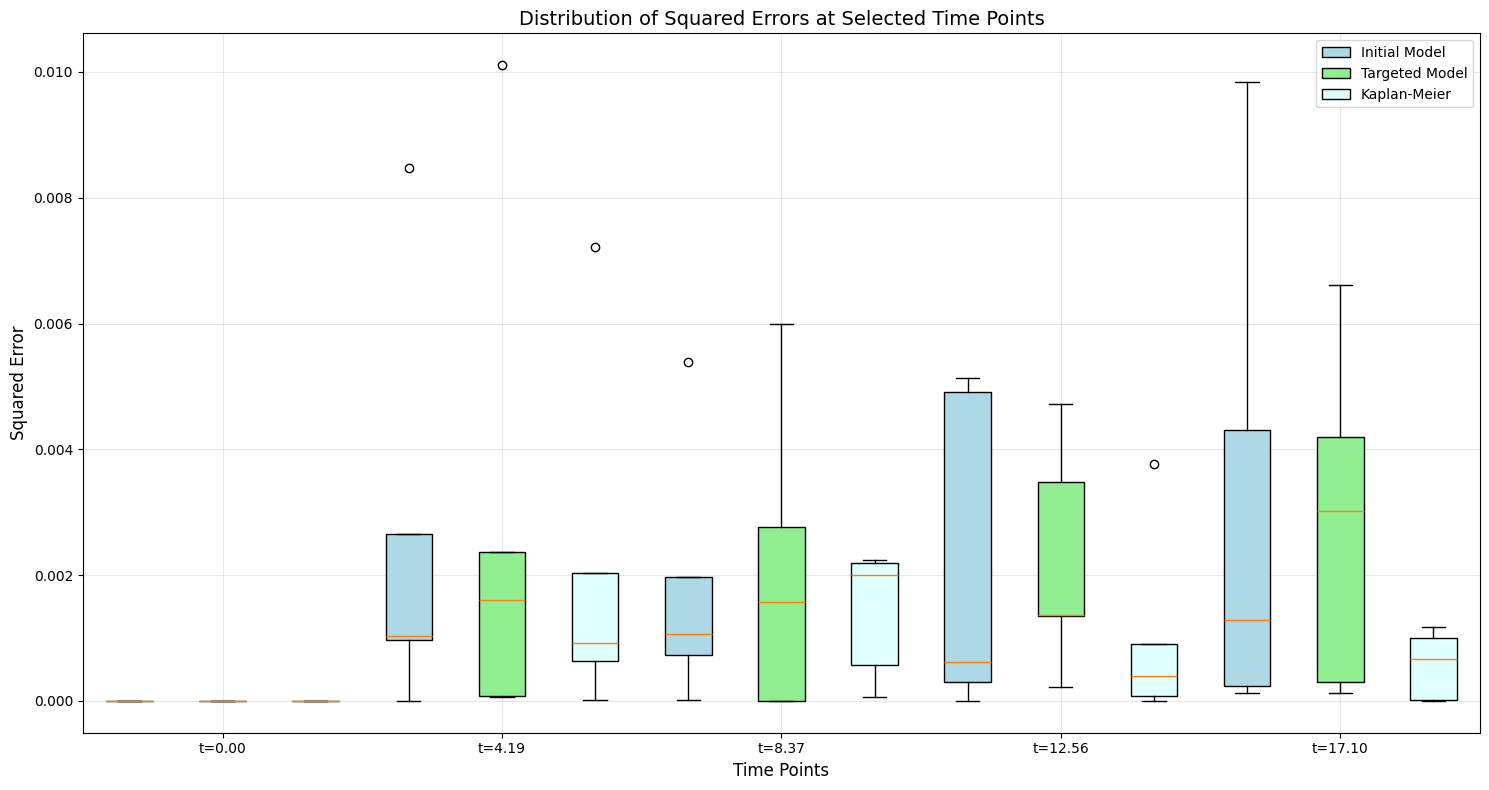

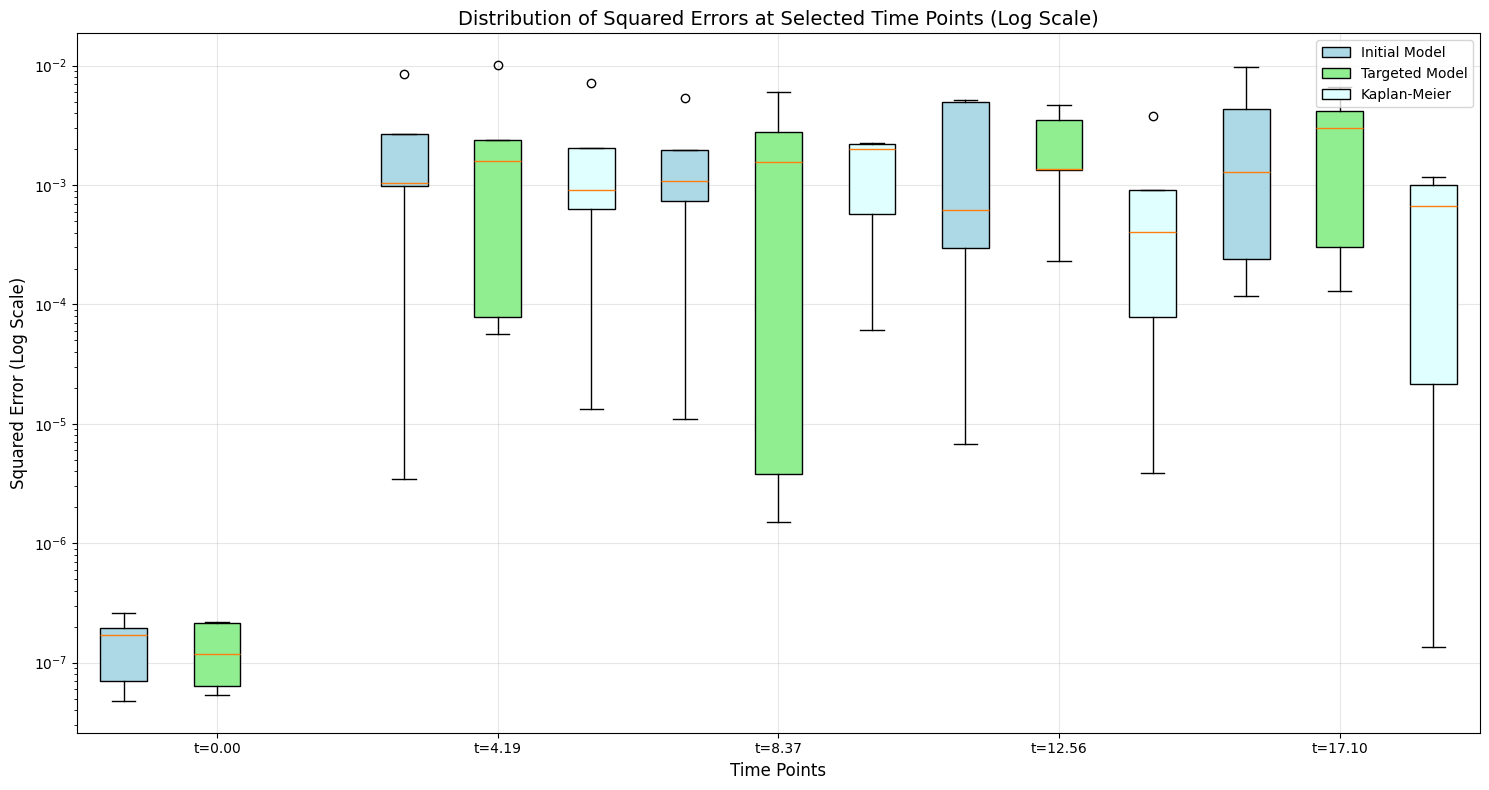

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Load all replication data
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')

if not os.path.exists(all_reps_file):
    raise FileNotFoundError(f"Could not find file: {all_reps_file}")

# Get the average data for reference
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')
if not os.path.exists(survival_curves_file):
    raise FileNotFoundError(f"Could not find file: {survival_curves_file}")

# Load average data to get time points
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values

# Load all replication data
reps_data = pd.read_csv(all_reps_file)

# Number of replications
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

for rep in range(n_reps):
    # Extract curves from each replication
    # Note: These are stored as columns in each row
    true_curve = np.array(reps_data.loc[rep, 'true_survival'].strip('[]').split(), dtype=float)
    if len(true_curve) == 0:  # Handle potential parsing issues
        # Try alternate format with commas
        true_curve = np.array([float(x) for x in reps_data.loc[rep, 'true_survival'].strip('[]').split(',')])
    
    initial_curve = np.array(reps_data.loc[rep, 'initial_survival'].strip('[]').split(), dtype=float)
    if len(initial_curve) == 0:
        initial_curve = np.array([float(x) for x in reps_data.loc[rep, 'initial_survival'].strip('[]').split(',')])
    
    targeted_curve = np.array(reps_data.loc[rep, 'targeted_survival'].strip('[]').split(), dtype=float)
    if len(targeted_curve) == 0:
        targeted_curve = np.array([float(x) for x in reps_data.loc[rep, 'targeted_survival'].strip('[]').split(',')])
    
    km_curve = np.array(reps_data.loc[rep, 'km_survival'].strip('[]').split(), dtype=float)
    if len(km_curve) == 0:
        km_curve = np.array([float(x) for x in reps_data.loc[rep, 'km_survival'].strip('[]').split(',')])
    
    # Only append if the parsing was successful
    if len(true_curve) > 0 and len(initial_curve) > 0 and len(targeted_curve) > 0 and len(km_curve) > 0:
        true_curves.append(true_curve)
        initial_curves.append(initial_curve)
        targeted_curves.append(targeted_curve)
        km_curves.append(km_curve)

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

print(f"Successfully parsed {len(true_curves)} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate squared errors at each time point for each replication
initial_errors = (initial_curves - true_curves)**2
targeted_errors = (targeted_curves - true_curves)**2
km_errors = (km_curves - true_curves)**2

# Select a subset of time points to visualize (e.g., 5 evenly spaced points)
n_timepoints = 5
selected_indices = np.linspace(0, len(time_points)-1, n_timepoints, dtype=int)
selected_times = time_points[selected_indices]

# Extract errors at selected time points
initial_selected = initial_errors[:, selected_indices]
targeted_selected = targeted_errors[:, selected_indices]
km_selected = km_errors[:, selected_indices]

# Create boxplots
plt.figure(figsize=(15, 8))

# Set positions for the boxes
positions = np.arange(1, n_timepoints*3+1, 3)

# Create boxplots
bp1 = plt.boxplot(initial_selected, positions=positions, patch_artist=True, 
                 boxprops=dict(facecolor='lightblue'), widths=0.5)
bp2 = plt.boxplot(targeted_selected, positions=positions+1, patch_artist=True, 
                 boxprops=dict(facecolor='lightgreen'), widths=0.5)
bp3 = plt.boxplot(km_selected, positions=positions+2, patch_artist=True, 
                 boxprops=dict(facecolor='lightcyan'), widths=0.5)

# Set x-ticks and labels
plt.xticks(positions+1, [f't={t:.2f}' for t in selected_times])
plt.xlabel('Time Points', fontsize=12)
plt.ylabel('Squared Error', fontsize=12)
plt.title('Distribution of Squared Errors at Selected Time Points', fontsize=14)

# Add a legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], 
           ['Initial Model', 'Targeted Model', 'Kaplan-Meier'], loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
output_path = os.path.join(results_dir, 'boxplot_errors_by_time.png')
plt.savefig(output_path, dpi=300)
print(f"Boxplot saved to {output_path}")

# Create a log-scale version for better visualization of small differences
plt.figure(figsize=(15, 8))
plt.yscale('log')

# Create boxplots for log scale
bp1 = plt.boxplot(initial_selected, positions=positions, patch_artist=True, 
                 boxprops=dict(facecolor='lightblue'), widths=0.5)
bp2 = plt.boxplot(targeted_selected, positions=positions+1, patch_artist=True, 
                 boxprops=dict(facecolor='lightgreen'), widths=0.5)
bp3 = plt.boxplot(km_selected, positions=positions+2, patch_artist=True, 
                 boxprops=dict(facecolor='lightcyan'), widths=0.5)

# Set x-ticks and labels
plt.xticks(positions+1, [f't={t:.2f}' for t in selected_times])
plt.xlabel('Time Points', fontsize=12)
plt.ylabel('Squared Error (Log Scale)', fontsize=12)
plt.title('Distribution of Squared Errors at Selected Time Points (Log Scale)', fontsize=14)

# Add a legend
plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], 
           ['Initial Model', 'Targeted Model', 'Kaplan-Meier'], loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
log_output_path = os.path.join(results_dir, 'boxplot_errors_by_time_log_scale.png')
plt.savefig(log_output_path, dpi=300)
print(f"Log-scale boxplot saved to {log_output_path}")

Loaded data from 5 replications
Successfully parsed 5 replications
Shape of survival curves: (5, 50)
Confidence bands plot saved to results/survival_curves_with_confidence_bands.png
Violin plot saved to results/violin_plot_errors.png
Log-scale violin plot saved to results/violin_plot_errors_log_scale.png
Heatmap saved to results/error_variation_heatmap.png
Performance comparison plot saved to results/targeted_performance_percentage.png


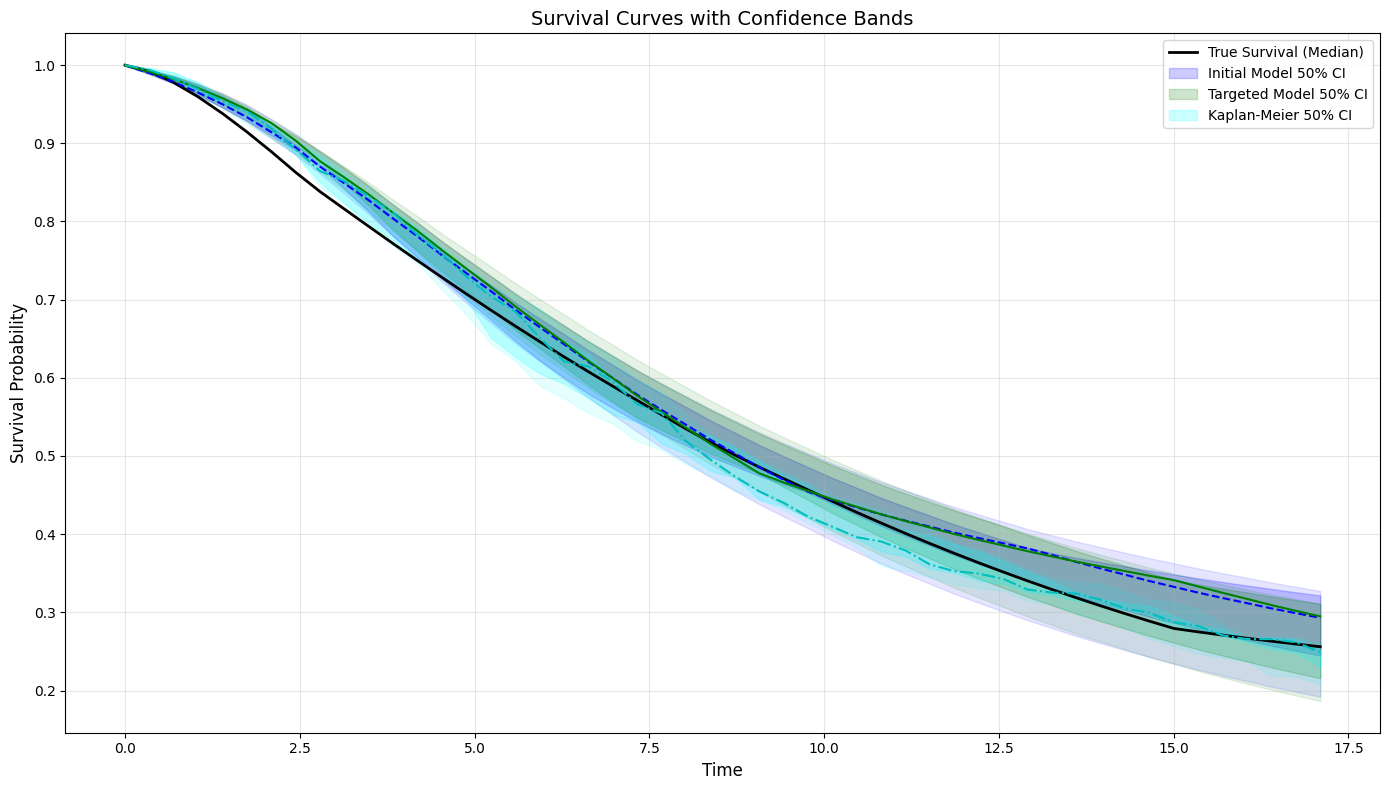

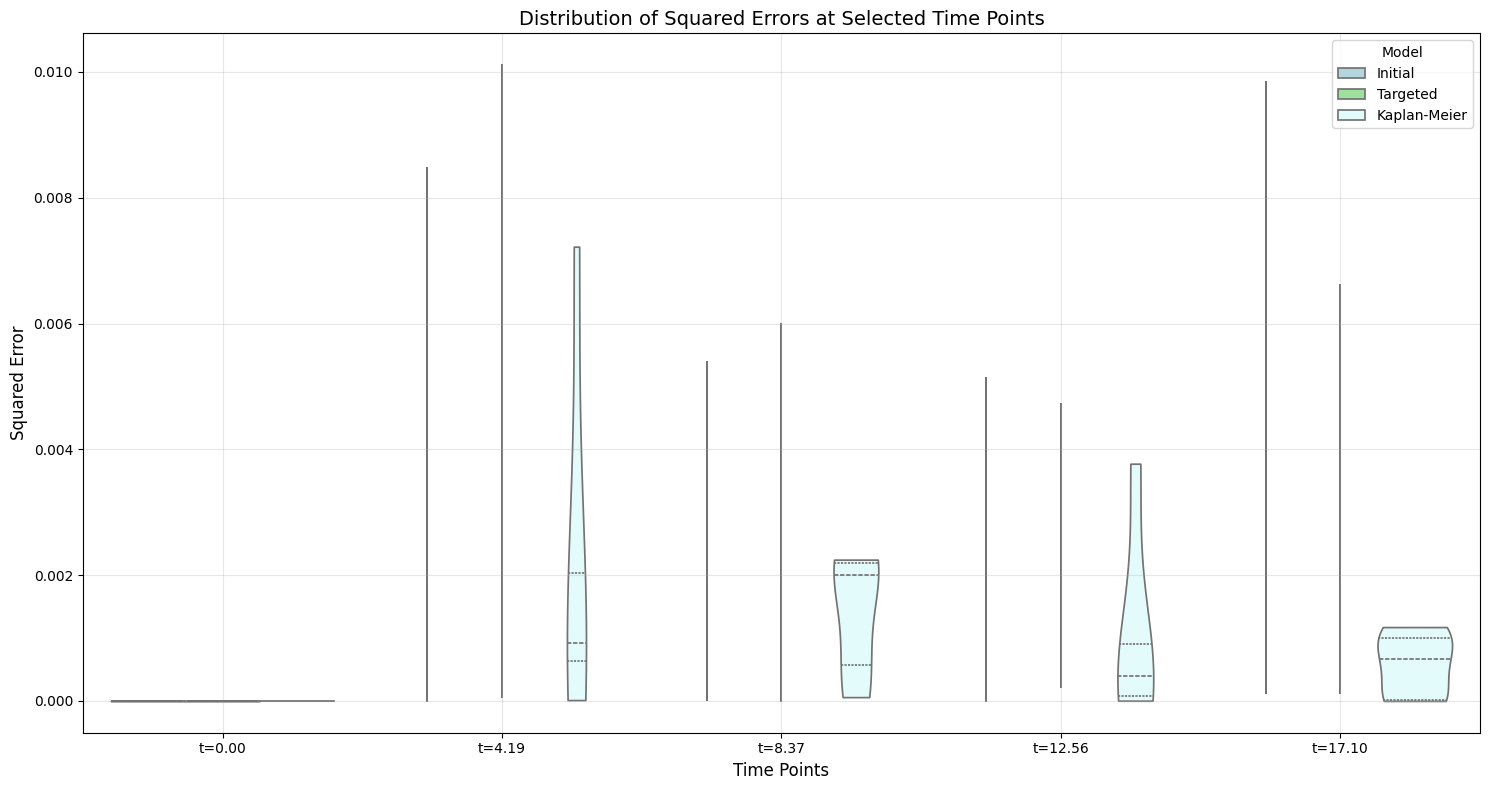

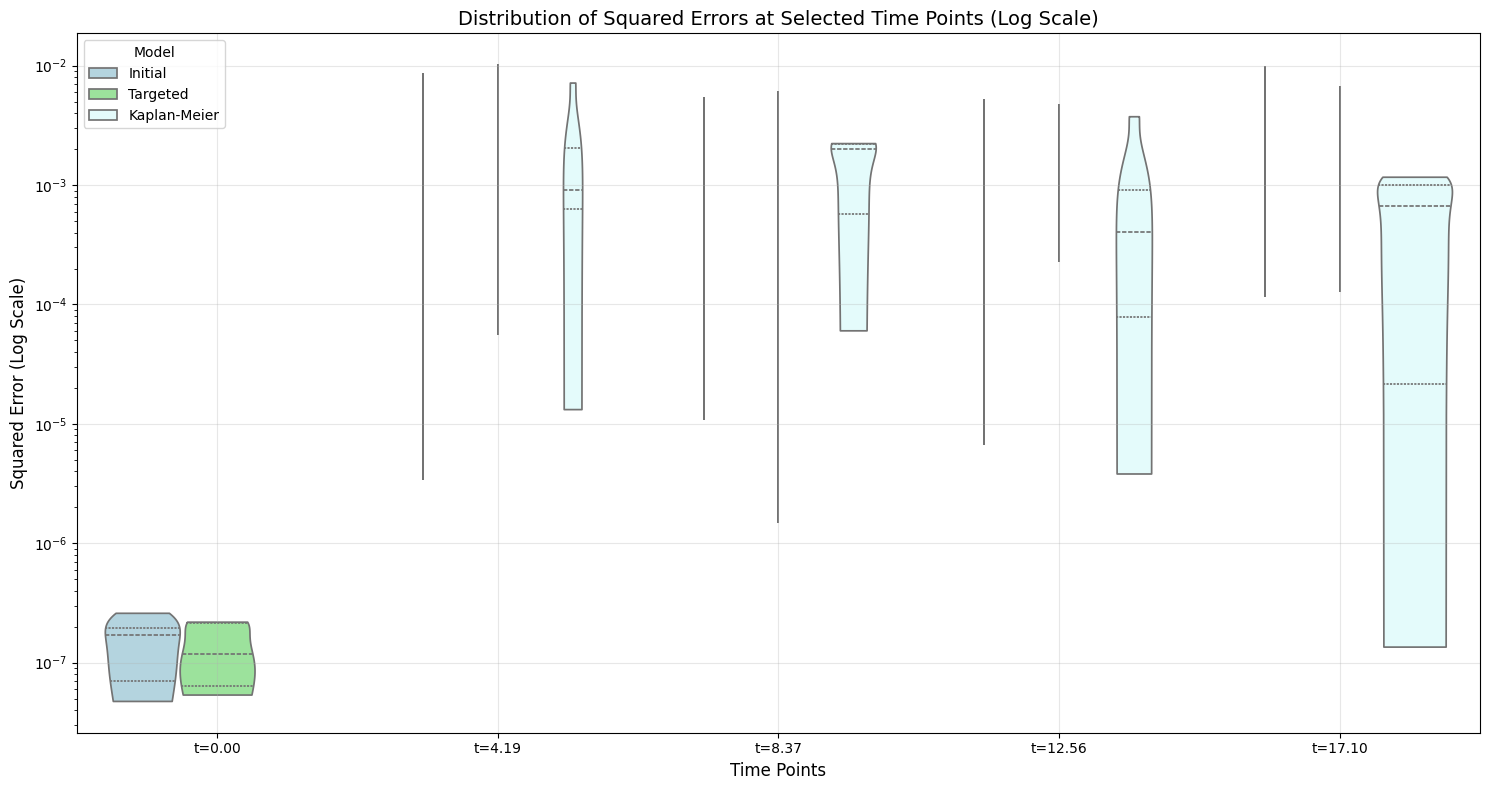

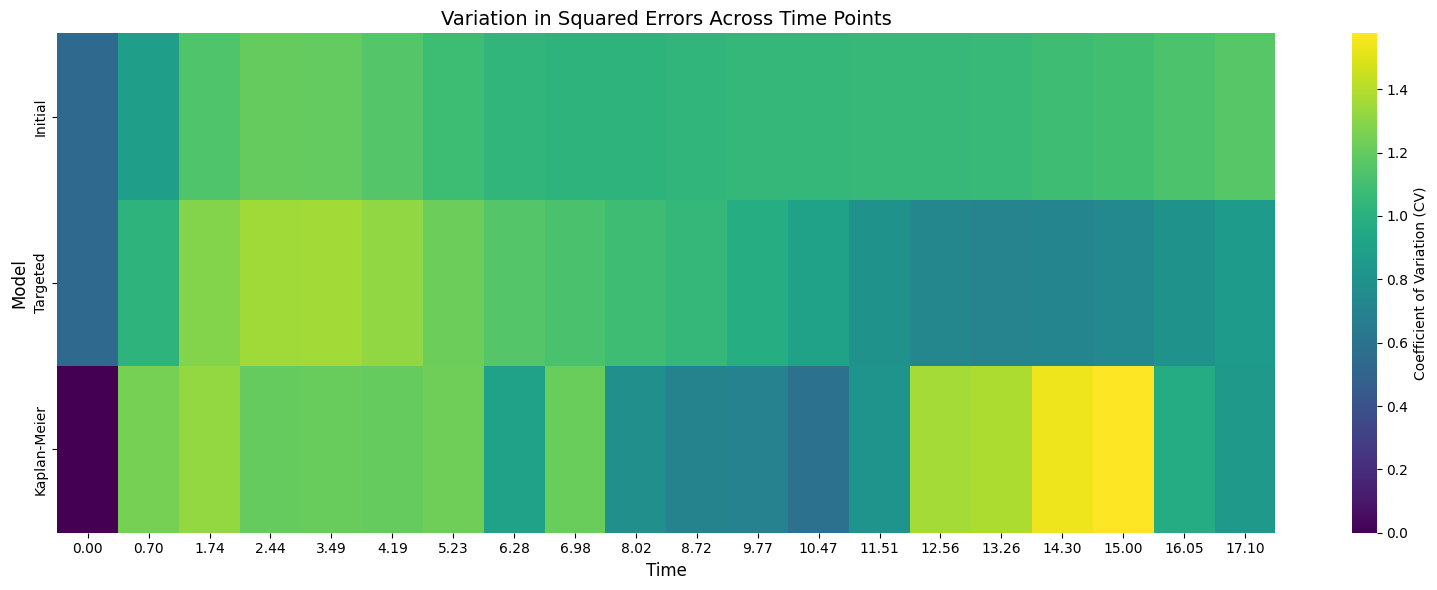

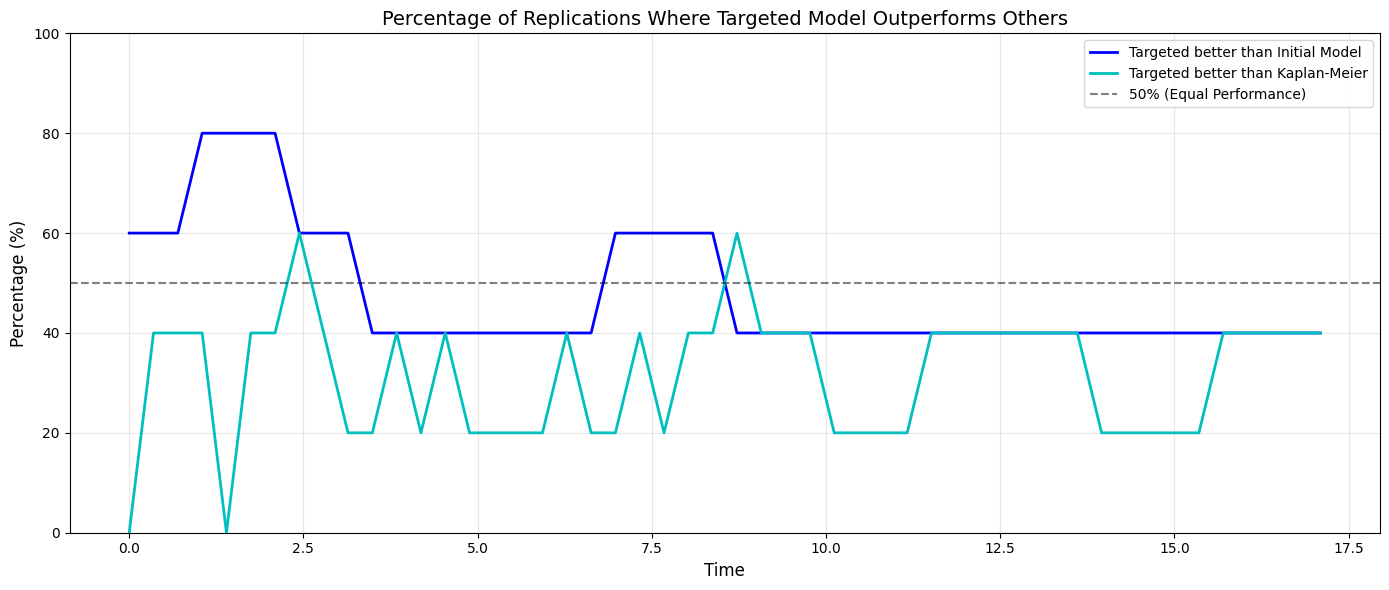

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats

# Load all replication data
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

if not os.path.exists(all_reps_file) or not os.path.exists(survival_curves_file):
    raise FileNotFoundError(f"Could not find required files in {results_dir}")

# Load average data to get time points
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values

# Function to parse array strings from CSV
def parse_array_string(array_str):
    try:
        # Try first format with spaces
        arr = np.array([float(x) for x in array_str.strip('[]').split()])
        if len(arr) == 0:
            # Try alternate format with commas
            arr = np.array([float(x) for x in array_str.strip('[]').split(',')])
        return arr
    except:
        print(f"Error parsing array: {array_str[:30]}...")
        return np.array([])

# Load all replication data
reps_data = pd.read_csv(all_reps_file)
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

# Process each replication
for i, row in reps_data.iterrows():
    try:
        # Extract curves - handling both list formats
        true_curve = parse_array_string(row['true_survival'])
        initial_curve = parse_array_string(row['initial_survival'])
        targeted_curve = parse_array_string(row['targeted_survival'])
        km_curve = parse_array_string(row['km_survival'])
        
        # Only append if all parsing was successful and lengths match
        if len(true_curve) > 0 and len(true_curve) == len(time_points):
            true_curves.append(true_curve)
            initial_curves.append(initial_curve)
            targeted_curves.append(targeted_curve)
            km_curves.append(km_curve)
    except Exception as e:
        print(f"Error processing replication {i}: {e}")

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

print(f"Successfully parsed {len(true_curves)} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate squared errors at each time point for each replication
initial_errors = (initial_curves - true_curves)**2
targeted_errors = (targeted_curves - true_curves)**2
km_errors = (km_curves - true_curves)**2

# 1. CONFIDENCE BANDS VISUALIZATION
# Calculate percentiles for all models at each time point
percentiles = [5, 25, 50, 75, 95]  # 5th, 25th, 50th (median), 75th, and 95th percentiles

initial_percentiles = np.percentile(initial_curves, percentiles, axis=0)
targeted_percentiles = np.percentile(targeted_curves, percentiles, axis=0)
km_percentiles = np.percentile(km_curves, percentiles, axis=0)
true_median = np.median(true_curves, axis=0)

# Plot confidence bands
plt.figure(figsize=(14, 8))

# True survival function
plt.plot(time_points, true_median, 'k-', linewidth=2, label='True Survival (Median)')

# Initial model with confidence bands
plt.fill_between(time_points, initial_percentiles[0], initial_percentiles[4], 
                 color='blue', alpha=0.1, label='Initial Model 90% CI')
plt.fill_between(time_points, initial_percentiles[1], initial_percentiles[3], 
                 color='blue', alpha=0.2, label='Initial Model 50% CI')
plt.plot(time_points, initial_percentiles[2], 'b--', linewidth=1.5, label='Initial Model (Median)')

# Targeted model with confidence bands
plt.fill_between(time_points, targeted_percentiles[0], targeted_percentiles[4], 
                 color='green', alpha=0.1, label='Targeted Model 90% CI')
plt.fill_between(time_points, targeted_percentiles[1], targeted_percentiles[3], 
                 color='green', alpha=0.2, label='Targeted Model 50% CI')
plt.plot(time_points, targeted_percentiles[2], 'g-', linewidth=1.5, label='Targeted Model (Median)')

# Kaplan-Meier with confidence bands
plt.fill_between(time_points, km_percentiles[0], km_percentiles[4], 
                 color='cyan', alpha=0.1, label='Kaplan-Meier 90% CI')
plt.fill_between(time_points, km_percentiles[1], km_percentiles[3], 
                 color='cyan', alpha=0.2, label='Kaplan-Meier 50% CI')
plt.plot(time_points, km_percentiles[2], 'c-.', linewidth=1.5, label='Kaplan-Meier (Median)')

# Customize the plot
plt.title('Survival Curves with Confidence Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.grid(True, alpha=0.3)

# Create a custom legend with fewer items
handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[0]]  # True Survival
for i in range(2, len(handles), 3):  # Take only the median lines for each method
    selected_handles.append(handles[i])

selected_labels = [labels[0]]
for i in range(2, len(labels), 3):
    selected_labels.append(labels[i])

plt.legend(selected_handles, selected_labels, fontsize=10, loc='upper right')
plt.tight_layout()

# Save the figure
output_path = os.path.join(results_dir, 'survival_curves_with_confidence_bands.png')
plt.savefig(output_path, dpi=300)
print(f"Confidence bands plot saved to {output_path}")

# 2. VIOLIN PLOTS OF ERRORS AT SELECTED TIME POINTS
# Select a subset of time points to visualize
n_timepoints = 5
selected_indices = np.linspace(0, len(time_points)-1, n_timepoints, dtype=int)
selected_times = time_points[selected_indices]

# Prepare data for violin plots
model_names = []
time_labels = []
errors = []

for i, idx in enumerate(selected_indices):
    time_label = f"t={selected_times[i]:.2f}"
    
    # Add initial model data
    model_names.extend(['Initial'] * len(initial_errors))
    time_labels.extend([time_label] * len(initial_errors))
    errors.extend(initial_errors[:, idx])
    
    # Add targeted model data
    model_names.extend(['Targeted'] * len(targeted_errors))
    time_labels.extend([time_label] * len(targeted_errors))
    errors.extend(targeted_errors[:, idx])
    
    # Add KM model data
    model_names.extend(['Kaplan-Meier'] * len(km_errors))
    time_labels.extend([time_label] * len(km_errors))
    errors.extend(km_errors[:, idx])

# Create a DataFrame for seaborn
violin_df = pd.DataFrame({
    'Model': model_names,
    'Time': time_labels,
    'Squared Error': errors
})

# Create violin plots
plt.figure(figsize=(15, 8))
sns.violinplot(x='Time', y='Squared Error', hue='Model', data=violin_df, 
               palette={'Initial': 'lightblue', 'Targeted': 'lightgreen', 'Kaplan-Meier': 'lightcyan'},
               split=False, inner='quartile', cut=0)

plt.title('Distribution of Squared Errors at Selected Time Points', fontsize=14)
plt.xlabel('Time Points', fontsize=12)
plt.ylabel('Squared Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()

# Save the figure
violin_path = os.path.join(results_dir, 'violin_plot_errors.png')
plt.savefig(violin_path, dpi=300)
print(f"Violin plot saved to {violin_path}")

# Create a log-scale version
plt.figure(figsize=(15, 8))
sns.violinplot(x='Time', y='Squared Error', hue='Model', data=violin_df, 
               palette={'Initial': 'lightblue', 'Targeted': 'lightgreen', 'Kaplan-Meier': 'lightcyan'},
               split=False, inner='quartile', cut=0)
plt.yscale('log')
plt.title('Distribution of Squared Errors at Selected Time Points (Log Scale)', fontsize=14)
plt.xlabel('Time Points', fontsize=12)
plt.ylabel('Squared Error (Log Scale)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()

# Save the log-scale figure
log_violin_path = os.path.join(results_dir, 'violin_plot_errors_log_scale.png')
plt.savefig(log_violin_path, dpi=300)
print(f"Log-scale violin plot saved to {log_violin_path}")

# 3. HEATMAP OF ERROR VARIATIONS ACROSS TIME
# Calculate statistics for errors at each time point
def calculate_error_stats(errors):
    mean_errors = np.mean(errors, axis=0)
    median_errors = np.median(errors, axis=0)
    std_errors = np.std(errors, axis=0)
    cv_errors = std_errors / (mean_errors + 1e-10)  # Coefficient of variation (add small constant to avoid div by 0)
    return mean_errors, median_errors, std_errors, cv_errors

# Calculate statistics for all models
initial_mean, initial_median, initial_std, initial_cv = calculate_error_stats(initial_errors)
targeted_mean, targeted_median, targeted_std, targeted_cv = calculate_error_stats(targeted_errors)
km_mean, km_median, km_std, km_cv = calculate_error_stats(km_errors)

# Create heatmap data - Coefficient of Variation (higher means more relative variation)
cv_data = np.vstack([initial_cv, targeted_cv, km_cv])

# Select a subset of time points for better visualization
n_time_display = min(20, len(time_points))
time_indices = np.linspace(0, len(time_points)-1, n_time_display, dtype=int)

plt.figure(figsize=(16, 6))
sns.heatmap(cv_data[:, time_indices], 
            cmap='viridis',
            yticklabels=['Initial', 'Targeted', 'Kaplan-Meier'],
            xticklabels=[f"{time_points[i]:.2f}" for i in time_indices],
            cbar_kws={'label': 'Coefficient of Variation (CV)'})
plt.title('Variation in Squared Errors Across Time Points', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()

# Save the figure
heatmap_path = os.path.join(results_dir, 'error_variation_heatmap.png')
plt.savefig(heatmap_path, dpi=300)
print(f"Heatmap saved to {heatmap_path}")

# 4. RELATIVE PERFORMANCE METRIC: TARGETED vs OTHERS
# Calculate the proportion of replications where targeted model outperforms others
better_than_initial = (targeted_errors < initial_errors).mean(axis=0) * 100
better_than_km = (targeted_errors < km_errors).mean(axis=0) * 100

plt.figure(figsize=(14, 6))
plt.plot(time_points, better_than_initial, 'b-', linewidth=2, 
         label='Targeted better than Initial Model')
plt.plot(time_points, better_than_km, 'c-', linewidth=2, 
         label='Targeted better than Kaplan-Meier')
plt.axhline(y=50, color='k', linestyle='--', alpha=0.5, 
            label='50% (Equal Performance)')
plt.title('Percentage of Replications Where Targeted Model Outperforms Others', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure
perf_path = os.path.join(results_dir, 'targeted_performance_percentage.png')
plt.savefig(perf_path, dpi=300)
print(f"Performance comparison plot saved to {perf_path}")

Loaded data from 5 replications
Successfully parsed 5 replications
Shape of survival curves: (5, 50)
Error bands plot saved to results/mse_with_confidence_bands.png
Log-scale error bands plot saved to results/mse_with_confidence_bands_log_scale.png


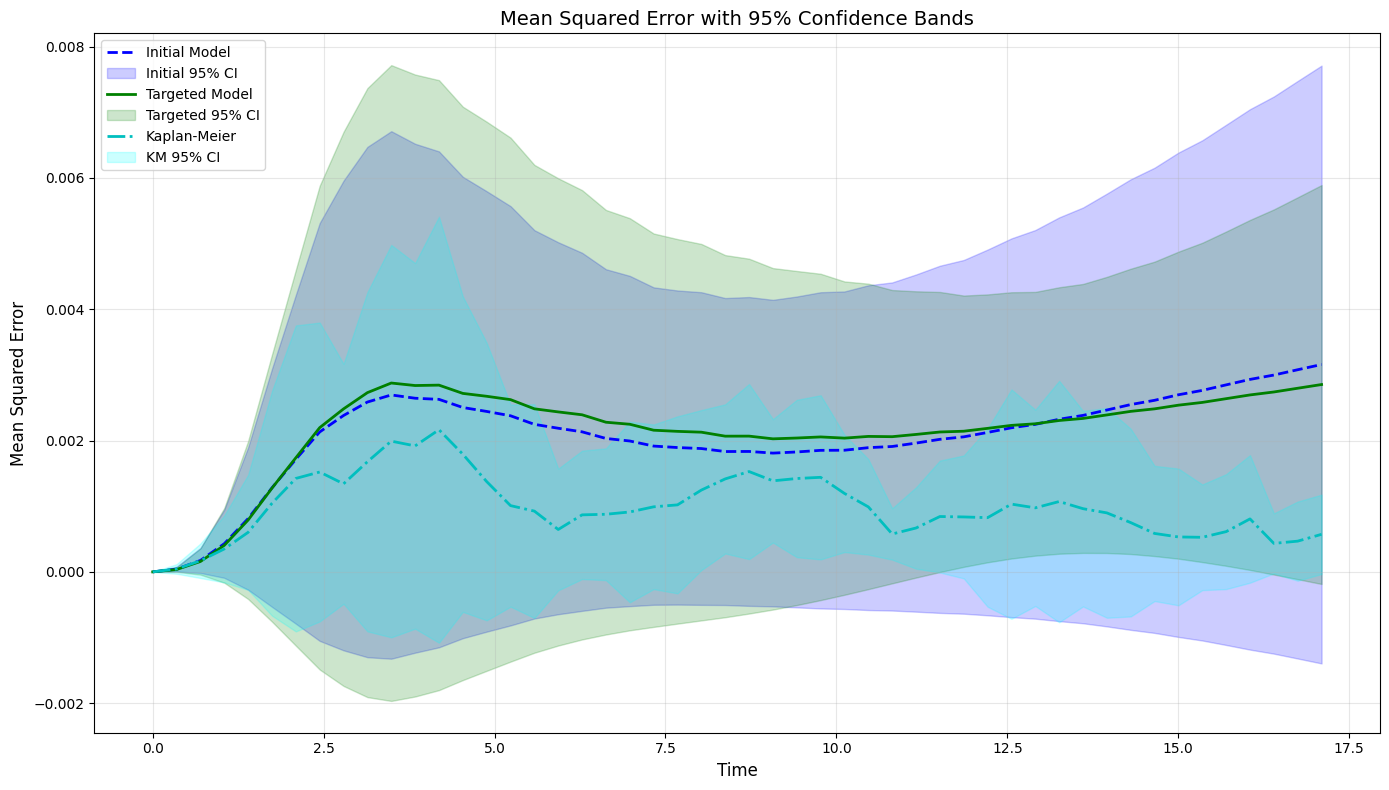

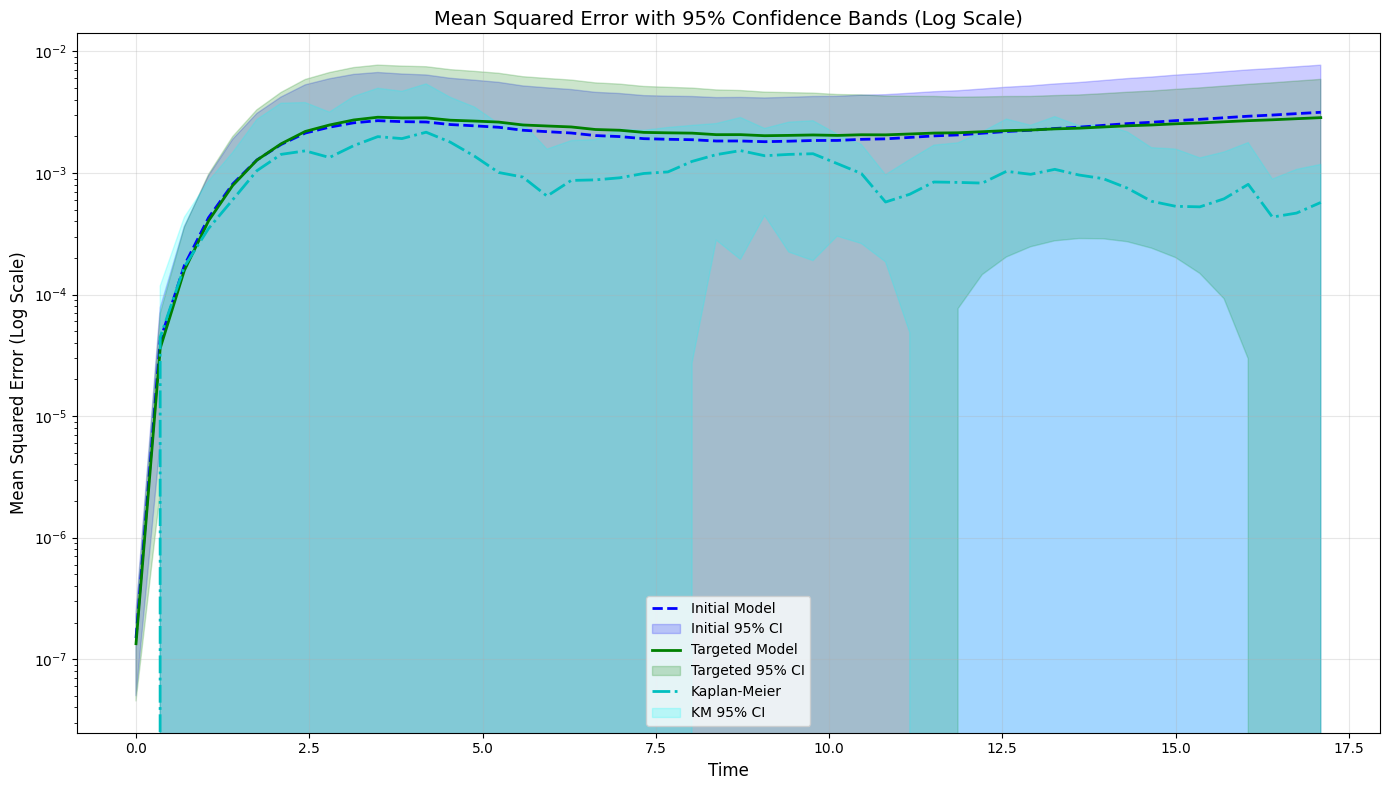

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load all replication data
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

if not os.path.exists(all_reps_file) or not os.path.exists(survival_curves_file):
    raise FileNotFoundError(f"Could not find required files in {results_dir}")

# Load average data to get time points
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values

# Function to parse array strings from CSV
def parse_array_string(array_str):
    try:
        # Try first format with spaces
        arr = np.array([float(x) for x in array_str.strip('[]').split()])
        if len(arr) == 0:
            # Try alternate format with commas
            arr = np.array([float(x) for x in array_str.strip('[]').split(',')])
        return arr
    except:
        print(f"Error parsing array: {array_str[:30]}...")
        return np.array([])

# Load all replication data
reps_data = pd.read_csv(all_reps_file)
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

# Process each replication
for i, row in reps_data.iterrows():
    try:
        # Extract curves - handling both list formats
        true_curve = parse_array_string(row['true_survival'])
        initial_curve = parse_array_string(row['initial_survival'])
        targeted_curve = parse_array_string(row['targeted_survival'])
        km_curve = parse_array_string(row['km_survival'])
        
        # Only append if all parsing was successful and lengths match
        if len(true_curve) > 0 and len(true_curve) == len(time_points):
            true_curves.append(true_curve)
            initial_curves.append(initial_curve)
            targeted_curves.append(targeted_curve)
            km_curves.append(km_curve)
    except Exception as e:
        print(f"Error processing replication {i}: {e}")

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

print(f"Successfully parsed {len(true_curves)} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate squared errors at each time point for each replication
initial_errors = (initial_curves - true_curves)**2
targeted_errors = (targeted_curves - true_curves)**2
km_errors = (km_curves - true_curves)**2

# 1. ERROR BANDS ACROSS TIME
# Calculate mean and confidence intervals for errors
def calculate_error_bands(errors, alpha=0.05):
    """Calculate mean errors with confidence intervals"""
    mean_errors = np.mean(errors, axis=0)
    std_errors = np.std(errors, axis=0)
    n = errors.shape[0]
    # Calculate confidence interval using t-distribution
    t_val = stats.t.ppf(1 - alpha/2, n-1)
    margin = t_val * std_errors / np.sqrt(n)
    lower_bound = mean_errors - margin
    upper_bound = mean_errors + margin
    return mean_errors, lower_bound, upper_bound

# Calculate error bands for all methods
initial_mean, initial_lower, initial_upper = calculate_error_bands(initial_errors)
targeted_mean, targeted_lower, targeted_upper = calculate_error_bands(targeted_errors)
km_mean, km_lower, km_upper = calculate_error_bands(km_errors)

# Plot error bands
plt.figure(figsize=(14, 8))

# Initial model
plt.plot(time_points, initial_mean, 'b--', linewidth=2, label='Initial Model')
plt.fill_between(time_points, initial_lower, initial_upper, 
                 color='blue', alpha=0.2, label='Initial 95% CI')

# Targeted model
plt.plot(time_points, targeted_mean, 'g-', linewidth=2, label='Targeted Model')
plt.fill_between(time_points, targeted_lower, targeted_upper, 
                 color='green', alpha=0.2, label='Targeted 95% CI')

# Kaplan-Meier
plt.plot(time_points, km_mean, 'c-.', linewidth=2, label='Kaplan-Meier')
plt.fill_between(time_points, km_lower, km_upper, 
                 color='cyan', alpha=0.2, label='KM 95% CI')

plt.title('Mean Squared Error with 95% Confidence Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure
error_bands_path = os.path.join(results_dir, 'mse_with_confidence_bands.png')
plt.savefig(error_bands_path, dpi=300)
print(f"Error bands plot saved to {error_bands_path}")

# 2. LOG SCALE VERSION
plt.figure(figsize=(14, 8))

# Initial model
plt.semilogy(time_points, initial_mean, 'b--', linewidth=2, label='Initial Model')
plt.fill_between(time_points, initial_lower, initial_upper, 
                 color='blue', alpha=0.2, label='Initial 95% CI')

# Targeted model
plt.semilogy(time_points, targeted_mean, 'g-', linewidth=2, label='Targeted Model')
plt.fill_between(time_points, targeted_lower, targeted_upper, 
                 color='green', alpha=0.2, label='Targeted 95% CI')

# Kaplan-Meier
plt.semilogy(time_points, km_mean, 'c-.', linewidth=2, label='Kaplan-Meier')
plt.fill_between(time_points, km_lower, km_upper, 
                 color='cyan', alpha=0.2, label='KM 95% CI')

plt.title('Mean Squared Error with 95% Confidence Bands (Log Scale)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Mean Squared Error (Log Scale)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()

# Save the figure
log_error_bands_path = os.path.join(results_dir, 'mse_with_confidence_bands_log_scale.png')
plt.savefig(log_error_bands_path, dpi=300)
print(f"Log-scale error bands plot saved to {log_error_bands_path}")



Loaded data from 10 replications
Successfully parsed 10 replications
Shape of survival curves: (10, 50)
Plot saved to results/survival_curves_with_percentile_bands.png
Initial Model plot saved to results/initial_model_percentile_bands.png
Targeted Model plot saved to results/targeted_model_percentile_bands.png
Kaplan-Meier plot saved to results/kaplan-meier_percentile_bands.png
Log-scale plot saved to results/survival_curves_with_percentile_bands_log_scale.png
MSE plot saved to results/mse_with_percentile_bands.png
Log-scale MSE plot saved to results/mse_with_percentile_bands_log_scale.png


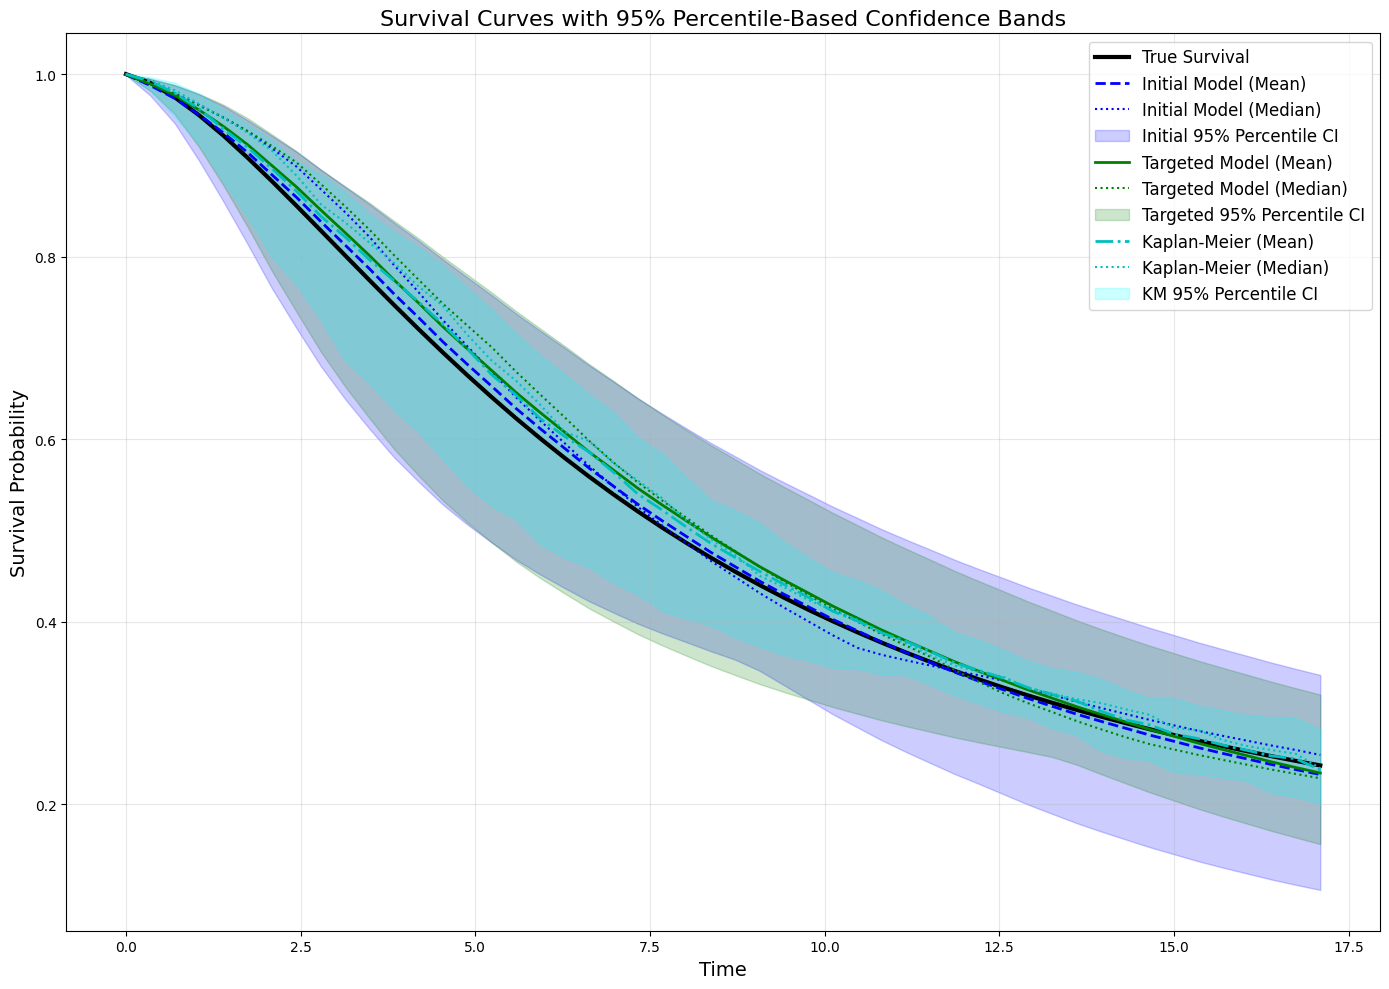

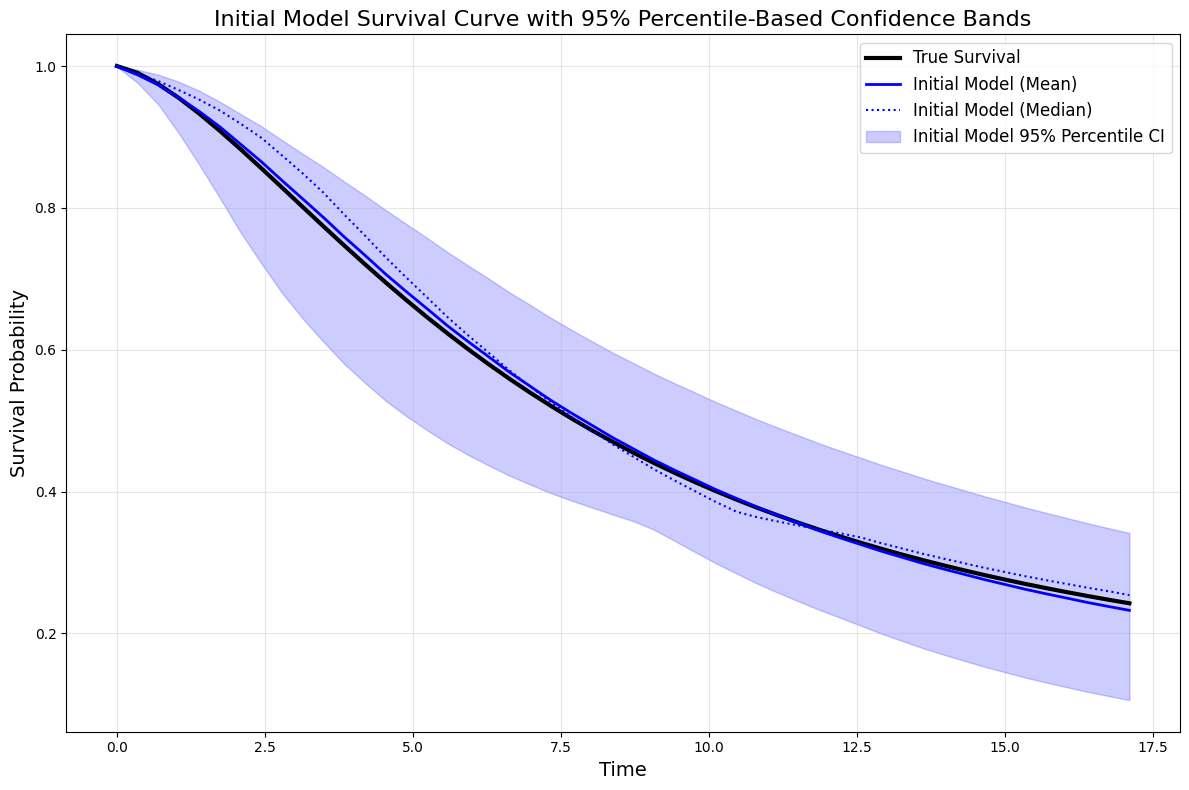

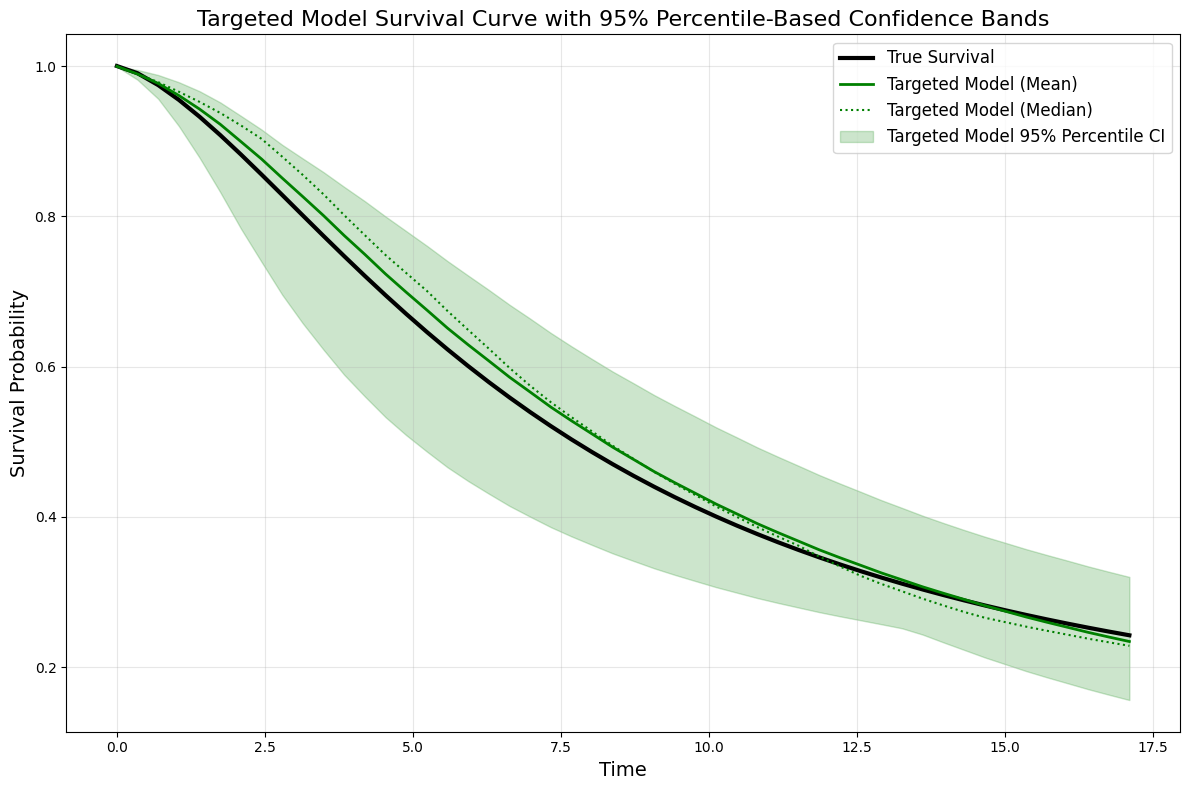

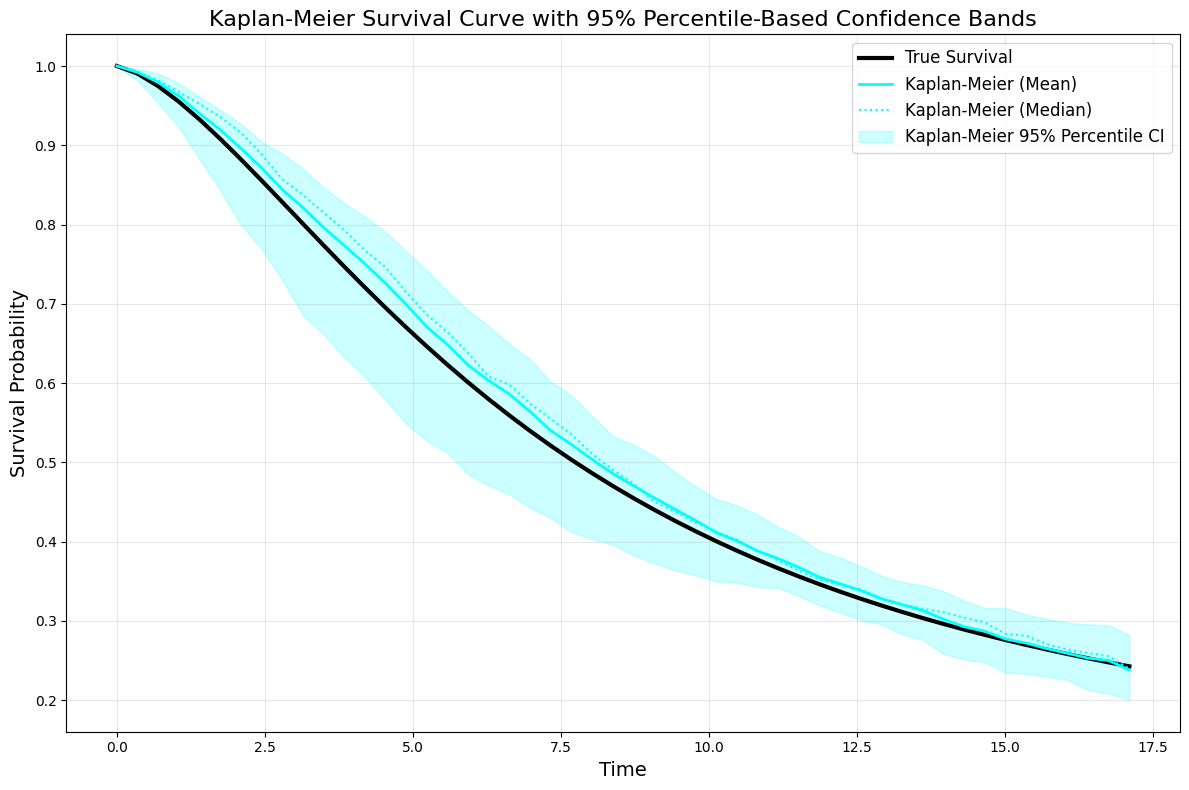

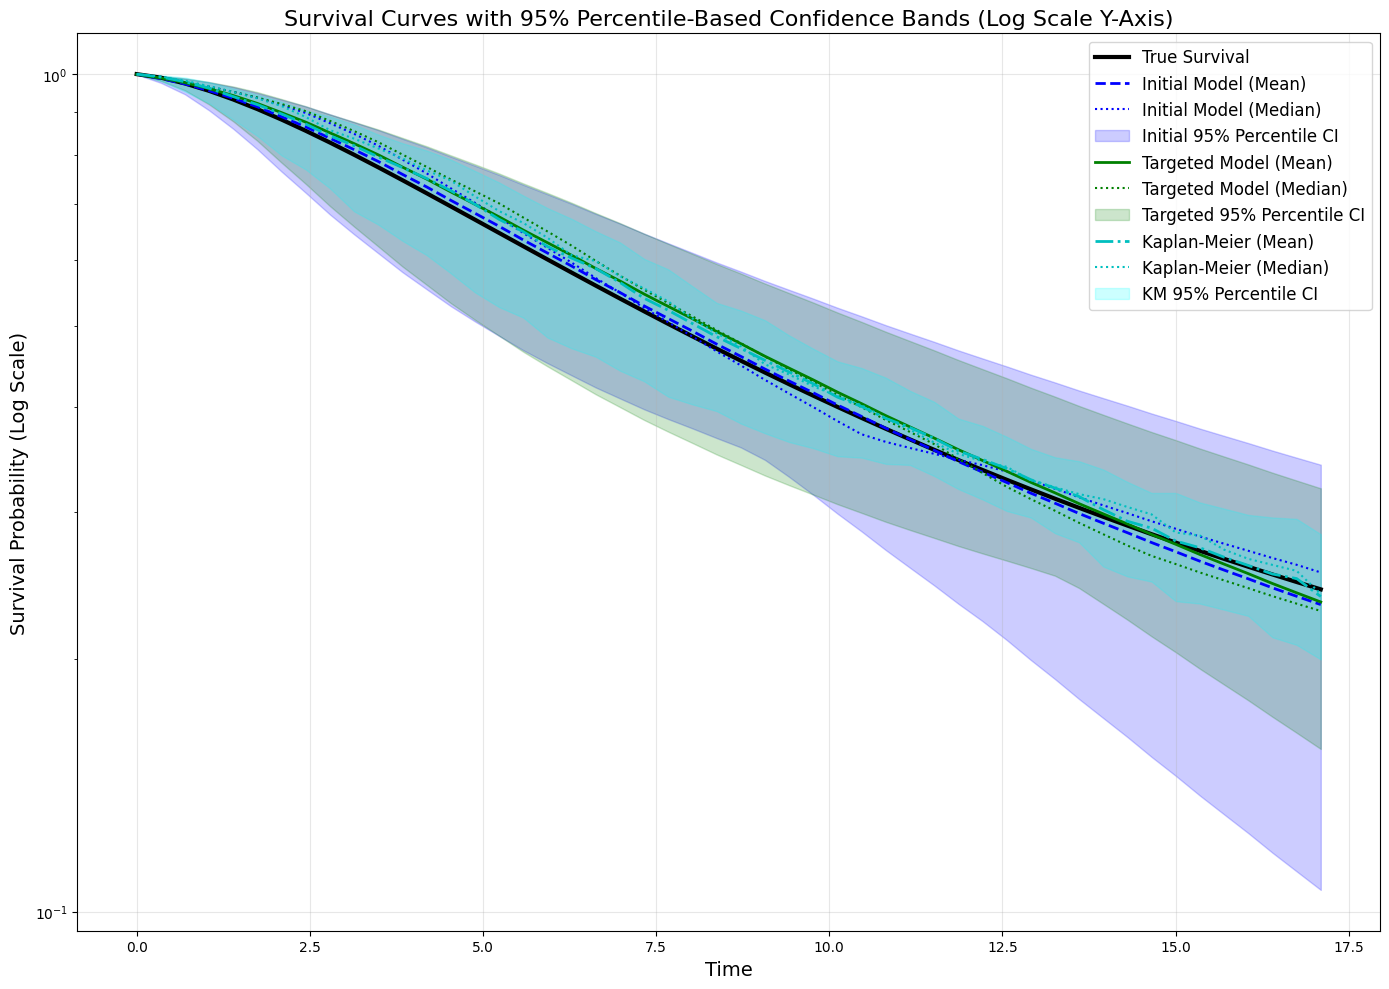

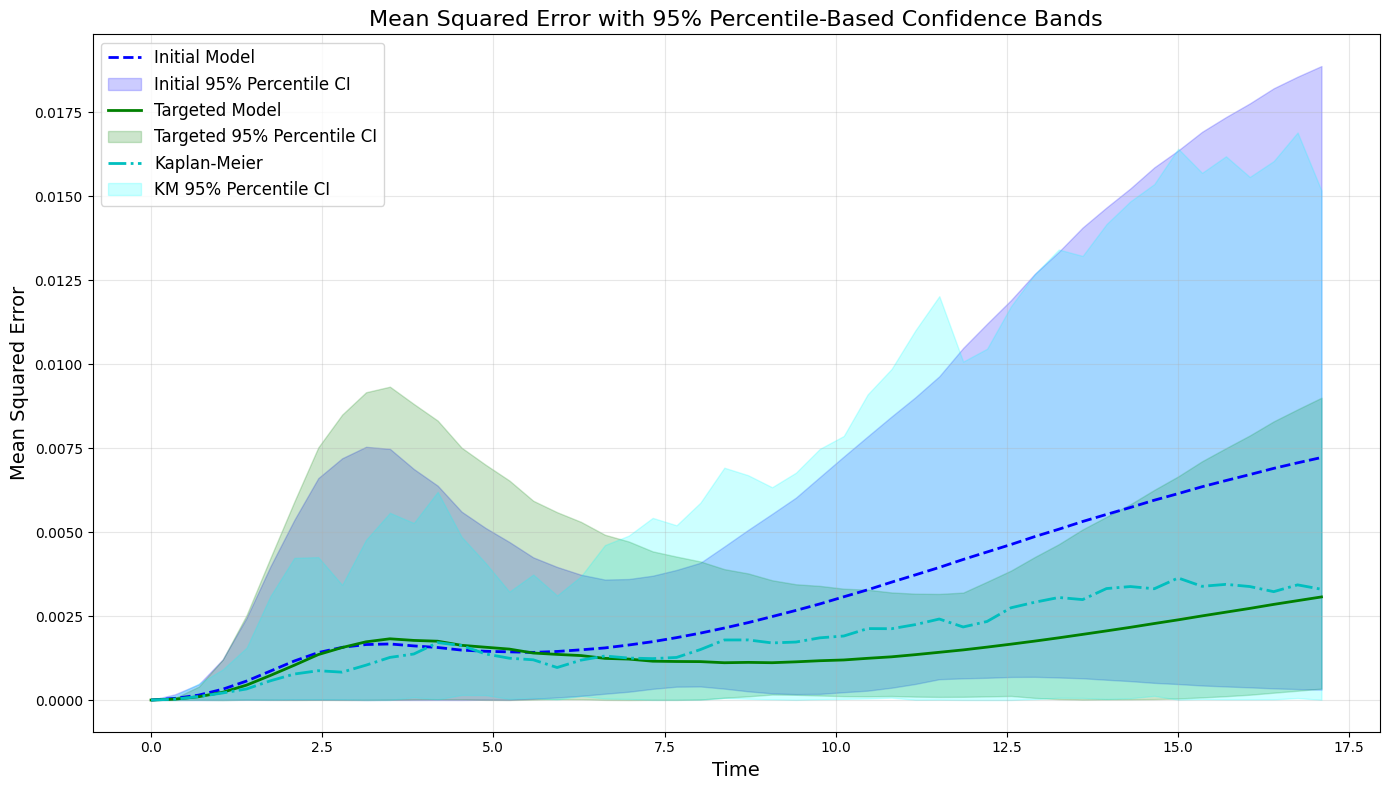

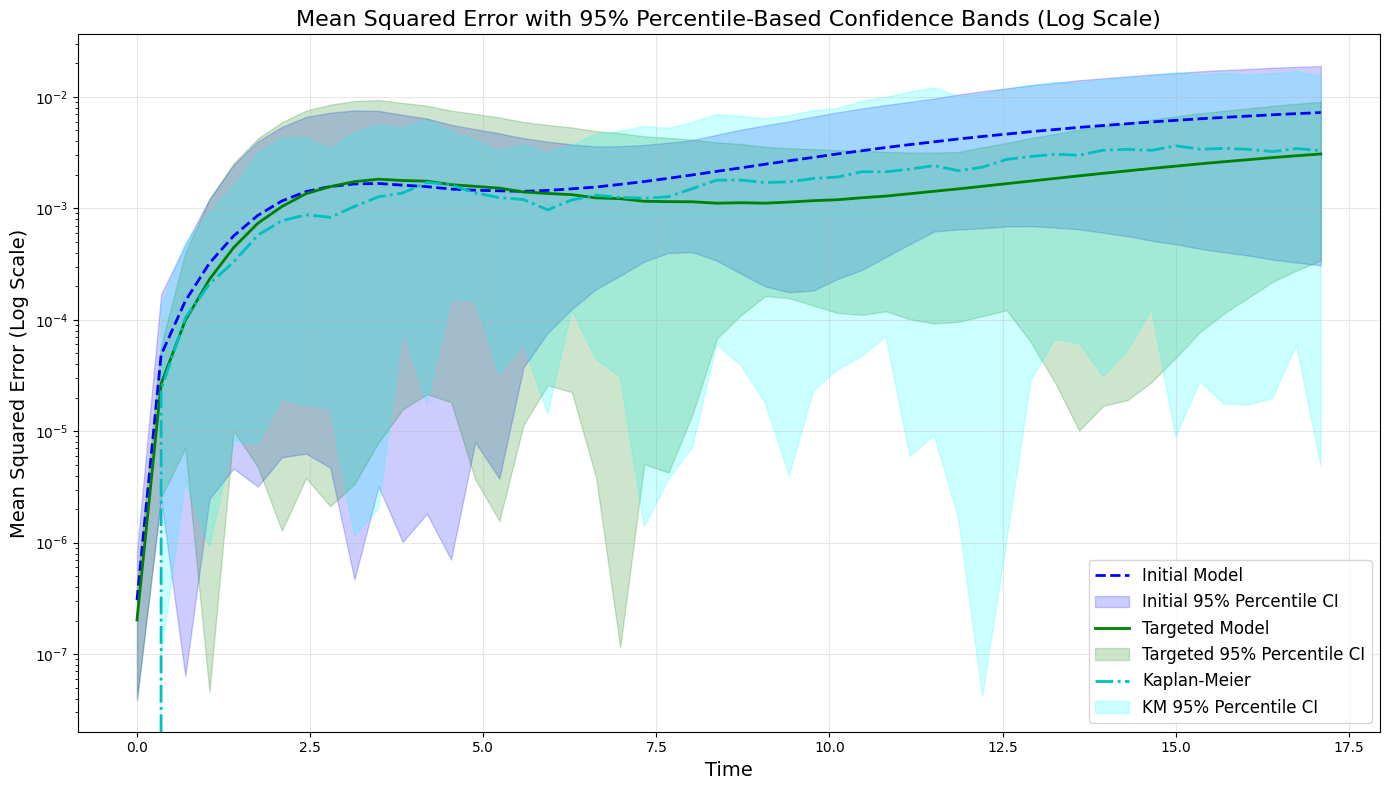

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Function to calculate percentile bands
def calculate_percentile_bands(errors, alpha=0.05):
    """Calculate mean errors with percentile-based confidence bands"""
    mean_errors = np.mean(errors, axis=0)
    
    # Calculate percentile confidence intervals
    # Use 2.5th and 97.5th percentiles for 95% confidence interval
    lower_percentile = alpha/2 * 100
    upper_percentile = (1 - alpha/2) * 100
    
    lower_bound = np.percentile(errors, lower_percentile, axis=0)
    upper_bound = np.percentile(errors, upper_percentile, axis=0)
    median = np.median(errors, axis=0)
    
    return mean_errors, median, lower_bound, upper_bound

# Load the simulation results
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

# Load average survival curves data (contains time points and true survival)
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values
true_survival = avg_data['true_survival'].values

# Function to parse array strings from CSV
def parse_array_string(array_str):
    try:
        # Try first format with spaces
        arr = np.array([float(x) for x in array_str.strip('[]').split()])
        if len(arr) == 0:
            # Try alternate format with commas
            arr = np.array([float(x) for x in array_str.strip('[]').split(',')])
        return arr
    except:
        print(f"Error parsing array: {array_str[:30]}...")
        return np.array([])

# Load all replication data
reps_data = pd.read_csv(all_reps_file)
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

# Process each replication
for i, row in reps_data.iterrows():
    try:
        # Extract curves
        true_curve = parse_array_string(row['true_survival'])
        initial_curve = parse_array_string(row['initial_survival'])
        targeted_curve = parse_array_string(row['targeted_survival'])
        km_curve = parse_array_string(row['km_survival'])
        
        # Only append if all parsing was successful and lengths match
        if len(true_curve) > 0 and len(true_curve) == len(time_points):
            true_curves.append(true_curve)
            initial_curves.append(initial_curve)
            targeted_curves.append(targeted_curve)
            km_curves.append(km_curve)
    except Exception as e:
        print(f"Error processing replication {i}: {e}")

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

print(f"Successfully parsed {len(true_curves)} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate percentile bands for each method
initial_mean, initial_median, initial_lower, initial_upper = calculate_percentile_bands(initial_curves)
targeted_mean, targeted_median, targeted_lower, targeted_upper = calculate_percentile_bands(targeted_curves)
km_mean, km_median, km_lower, km_upper = calculate_percentile_bands(km_curves)

# Create figure with true survival curve and percentile bands for all methods
plt.figure(figsize=(14, 10))

# True survival curve (bold black line)
plt.plot(time_points, true_survival, 'k-', linewidth=3, label='True Survival')

# Initial model
plt.plot(time_points, initial_mean, 'b--', linewidth=2, label='Initial Model (Mean)')
plt.plot(time_points, initial_median, 'b:', linewidth=1.5, label='Initial Model (Median)')
plt.fill_between(time_points, initial_lower, initial_upper, 
                 color='blue', alpha=0.2, label='Initial 95% Percentile CI')

# Targeted model
plt.plot(time_points, targeted_mean, 'g-', linewidth=2, label='Targeted Model (Mean)')
plt.plot(time_points, targeted_median, 'g:', linewidth=1.5, label='Targeted Model (Median)')
plt.fill_between(time_points, targeted_lower, targeted_upper, 
                 color='green', alpha=0.2, label='Targeted 95% Percentile CI')

# Kaplan-Meier
plt.plot(time_points, km_mean, 'c-.', linewidth=2, label='Kaplan-Meier (Mean)')
plt.plot(time_points, km_median, 'c:', linewidth=1.5, label='Kaplan-Meier (Median)')
plt.fill_between(time_points, km_lower, km_upper, 
                 color='cyan', alpha=0.2, label='KM 95% Percentile CI')

plt.title('Survival Curves with 95% Percentile-Based Confidence Bands', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

# Save the figure
percentile_bands_path = os.path.join(results_dir, 'survival_curves_with_percentile_bands.png')
plt.savefig(percentile_bands_path, dpi=300)
print(f"Plot saved to {percentile_bands_path}")

# Create individual plots for better visibility
methods = [
    {'curves': initial_curves, 'mean': initial_mean, 'median': initial_median, 
     'lower': initial_lower, 'upper': initial_upper, 'color': 'blue', 'name': 'Initial Model'},
    {'curves': targeted_curves, 'mean': targeted_mean, 'median': targeted_median, 
     'lower': targeted_lower, 'upper': targeted_upper, 'color': 'green', 'name': 'Targeted Model'},
    {'curves': km_curves, 'mean': km_mean, 'median': km_median, 
     'lower': km_lower, 'upper': km_upper, 'color': 'cyan', 'name': 'Kaplan-Meier'}
]

for method in methods:
    plt.figure(figsize=(12, 8))
    
    # True survival curve (bold black line)
    plt.plot(time_points, true_survival, 'k-', linewidth=3, label='True Survival')
    
    # Method's mean curve - using consistent line style format
    plt.plot(time_points, method['mean'], '-', color=method['color'], linewidth=2, 
             label=f"{method['name']} (Mean)")
    
    # Method's median curve - using consistent line style format
    plt.plot(time_points, method['median'], ':', color=method['color'], linewidth=1.5, 
             label=f"{method['name']} (Median)")
    
    # Method's percentile band
    plt.fill_between(time_points, method['lower'], method['upper'], 
                     color=method['color'], alpha=0.2, 
                     label=f"{method['name']} 95% Percentile CI")
    
    plt.title(f'{method["name"]} Survival Curve with 95% Percentile-Based Confidence Bands', 
              fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Survival Probability', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the figure
    individual_path = os.path.join(results_dir, f'{method["name"].lower().replace(" ", "_")}_percentile_bands.png')
    plt.savefig(individual_path, dpi=300)
    print(f"{method['name']} plot saved to {individual_path}")

# Create a log-scale version of the combined plot to better visualize differences
plt.figure(figsize=(14, 10))

# True survival curve (bold black line)
plt.plot(time_points, true_survival, 'k-', linewidth=3, label='True Survival')

# Initial model
plt.plot(time_points, initial_mean, 'b--', linewidth=2, label='Initial Model (Mean)')
plt.plot(time_points, initial_median, 'b:', linewidth=1.5, label='Initial Model (Median)')
plt.fill_between(time_points, initial_lower, initial_upper, 
                 color='blue', alpha=0.2, label='Initial 95% Percentile CI')

# Targeted model
plt.plot(time_points, targeted_mean, 'g-', linewidth=2, label='Targeted Model (Mean)')
plt.plot(time_points, targeted_median, 'g:', linewidth=1.5, label='Targeted Model (Median)')
plt.fill_between(time_points, targeted_lower, targeted_upper, 
                 color='green', alpha=0.2, label='Targeted 95% Percentile CI')

# Kaplan-Meier
plt.plot(time_points, km_mean, 'c-.', linewidth=2, label='Kaplan-Meier (Mean)')
plt.plot(time_points, km_median, 'c:', linewidth=1.5, label='Kaplan-Meier (Median)')
plt.fill_between(time_points, km_lower, km_upper, 
                 color='cyan', alpha=0.2, label='KM 95% Percentile CI')

plt.title('Survival Curves with 95% Percentile-Based Confidence Bands (Log Scale Y-Axis)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Survival Probability (Log Scale)', fontsize=14)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

# Save the log-scale figure
log_percentile_bands_path = os.path.join(results_dir, 'survival_curves_with_percentile_bands_log_scale.png')
plt.savefig(log_percentile_bands_path, dpi=300)
print(f"Log-scale plot saved to {log_percentile_bands_path}")

# Let's also calculate the mean squared error between the curves and true survival
# and plot these with percentile bands
initial_errors = (initial_curves - true_curves)**2
targeted_errors = (targeted_curves - true_curves)**2
km_errors = (km_curves - true_curves)**2

# Calculate percentile bands for errors
initial_error_mean, initial_error_median, initial_error_lower, initial_error_upper = calculate_percentile_bands(initial_errors)
targeted_error_mean, targeted_error_median, targeted_error_lower, targeted_error_upper = calculate_percentile_bands(targeted_errors)
km_error_mean, km_error_median, km_error_lower, km_error_upper = calculate_percentile_bands(km_errors)

# Plot the MSE comparison
plt.figure(figsize=(14, 8))

# Initial model errors
plt.plot(time_points, initial_error_mean, 'b--', linewidth=2, label='Initial Model')
plt.fill_between(time_points, initial_error_lower, initial_error_upper, 
                 color='blue', alpha=0.2, label='Initial 95% Percentile CI')

# Targeted model errors
plt.plot(time_points, targeted_error_mean, 'g-', linewidth=2, label='Targeted Model')
plt.fill_between(time_points, targeted_error_lower, targeted_error_upper, 
                 color='green', alpha=0.2, label='Targeted 95% Percentile CI')

# Kaplan-Meier errors
plt.plot(time_points, km_error_mean, 'c-.', linewidth=2, label='Kaplan-Meier')
plt.fill_between(time_points, km_error_lower, km_error_upper, 
                 color='cyan', alpha=0.2, label='KM 95% Percentile CI')

plt.title('Mean Squared Error with 95% Percentile-Based Confidence Bands', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the MSE figure
mse_percentile_bands_path = os.path.join(results_dir, 'mse_with_percentile_bands.png')
plt.savefig(mse_percentile_bands_path, dpi=300)
print(f"MSE plot saved to {mse_percentile_bands_path}")

# Log scale version of MSE plot
plt.figure(figsize=(14, 8))

# Initial model errors
plt.semilogy(time_points, initial_error_mean, 'b--', linewidth=2, label='Initial Model')
plt.fill_between(time_points, initial_error_lower, initial_error_upper, 
                 color='blue', alpha=0.2, label='Initial 95% Percentile CI')

# Targeted model errors
plt.semilogy(time_points, targeted_error_mean, 'g-', linewidth=2, label='Targeted Model')
plt.fill_between(time_points, targeted_error_lower, targeted_error_upper, 
                 color='green', alpha=0.2, label='Targeted 95% Percentile CI')

# Kaplan-Meier errors
plt.semilogy(time_points, km_error_mean, 'c-.', linewidth=2, label='Kaplan-Meier')
plt.fill_between(time_points, km_error_lower, km_error_upper, 
                 color='cyan', alpha=0.2, label='KM 95% Percentile CI')

plt.title('Mean Squared Error with 95% Percentile-Based Confidence Bands (Log Scale)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mean Squared Error (Log Scale)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the log-scale MSE figure
log_mse_percentile_bands_path = os.path.join(results_dir, 'mse_with_percentile_bands_log_scale.png')
plt.savefig(log_mse_percentile_bands_path, dpi=300)
print(f"Log-scale MSE plot saved to {log_mse_percentile_bands_path}")

Loaded data from 27 replications
Successfully parsed 27 replications
Shape of survival curves: (27, 50)

========== OVERALL PERFORMANCE METRICS ==========
                        Metric  Initial Model  Targeted Model  Kaplan-Meier
      Mean Squared Error (MSE)       0.002687        0.002236      0.002564
Root Mean Squared Error (RMSE)       0.051835        0.047284      0.050638
     Mean Absolute Error (MAE)       0.040275        0.034917      0.036456
             Bias (Mean Error)       0.000593        0.002603      0.003610
                 Absolute Bias       0.008061        0.017953      0.012356
                      Variance       0.004361        0.003022      0.001744
         Integrated MSE (IMSE)       0.002687        0.002236      0.002564
Relative Efficiency vs Initial       1.000000        1.201737      1.047822
     Relative Efficiency vs KM       0.954361        1.146891      1.000000

========== MSE DECOMPOSITION (BIAS² + VARIANCE) ==========
            Metric  Initi

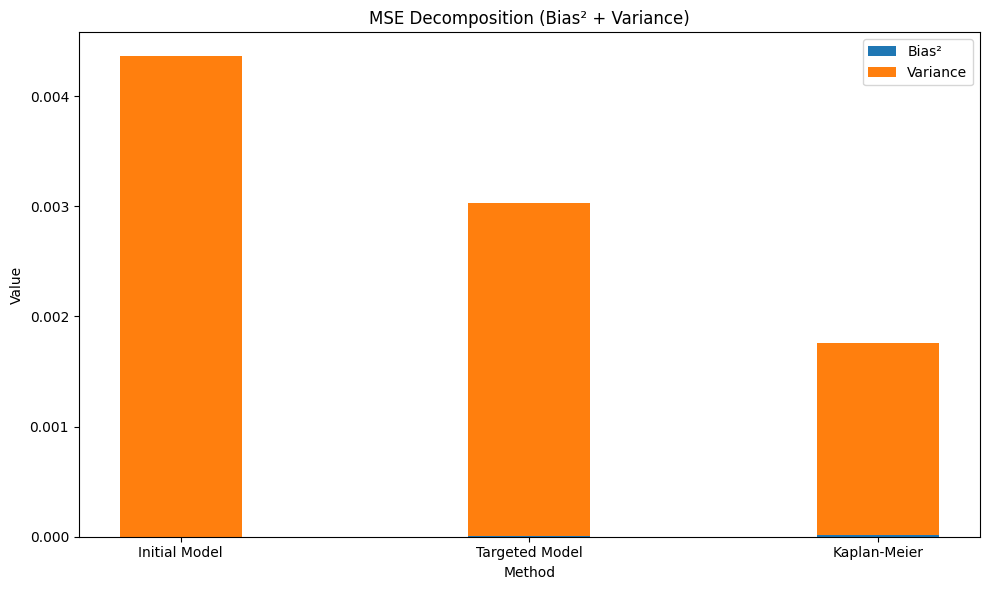

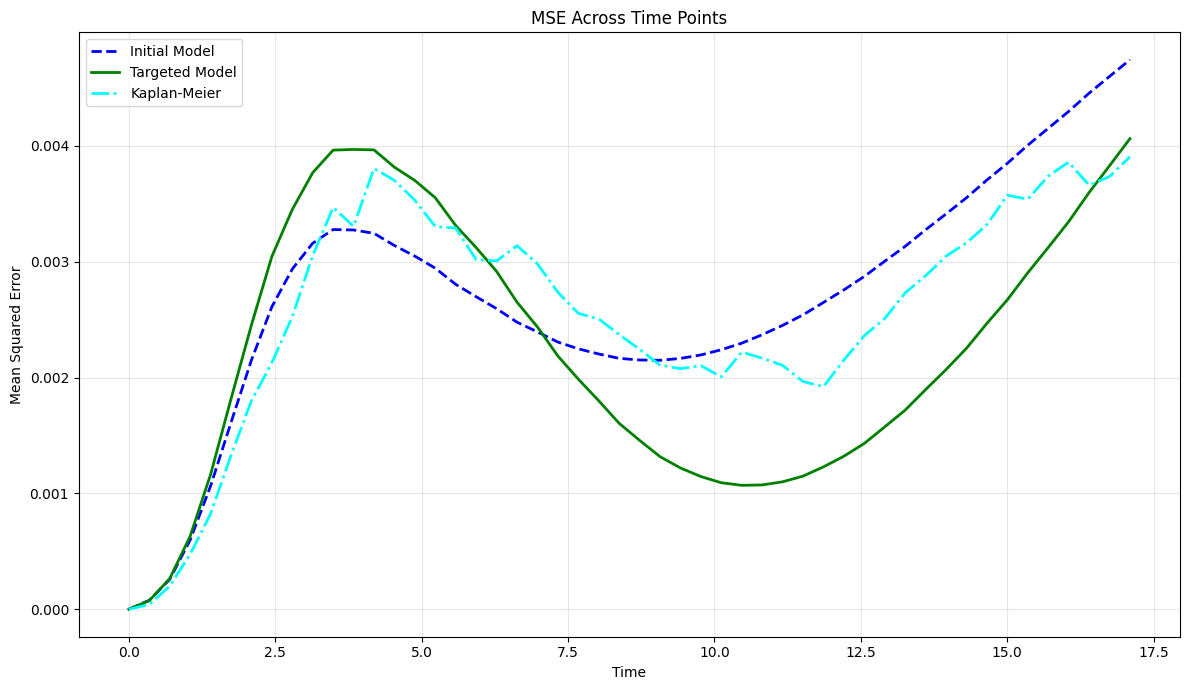

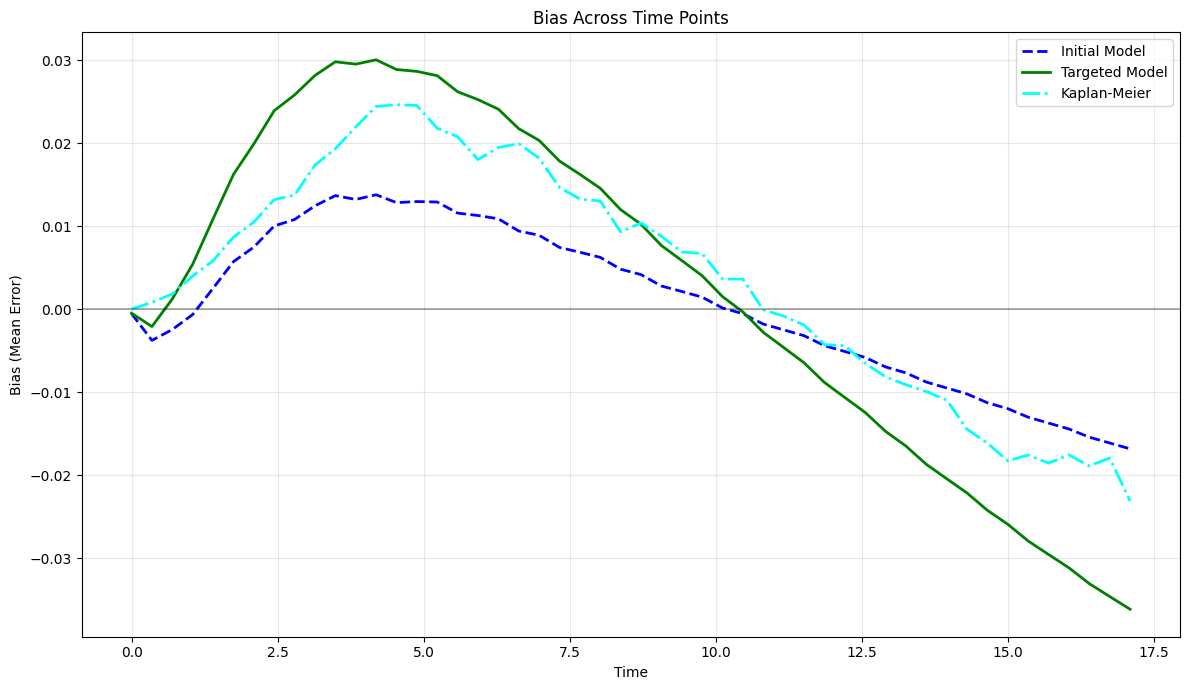

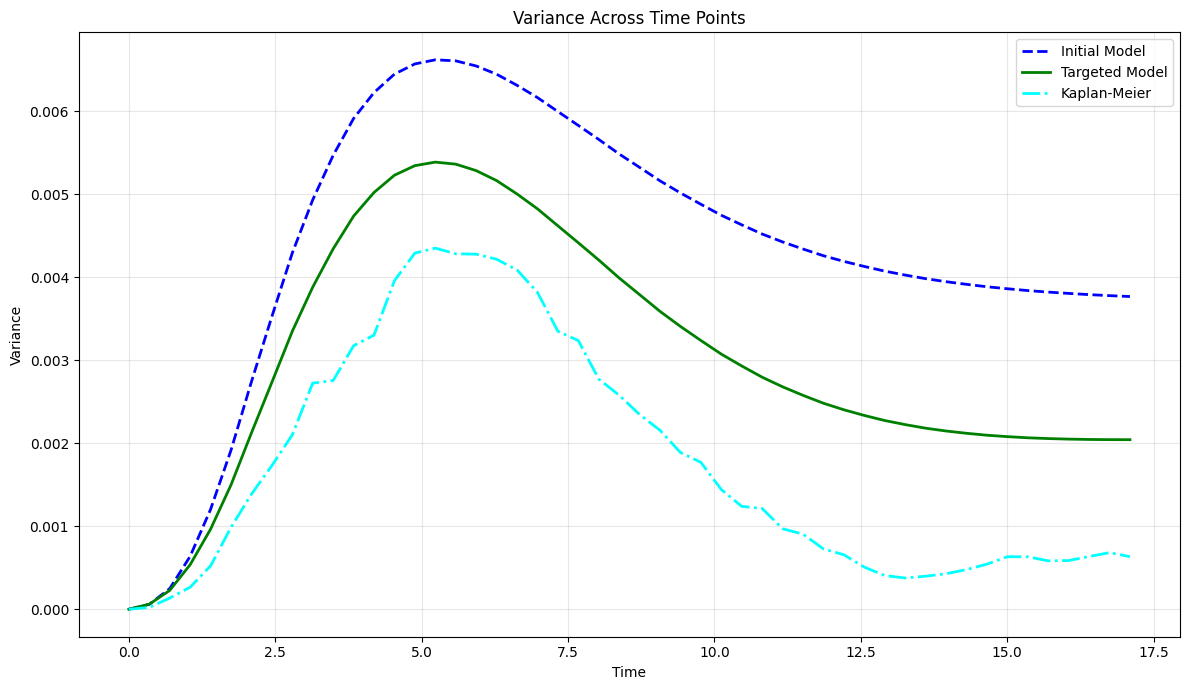

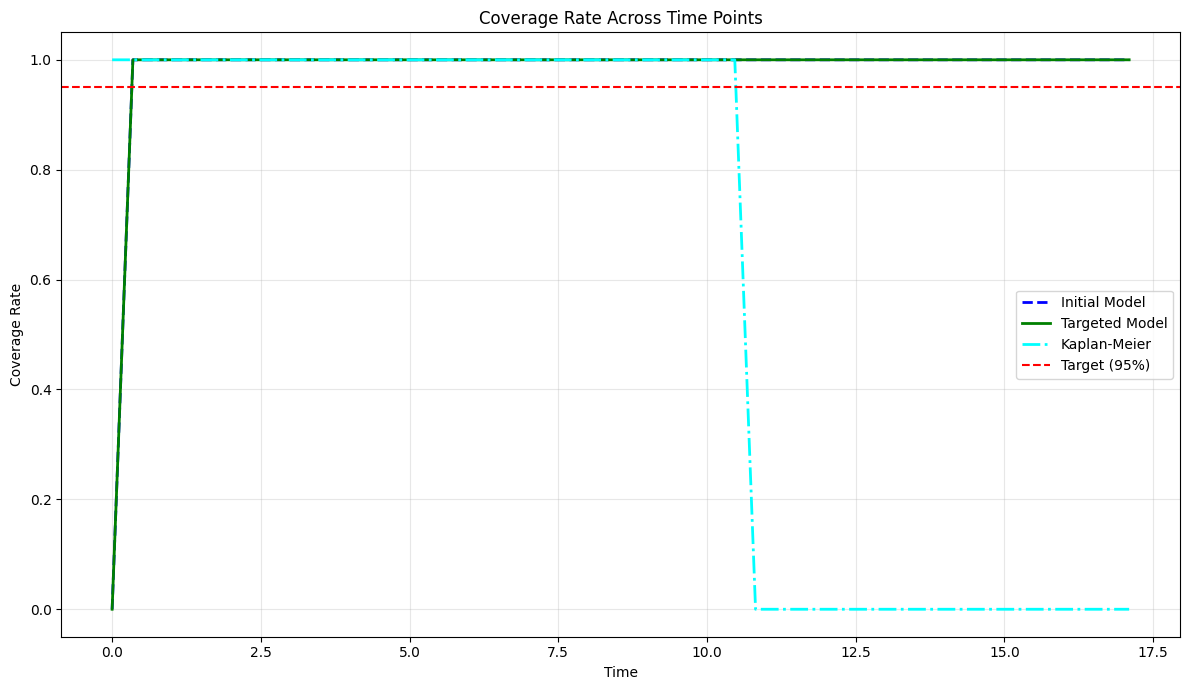

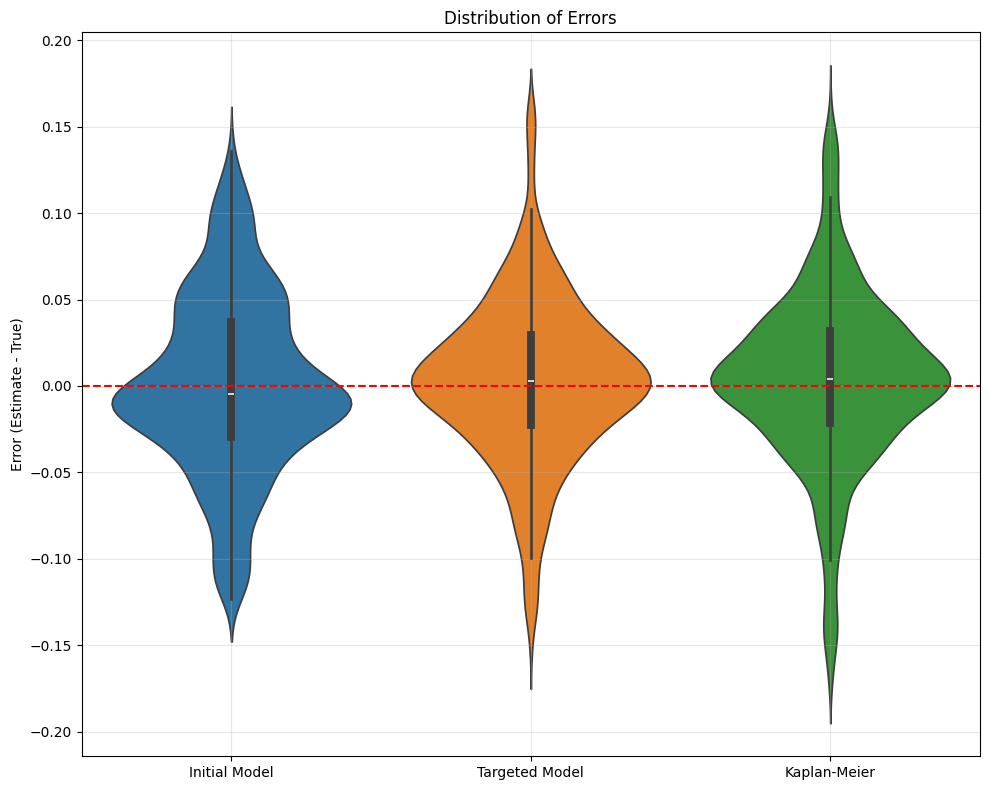

In [9]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to parse array strings from CSV
def parse_array_string(array_str):
    try:
        # Try first format with spaces
        arr = np.array([float(x) for x in array_str.strip('[]').split()])
        if len(arr) == 0:
            # Try alternate format with commas
            arr = np.array([float(x) for x in array_str.strip('[]').split(',')])
        return arr
    except:
        print(f"Error parsing array: {array_str[:30]}...")
        return np.array([])

# Load the simulation results
results_dir = 'results'
all_reps_file = os.path.join(results_dir, 'all_replications_metrics.csv')
survival_curves_file = os.path.join(results_dir, 'average_survival_curves.csv')

# Load average survival curves data (contains time points and true survival)
avg_data = pd.read_csv(survival_curves_file)
time_points = avg_data['time'].values
true_survival = avg_data['true_survival'].values

# Load all replication data
reps_data = pd.read_csv(all_reps_file)
n_reps = len(reps_data)
print(f"Loaded data from {n_reps} replications")

# Collect all survival curves from each replication
initial_curves = []
targeted_curves = []
km_curves = []
true_curves = []

# Process each replication
for i, row in reps_data.iterrows():
    try:
        # Extract curves
        true_curve = parse_array_string(row['true_survival'])
        initial_curve = parse_array_string(row['initial_survival'])
        targeted_curve = parse_array_string(row['targeted_survival'])
        km_curve = parse_array_string(row['km_survival'])
        
        # Only append if all parsing was successful and lengths match
        if len(true_curve) > 0 and len(true_curve) == len(time_points):
            true_curves.append(true_curve)
            initial_curves.append(initial_curve)
            targeted_curves.append(targeted_curve)
            km_curves.append(km_curve)
    except Exception as e:
        print(f"Error processing replication {i}: {e}")

# Convert to numpy arrays
true_curves = np.array(true_curves)
initial_curves = np.array(initial_curves)
targeted_curves = np.array(targeted_curves)
km_curves = np.array(km_curves)

n_successful = len(true_curves)
print(f"Successfully parsed {n_successful} replications")
print(f"Shape of survival curves: {true_curves.shape}")

# Calculate errors (difference from true survival)
initial_errors = initial_curves - true_curves
targeted_errors = targeted_curves - true_curves
km_errors = km_curves - true_curves

# Calculate squared errors
initial_sq_errors = initial_errors**2
targeted_sq_errors = targeted_errors**2
km_sq_errors = km_errors**2

# Calculate absolute errors (for MAE)
initial_abs_errors = np.abs(initial_errors)
targeted_abs_errors = np.abs(targeted_errors)
km_abs_errors = np.abs(km_errors)

# -------- Global performance metrics (averaged across all time points) --------

# Calculate MSE for each method across all time points
initial_mse_global = np.mean(initial_sq_errors)
targeted_mse_global = np.mean(targeted_sq_errors)
km_mse_global = np.mean(km_sq_errors)

# Calculate MAE for each method across all time points
initial_mae_global = np.mean(initial_abs_errors)
targeted_mae_global = np.mean(targeted_abs_errors)
km_mae_global = np.mean(km_abs_errors)

# Calculate bias for each method (average error)
initial_bias_global = np.mean(initial_errors)
targeted_bias_global = np.mean(targeted_errors)
km_bias_global = np.mean(km_errors)

# Calculate absolute bias for each method (average absolute error)
initial_abs_bias_global = np.mean(np.abs(np.mean(initial_errors, axis=0)))
targeted_abs_bias_global = np.mean(np.abs(np.mean(targeted_errors, axis=0)))
km_abs_bias_global = np.mean(np.abs(np.mean(km_errors, axis=0)))

# Calculate variance for each method
initial_variance_global = np.mean(np.var(initial_curves, axis=0))
targeted_variance_global = np.mean(np.var(targeted_curves, axis=0))
km_variance_global = np.mean(np.var(km_curves, axis=0))

# Calculate RMSE for each method
initial_rmse_global = np.sqrt(initial_mse_global)
targeted_rmse_global = np.sqrt(targeted_mse_global)
km_rmse_global = np.sqrt(km_mse_global)

# Calculate relative efficiency (ratio of MSEs)
efficiency_targeted_vs_initial = initial_mse_global / targeted_mse_global
efficiency_targeted_vs_km = km_mse_global / targeted_mse_global

# Calculate integrated MSE (IMSE) - average MSE over time
imse_initial = np.mean(np.mean(initial_sq_errors, axis=0))
imse_targeted = np.mean(np.mean(targeted_sq_errors, axis=0))
imse_km = np.mean(np.mean(km_sq_errors, axis=0))

# -------- Time-specific performance metrics --------

# Calculate MSE at each time point
initial_mse_by_time = np.mean(initial_sq_errors, axis=0)
targeted_mse_by_time = np.mean(targeted_sq_errors, axis=0)
km_mse_by_time = np.mean(km_sq_errors, axis=0)

# Calculate bias at each time point
initial_bias_by_time = np.mean(initial_errors, axis=0)
targeted_bias_by_time = np.mean(targeted_errors, axis=0)
km_bias_by_time = np.mean(km_errors, axis=0)

# Calculate variance at each time point
initial_variance_by_time = np.var(initial_curves, axis=0)
targeted_variance_by_time = np.var(targeted_curves, axis=0)
km_variance_by_time = np.var(km_curves, axis=0)

# -------- Key time points for detailed analysis --------

# Find early, middle, and late time points
early_idx = 5  # Early time point (adjust as needed)
middle_idx = len(time_points) // 2  # Middle time point
late_idx = len(time_points) - 5  # Late time point (adjust as needed)

key_time_points = [early_idx, middle_idx, late_idx]
key_time_values = [time_points[idx] for idx in key_time_points]

# Performance metrics at key time points
key_metrics = []
for idx in key_time_points:
    t = time_points[idx]
    true_surv = true_curves[0, idx]  # True survival at this time point
    
    # MSE at this time point
    init_mse = initial_mse_by_time[idx]
    target_mse = targeted_mse_by_time[idx]
    km_mse = km_mse_by_time[idx]
    
    # Bias at this time point
    init_bias = initial_bias_by_time[idx]
    target_bias = targeted_bias_by_time[idx]
    km_bias = km_bias_by_time[idx]
    
    # Variance at this time point
    init_var = initial_variance_by_time[idx]
    target_var = targeted_variance_by_time[idx]
    km_var = km_variance_by_time[idx]
    
    key_metrics.append({
        'Time': t,
        'True Survival': true_surv,
        'Initial MSE': init_mse,
        'Targeted MSE': target_mse,
        'KM MSE': km_mse,
        'Initial Bias': init_bias,
        'Targeted Bias': target_bias,
        'KM Bias': km_bias,
        'Initial Variance': init_var,
        'Targeted Variance': target_var,
        'KM Variance': km_var
    })

key_metrics_df = pd.DataFrame(key_metrics)

# -------- Create comprehensive summary table --------

# Create summary table with all global metrics
summary_metrics = {
    'Metric': [
        'Mean Squared Error (MSE)',
        'Root Mean Squared Error (RMSE)',
        'Mean Absolute Error (MAE)',
        'Bias (Mean Error)',
        'Absolute Bias',
        'Variance',
        'Integrated MSE (IMSE)',
        'Relative Efficiency vs Initial',
        'Relative Efficiency vs KM'
    ],
    'Initial Model': [
        initial_mse_global,
        initial_rmse_global,
        initial_mae_global,
        initial_bias_global,
        initial_abs_bias_global,
        initial_variance_global,
        imse_initial,
        1.0,  # Reference = 1
        km_mse_global / initial_mse_global
    ],
    'Targeted Model': [
        targeted_mse_global,
        targeted_rmse_global,
        targeted_mae_global,
        targeted_bias_global,
        targeted_abs_bias_global,
        targeted_variance_global,
        imse_targeted,
        efficiency_targeted_vs_initial,
        efficiency_targeted_vs_km
    ],
    'Kaplan-Meier': [
        km_mse_global,
        km_rmse_global,
        km_mae_global,
        km_bias_global,
        km_abs_bias_global,
        km_variance_global,
        imse_km,
        initial_mse_global / km_mse_global,
        1.0  # Reference = 1
    ]
}

summary_df = pd.DataFrame(summary_metrics)

# Calculate decomposition of MSE into bias^2 + variance
# (Note: this is a simplified decomposition; for proper bias-variance decomposition 
# you would need access to the true model)
decomp_metrics = {
    'Metric': [
        'MSE',
        'Bias^2',
        'Variance',
        'Bias^2 / MSE (%)',
        'Variance / MSE (%)'
    ]
}

for method, mse, bias, var in [
    ('Initial Model', initial_mse_global, initial_bias_global, initial_variance_global),
    ('Targeted Model', targeted_mse_global, targeted_bias_global, targeted_variance_global),
    ('Kaplan-Meier', km_mse_global, km_bias_global, km_variance_global)
]:
    bias_squared = bias**2
    decomp_metrics[method] = [
        mse,
        bias_squared,
        var,
        100 * bias_squared / mse,
        100 * var / mse
    ]

decomp_df = pd.DataFrame(decomp_metrics)

# -------- Calculate percentiles for error distribution --------

# For each method, calculate the percentile distribution of errors
percentiles = [2.5, 25, 50, 75, 97.5]

# Function to calculate percentiles across all errors
def calc_error_percentiles(errors):
    flat_errors = errors.flatten()
    return [np.percentile(flat_errors, p) for p in percentiles]

initial_error_percentiles = calc_error_percentiles(initial_errors)
targeted_error_percentiles = calc_error_percentiles(targeted_errors)
km_error_percentiles = calc_error_percentiles(km_errors)

percentile_df = pd.DataFrame({
    'Percentile': percentiles,
    'Initial Model': initial_error_percentiles,
    'Targeted Model': targeted_error_percentiles,
    'Kaplan-Meier': km_error_percentiles
})

# Calculate coverage rates
# Using 95% percentile bands to check if true survival falls within these bands
coverage_by_time = []

for t_idx in range(len(time_points)):
    # For each time point, calculate the 2.5th and 97.5th percentiles
    initial_lower = np.percentile(initial_curves[:, t_idx], 2.5)
    initial_upper = np.percentile(initial_curves[:, t_idx], 97.5)
    targeted_lower = np.percentile(targeted_curves[:, t_idx], 2.5)
    targeted_upper = np.percentile(targeted_curves[:, t_idx], 97.5)
    km_lower = np.percentile(km_curves[:, t_idx], 2.5)
    km_upper = np.percentile(km_curves[:, t_idx], 97.5)
    
    # Check if true survival is within these bands
    true_val = true_curves[0, t_idx]
    
    initial_covers = (initial_lower <= true_val) and (true_val <= initial_upper)
    targeted_covers = (targeted_lower <= true_val) and (true_val <= targeted_upper)
    km_covers = (km_lower <= true_val) and (true_val <= km_upper)
    
    coverage_by_time.append({
        'Time': time_points[t_idx],
        'Initial Coverage': initial_covers,
        'Targeted Coverage': targeted_covers,
        'KM Coverage': km_covers
    })

coverage_df = pd.DataFrame(coverage_by_time)

# Calculate overall coverage rate
initial_coverage_rate = coverage_df['Initial Coverage'].mean()
targeted_coverage_rate = coverage_df['Targeted Coverage'].mean()
km_coverage_rate = coverage_df['KM Coverage'].mean()

coverage_summary = pd.DataFrame({
    'Method': ['Initial Model', 'Targeted Model', 'Kaplan-Meier'],
    'Coverage Rate': [initial_coverage_rate, targeted_coverage_rate, km_coverage_rate],
    'Target Rate': [0.95, 0.95, 0.95]
})

# Print all summaries
print("\n========== OVERALL PERFORMANCE METRICS ==========")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

print("\n========== MSE DECOMPOSITION (BIAS² + VARIANCE) ==========")
print(decomp_df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

print("\n========== ERROR PERCENTILES ==========")
print(percentile_df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

print("\n========== PERFORMANCE AT KEY TIME POINTS ==========")
print(key_metrics_df.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

print("\n========== COVERAGE RATES ==========")
print(coverage_summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Save these metrics to CSV files
summary_df.to_csv(os.path.join(results_dir, 'performance_summary.csv'), index=False)
decomp_df.to_csv(os.path.join(results_dir, 'mse_decomposition.csv'), index=False)
percentile_df.to_csv(os.path.join(results_dir, 'error_percentiles.csv'), index=False)
key_metrics_df.to_csv(os.path.join(results_dir, 'key_timepoints_performance.csv'), index=False)
coverage_summary.to_csv(os.path.join(results_dir, 'coverage_summary.csv'), index=False)

# Create additional visualizations

# 1. MSE decomposition plot
plt.figure(figsize=(10, 6))
methods = ['Initial Model', 'Targeted Model', 'Kaplan-Meier']
bias_squared_vals = [decomp_metrics[m][1] for m in methods]
variance_vals = [decomp_metrics[m][2] for m in methods]

x = np.arange(len(methods))
width = 0.35

plt.bar(x, bias_squared_vals, width, label='Bias²')
plt.bar(x, variance_vals, width, bottom=bias_squared_vals, label='Variance')

plt.xlabel('Method')
plt.ylabel('Value')
plt.title('MSE Decomposition (Bias² + Variance)')
plt.xticks(x, methods)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'mse_decomposition_plot.png'), dpi=300)

# 2. MSE across time
plt.figure(figsize=(12, 7))
plt.plot(time_points, initial_mse_by_time, '--', color='blue', linewidth=2, label='Initial Model')
plt.plot(time_points, targeted_mse_by_time, '-', color='green', linewidth=2, label='Targeted Model')
plt.plot(time_points, km_mse_by_time, '-.', color='cyan', linewidth=2, label='Kaplan-Meier')
plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('MSE Across Time Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'mse_by_time.png'), dpi=300)

# 3. Bias across time
plt.figure(figsize=(12, 7))
plt.plot(time_points, initial_bias_by_time, '--', color='blue', linewidth=2, label='Initial Model')
plt.plot(time_points, targeted_bias_by_time, '-', color='green', linewidth=2, label='Targeted Model')
plt.plot(time_points, km_bias_by_time, '-.', color='cyan', linewidth=2, label='Kaplan-Meier')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Bias (Mean Error)')
plt.title('Bias Across Time Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'bias_by_time.png'), dpi=300)

# 4. Variance across time
plt.figure(figsize=(12, 7))
plt.plot(time_points, initial_variance_by_time, '--', color='blue', linewidth=2, label='Initial Model')
plt.plot(time_points, targeted_variance_by_time, '-', color='green', linewidth=2, label='Targeted Model')
plt.plot(time_points, km_variance_by_time, '-.', color='cyan', linewidth=2, label='Kaplan-Meier')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.title('Variance Across Time Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'variance_by_time.png'), dpi=300)

# 5. Coverage rate across time
plt.figure(figsize=(12, 7))
plt.plot(coverage_df['Time'], coverage_df['Initial Coverage'].astype(float), '--', color='blue', linewidth=2, label='Initial Model')
plt.plot(coverage_df['Time'], coverage_df['Targeted Coverage'].astype(float), '-', color='green', linewidth=2, label='Targeted Model')
plt.plot(coverage_df['Time'], coverage_df['KM Coverage'].astype(float), '-.', color='cyan', linewidth=2, label='Kaplan-Meier')
plt.axhline(y=0.95, color='red', linestyle='--', label='Target (95%)')
plt.xlabel('Time')
plt.ylabel('Coverage Rate')
plt.title('Coverage Rate Across Time Points')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'coverage_by_time.png'), dpi=300)

# 6. Error distribution violin plots
plt.figure(figsize=(10, 8))
error_data = {
    'Initial Model': initial_errors.flatten(),
    'Targeted Model': targeted_errors.flatten(),
    'Kaplan-Meier': km_errors.flatten()
}
error_df = pd.DataFrame({k: pd.Series(v) for k, v in error_data.items()})
sns.violinplot(data=error_df)
plt.axhline(y=0, color='red', linestyle='--')
plt.ylabel('Error (Estimate - True)')
plt.title('Distribution of Errors')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'error_distributions.png'), dpi=300)

# Calculate improvement percentages
improvement_metrics = {
    'Comparison': [
        'Targeted vs Initial (% improvement)',
        'Targeted vs KM (% improvement)',
        'KM vs Initial (% improvement)'
    ],
    'MSE': [
        100 * (1 - targeted_mse_global / initial_mse_global),
        100 * (1 - targeted_mse_global / km_mse_global),
        100 * (1 - km_mse_global / initial_mse_global)
    ],
    'RMSE': [
        100 * (1 - targeted_rmse_global / initial_rmse_global),
        100 * (1 - targeted_rmse_global / km_rmse_global),
        100 * (1 - km_rmse_global / initial_rmse_global)
    ],
    'MAE': [
        100 * (1 - targeted_mae_global / initial_mae_global),
        100 * (1 - targeted_mae_global / km_mae_global),
        100 * (1 - km_mae_global / initial_mae_global)
    ],
    'Absolute Bias': [
        100 * (1 - targeted_abs_bias_global / initial_abs_bias_global),
        100 * (1 - targeted_abs_bias_global / km_abs_bias_global),
        100 * (1 - km_abs_bias_global / initial_abs_bias_global)
    ]
}

improvement_df = pd.DataFrame(improvement_metrics)
print("\n========== IMPROVEMENT PERCENTAGES ==========")
print(improvement_df.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))
improvement_df.to_csv(os.path.join(results_dir, 'improvement_percentages.csv'), index=False)